In [4]:
import pandas as pd
from pathlib import Path
import sys

sys.path.append('/home/satish27may/ProteinDomainDetection')
from src.data.modelData import ObjectDetection

In [5]:
# create protein domain data    
# create all classes data from pfam fasta data
all_classes = ['Lysozyme-PF03245',
'Lysozyme-PF16754',
'Lysozyme-PF11860',
'Lysozyme-PF13702',
'Lysozyme-PF00959',
'Lysozyme-PF00182',
'Lysozyme-PF00704',
'Lysozyme-PF01374',
'Lysozyme-PF05838',
'Lysozyme-PF18013',
'Lysozyme-PF04965',
'Lysozyme-PF01183',
'Lysozyme-PF00722',
'peptidase-PF05193',
'peptidase-PF01551',
'peptidase-PF00675',
'peptidase-PF01435',
'peptidase-PF01433',
'peptidase-PF10502',
'peptidase-PF00246',
'peptidase-PF03572',
'peptidase-PF00814',
'peptidase-PF17900',
'Amidase_2-PF01510',
'Amidase_3-PF01520',
'CHAP-PF05257',
'SH3_4-PF06347',
'SH3_3-PF08239',
'SH3_5-PF08460',
'LysM-PF01476']
data_handler = ObjectDetection(class_names=all_classes)
protein_domain_data = data_handler.create_protein_domain_df()

Dropped 2663 number of duplicates based on sequences


In [7]:
protein_domain_data.columns

Index(['Class', 'SeqLen', 'Sequence', 'SuperClass', 'dom', 'dom_len',
       'dom_pos', 'id', 'img_pth', 'name'],
      dtype='object')

In [14]:
# analyse the sequence length and the domain lengths of all subclasses
print(protein_domain_data['SeqLen'].describe())

count    289056.000000
mean        458.756033
std         334.527416
min          26.000000
25%         271.000000
50%         391.000000
75%         526.000000
max       39677.000000
Name: SeqLen, dtype: float64


In [15]:
protein_domain_data['dom_len'].describe()

count    289056.000000
mean        159.005376
std          80.414673
min           6.000000
25%          97.000000
50%         159.000000
75%         202.000000
max         600.000000
Name: dom_len, dtype: float64

In [17]:
import math
sizes=(32, 64, 128, 256, 512)
aspect_ratios=(0.5, 1, 2)
anchors = []
for size in sizes:
    area = size ** 2.0
    for aspect_ratio in aspect_ratios:
        # s * s = w * h
        # a = h / w
        # ... some algebra ...
        # w = sqrt(s * s / a)
        # h = a * w
        w = math.sqrt(area / aspect_ratio)
        h = aspect_ratio * w
        x0, y0, x1, y1 = -w / 2.0, -h / 2.0, w / 2.0, h / 2.0
        anchors.append([x0, y0, x1, y1])


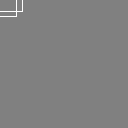

In [25]:
from PIL import Image, ImageDraw
for size in sizes:
    img = Image.new('RGB', (128,128),(128,128,128))
    draw = ImageDraw.Draw(img)
    draw.rectangle(anchors[0])
    draw.rectangle(anchors[1])
    break
img

In [26]:
anchors[0]

[-22.627416997969522,
 -11.313708498984761,
 22.627416997969522,
 11.313708498984761]

In [27]:
32*32, 22.6*11.3

(1024, 255.38000000000002)

In [41]:
def get_h_w(a,size):
    area=size**2
    w = math.sqrt(area / a)
    h = aspect_ratio * w
    return w,h
    
get_h_w(28,32)

(6.047431568147635, 12.09486313629527)

In [48]:
protein_domain_data[protein_domain_data['dom_len']<40]['SuperClass'].value_counts()

LysM         1176
peptidase     108
Lysozyme       64
Amidase_3      21
SH3_3           7
SH3_4           4
CHAP            2
Amidase_2       1
Name: SuperClass, dtype: int64

In [50]:
protein_domain_data[protein_domain_data['SuperClass']=='SH3_4'].shape

(1534, 10)

In [51]:
protein_domain_data[protein_domain_data['SuperClass']=='CHAP']['dom_len'].describe()

count    3149.000000
mean       90.841219
std         8.963512
min        35.000000
25%        85.000000
50%        91.000000
75%        96.000000
max       149.000000
Name: dom_len, dtype: float64

In [1]:
"""
Model to train protein sequences of len btw 0-300 and samples size 0-1000
"""
import sys, random , re, os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import math

import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

ProjectRoot = Path('/home/satish27may/ProteinDomainDetection/')
print(f"ProjectRoot: {ProjectRoot}")
sys.path.append(str(ProjectRoot))

from src.data.modelData import ObjectDetection, create_protein_seq_image



seq_len_bucket = (0, 1000)
num_sample_bucket = (0,100000)
img_h, img_w = 64, seq_len_bucket[1]
config_name = f"seq_len_{seq_len_bucket[0]}-{seq_len_bucket[1]}_and_num_samples_{num_sample_bucket[0]}-{num_sample_bucket[1]}"

os.system(f"trash-put {str(ProjectRoot/f'data/PfamData/{config_name}_images')}")
os.system(f"trash-put {str(ProjectRoot/f'models/{config_name}_model')}")

# create model dir to save checkpoints
all_models_dir = ProjectRoot/'models'
if not all_models_dir.exists():
    all_models_dir.mkdir(exist_ok=True, parents=True)
model_dir = ProjectRoot/f'models/{config_name}_model'
model_dir.mkdir(exist_ok=True, parents=True)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# # log to log file
# log_file = model_dir/'logs.txt'
# sys.stdout = open(str(log_file), 'w')
    
# create all classes data from pfam fasta data
all_classes = ['Lysozyme-PF03245',
'Lysozyme-PF16754',
'Lysozyme-PF11860',
'Lysozyme-PF13702',
'Lysozyme-PF00959',
'Lysozyme-PF00182',
'Lysozyme-PF00704',
'Lysozyme-PF01374',
'Lysozyme-PF05838',
'Lysozyme-PF18013',
'Lysozyme-PF04965',
'Lysozyme-PF01183',
'Lysozyme-PF00722',
'peptidase-PF05193',
'peptidase-PF01551',
'peptidase-PF00675',
'peptidase-PF01435',
'peptidase-PF01433',
'peptidase-PF10502',
'peptidase-PF00246',
'peptidase-PF03572',
'peptidase-PF00814',
'peptidase-PF17900',
'Amidase_2-PF01510',
'Amidase_3-PF01520',
'CHAP-PF05257',
'SH3_4-PF06347',
'SH3_3-PF08239',
'SH3_5-PF08460',
'LysM-PF01476']

# SH3_4 and CHAP
subset_classes = ['PF06347']
# Lysozyme and SH3_4
# subset_classes = ['PF01374', 'PF06347']
data_handler = ObjectDetection(class_names=['SH3_4-PF06347'])
protein_domain_data = data_handler.create_protein_domain_df()

# filter sequences below 1k
protein_domain_data = protein_domain_data[protein_domain_data['SeqLen']<1000]

# create data df for choosen config
bucket_df = data_handler.get_bucketised_data(protein_domain_data, seq_len_bucket, num_sample_bucket)
class_freq_map = dict(bucket_df['Class'].value_counts())
classes = [cls for cls in list(bucket_df['Class'].unique()) if class_freq_map[cls]>50]
bucket_df = bucket_df[bucket_df['Class'].isin(classes)]
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
bucket_df = bucket_df[bucket_df['Class'].isin(subset_classes)]
classes = list(bucket_df['Class'].unique())
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
bucket_df.to_csv(ProjectRoot/f"data/PfamData/seq_len_{'-'.join([str(x) for x in seq_len_bucket])}_and_num_samples_{'-'.join([str(x) for x in num_sample_bucket])}_data.csv",index=False)


# create image data for choosen config
data_handler.create_bucket_image_data(bucket_df, seq_len_bucket, num_sample_bucket)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# data_handler.create_bucket_patch_image_data(bucket_df, seq_len_bucket, num_sample_bucket)
# data_handler.create_bucket_sequence2histogram(bucket_df, seq_len_bucket, num_sample_bucket)


# print config data summary
images_dir = ProjectRoot/f"data/PfamData/{config_name}_images"
model_data =  pd.read_csv(ProjectRoot/f"data/PfamData/{config_name}_data.csv")
print(f"Selected {model_data['Class'].nunique()} classes:\n{model_data['Class'].unique()}")



###############################################Create Model Data##############################################################################

from ast import literal_eval
def create_train_valid_test_data(data_df):
    train_dfs,valid_dfs = [],[],
    for class_name in data_df['Class'].unique():
        class_df = data_df[data_df['Class']==class_name].sample(frac=1)
        num_samples = class_df.shape[0]
        num_train_samples = int(round(num_samples*0.7))
        train_dfs.append(class_df.iloc[:num_train_samples,:])
        valid_dfs.append(class_df.iloc[num_train_samples:,:])
    return pd.concat(train_dfs,axis='rows').sample(frac=1), pd.concat(valid_dfs,axis='rows').sample(frac=1)
    
def create_dataset(model_data, img_h, img_w, mode, classes, aug_data):
    model_data = model_data[model_data['Class'].isin([x.split('-')[-1] for x in classes])]
    print(f"Classes selected: {model_data['Class'].unique()}")
    print(f"SuperClasses selected: {model_data['SuperClass'].unique()}")
    model_data = model_data.reset_index(drop=True)
    model_data['dom_pos'] = model_data['dom_pos'].apply(lambda x: literal_eval(x))
#     print(model_data['dom_pos'].head())
    C2I = {class_name:index for index, class_name in enumerate(model_data['Class'].unique())}
    train_dicts_list = []
    valid_dicts_list = []
    train, valid = create_train_valid_test_data(model_data)
    if aug_data:
        print(f"train data before aug: {train.shape[0]}\n{train['Class'].value_counts()}")
        train = data_handler.augment_data(train,(img_h,img_w), num_augs=300)
        print(f"Class dist in train after aug:\n {train['Class'].value_counts()}")
        print(f'train data after aug: {train.shape[0]}')
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    for index in tqdm(range(train.shape[0])):
        dom_pos_list = train['dom_pos'][index]
#         print(dom_pos_list, type(dom_pos_list))
        if len(dom_pos_list)>1:
            train_annts = []
            for dom_index in range(len(dom_pos_list)):
                x1,x2 = dom_pos_list[dom_index]
                train_annts.append({'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[train['Class'][index]],
                                          })
        elif len(dom_pos_list)==1:
            x1,x2 = dom_pos_list[0]
            train_annts = [{'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[train['Class'][index]],
                                          }]
            
                
        train_dicts_list.append({'file_name':train['img_pth'][index],
                           'height':img_h,
                           'width': img_w,
                           'image_id': index,
                           'annotations':train_annts,
                          })
        
    for index in tqdm(range(valid.shape[0])):
        dom_pos_list = valid['dom_pos'][index]
        if len(dom_pos_list)>1:
            valid_annts = []
            for dom_index in range(len(dom_pos_list)):
                x1, x2 = dom_pos_list[dom_index]
                valid_annts.append({'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[valid['Class'][index]],
                                          })
        elif len(dom_pos_list)==1:
            x1, x2 = dom_pos_list[0]
            valid_annts = [{'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[valid['Class'][index]],
                                          }]
        valid_dicts_list.append({'file_name':valid['img_pth'][index],
                           'height':img_h,
                           'width': img_w,
                           'image_id': index,
                           'annotations':valid_annts
                          })
    if mode=='train':return train_dicts_list
    elif mode=='valid': return valid_dicts_list

def generate_data_sepecific_anchors(df):
    print(f"Min and Max dom lens in data: {df['dom_len'].min()}, {df['dom_len'].max()}")
    anchor_widths = []
    for i in range(10,100,10):
        anchor_widths.append(df['dom_len'].quantile(i/100))
    anchor_widths.extend([min(df['dom_len']), max(df['dom_len'])])
    anchor_heights = [img_h]*len(anchor_widths)
    anchor_sizes = [round(int(math.sqrt(h*w))) for h, w in zip(anchor_heights, anchor_widths)]
    anchor_ratios = [(s/w)**2 for s, w in zip(anchor_sizes, anchor_widths)]
    return anchor_sizes, anchor_ratios


# create train and valid data
train_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='train', classes=classes, aug_data=False)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! augmentation enabled
valid_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='valid', classes=classes, aug_data=False)
def get_train_data():
    return train_list

def get_valid_data():
    return valid_list


# add custom dataset to detectron 2 pipline
DatasetCatalog.register("train", get_train_data)
DatasetCatalog.register("valid", get_valid_data)

MetadataCatalog.get("train").set(thing_classes = classes)
MetadataCatalog.get("valid").set(thing_classes = classes)



##############################################################################################################################################
# # train model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("train",)
# cfg.DATASETS.TEST = ("valid",)
# #cfg.MODEL.PIXEL_MEAN = data_mean
# #cfg.MODEL.PIXEL_STD = data_std
# cfg.INPUT.RANDOM_FLIP = "vertical"
# cfg.TEST.DETECTIONS_PER_IMAGE = 100

# cfg.INPUT.MIN_SIZE_TRAIN = 800
# cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# # Maximum size of the side of the image during training
# cfg.INPUT.MAX_SIZE_TRAIN = 1330
# # Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
# cfg.INPUT.MIN_SIZE_TEST = 800
# # Maximum size of the side of the image during testing
# cfg.INPUT.MAX_SIZE_TEST = 1330


# cfg.TEST.AUG.FLIP = False
# cfg.DATALOADER.NUM_WORKERS = 8
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 9e-4  
# cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
# #cfg.MODEL.RETINANET.IOU_THRESHOLDS = [0.4, 0.5]
# cfg.SOLVER.MAX_ITER = 30000
# cfg.MODEL.RETINANET.NUM_CLASSES = len(classes)
# # cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(data_handler.class_names)

# #exp
# data_specific_anchors_sizes, data_specific_ratios = generate_data_sepecific_anchors(bucket_df)
# data_specific_anchors_sizes = list(set(data_specific_anchors_sizes))
# data_specific_ratios = list(set(data_specific_ratios))

# # print('Data Specific anchor sizes:', data_specific_anchors_sizes)
# # print('Data Specific anchor ratios:', data_specific_ratios)
# # data_specific_anchors_sizes.extend([32, 64, 128, 256, 512])
# # data_specific_ratios.extend([0.5, 1,2])
# # cfg.MODEL.ANCHOR_GENERATOR.SIZES = data_specific_anchors_sizes
# # cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = data_specific_ratios
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1, 2]]

# # exp
# cfg.MODEL.RESNETS.NORM = "BN"
# # cfg.MODEL.RETINANET.NORM = "SyncBN" # not working
# # from detectron2.config import CfgNode as CN
# # cfg.INPUT.CROP = CN({"ENABLED": True})
# # cfg.INPUT.CROP.TYPE = "relative_range"
# # cfg.INPUT.CROP.SIZE = [0.95, 0.95]

# cfg.OUTPUT_DIR =str(model_dir)
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train() #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# # evaluate model
# evaluator = COCOEvaluator("valid", ("bbox",), False, output_dir=cfg.OUTPUT_DIR )
# val_loader = build_detection_test_loader(cfg, "valid")
# trainer.test(cfg, trainer.model, evaluator)





/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


ProjectRoot: /home/satish27may/ProteinDomainDetection
Fetching data with sequence len in btw (0, 1000) and class with num samples btw (0, 100000)
Bucket class distribution: PF06347    1651
Name: Class, dtype: int64
  Sequences lens: min=59, max = 997
Genreating  images of dim 64x1000 data bucket with sequence len in btw (0, 1000) and class with num samples btw (0, 100000)


100%|██████████| 495/495 [00:00<00:00, 4757.42it/s]

Selected 1 classes:
['PF06347']
Classes selected: ['PF06347']
SuperClasses selected: ['SH3_4']
Classes selected: ['PF06347']
SuperClasses selected: ['SH3_4']



100%|██████████| 495/495 [00:00<00:00, 23110.78it/s]


Metadata(name='valid', thing_classes=['PF06347'])

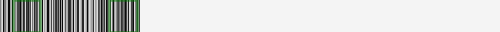

In [23]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("train")
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    #outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train").set(thing_classes = classes), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    imgs = []
    for bbox in d['annotations']:
#         print(bbox)
        imgs.append(v.draw_box(bbox['bbox']))
    cv2_imshow(i.get_image()[:, :, ::-1])

In [5]:
dataset_dicts[0]

{'annotations': [{'bbox': [52, 0, 108, 64],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0},
  {'bbox': [121, 0, 175, 64],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': '/home/satish27may/ProteinDomainDetection/data/PfamData/None_images/img_A0A2A3CEL4_9RHIZ_PF06347_SH3_4.png',
 'height': 64,
 'image_id': 0,
 'width': 1000}

In [1]:
# training model by padding sequence based on longest sequence in a class

"""
Model to train protein sequences of len btw 0-300 and samples size 0-1000
"""
import sys, random , re, os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import math

import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

ProjectRoot = Path('/home/satish27may/ProteinDomainDetection/')
print(f"ProjectRoot: {ProjectRoot}")
sys.path.append(str(ProjectRoot))

from src.data.modelData import ObjectDetection, create_protein_seq_image
    
# create all classes data from pfam fasta data
all_classes = ['Lysozyme-PF03245',
'Lysozyme-PF16754',
'Lysozyme-PF11860',
'Lysozyme-PF13702',
'Lysozyme-PF00959',
'Lysozyme-PF00182',
'Lysozyme-PF00704',
'Lysozyme-PF01374',
'Lysozyme-PF05838',
'Lysozyme-PF18013',
'Lysozyme-PF04965',
'Lysozyme-PF01183',
'Lysozyme-PF00722',
'peptidase-PF05193',
'peptidase-PF01551',
'peptidase-PF00675',
'peptidase-PF01435',
'peptidase-PF01433',
'peptidase-PF10502',
'peptidase-PF00246',
'peptidase-PF03572',
'peptidase-PF00814',
'peptidase-PF17900',
'Amidase_2-PF01510',
'Amidase_3-PF01520',
'CHAP-PF05257',
'SH3_4-PF06347',
'SH3_3-PF08239',
'SH3_5-PF08460',
'LysM-PF01476']

class_name = 'PF06347'
config_name = f"{class_name}"
os.system(f"trash-put {str(ProjectRoot/f'data/PfamData/{config_name}_images')}")
os.system(f"trash-put {str(ProjectRoot/f'models/{config_name}_model')}")

# create model dir to save checkpoints
all_models_dir = ProjectRoot/'models'
if not all_models_dir.exists():
    all_models_dir.mkdir(exist_ok=True, parents=True)
model_dir = ProjectRoot/f'models/{config_name}_model'
model_dir.mkdir(exist_ok=True, parents=True)
data_handler = ObjectDetection(class_names=all_classes)
protein_domain_data = data_handler.create_protein_domain_df()




# create data df for choosen config
class_df = protein_domain_data[protein_domain_data['Class']==class_name]
class_max_seq_len = max(class_df['SeqLen'])
img_h, img_w = 64, class_max_seq_len
classes = list(class_df['Class'].unique())

class_df.to_csv(ProjectRoot/f"data/PfamData/{class_name}_data.csv",index=False)


# create image data for choosen config
data_handler.create_class_image_data(class_df, class_max_seq_len, class_name)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# print config data summary
images_dir = ProjectRoot/f"data/PfamData/{config_name}_images"
model_data =  pd.read_csv(ProjectRoot/f"data/PfamData/{config_name}_data.csv")
print(f"Selected {model_data['Class'].nunique()} classes:\n{model_data['Class'].unique()}")



###############################################Create Model Data##############################################################################


def create_train_valid_test_data(data_df):
    train_dfs,valid_dfs = [],[],
    for class_name in data_df['Class'].unique():
        class_df = data_df[data_df['Class']==class_name].sample(frac=1)
        num_samples = class_df.shape[0]
        num_train_samples = int(round(num_samples*0.7))
        train_dfs.append(class_df.iloc[:num_train_samples,:])
        valid_dfs.append(class_df.iloc[num_train_samples:,:])
    return pd.concat(train_dfs,axis='rows').sample(frac=1), pd.concat(valid_dfs,axis='rows').sample(frac=1)
    
def create_dataset(model_data, img_h, img_w, mode, classes, aug_data):
    model_data = model_data[model_data['Class'].isin([x.split('-')[-1] for x in classes])]
    print(f"Classes selected: {model_data['Class'].unique()}")
    print(f"SuperClasses selected: {model_data['SuperClass'].unique()}")
    model_data = model_data.reset_index(drop=True)
    model_data['dom_pos'] = model_data['dom_pos'].apply(lambda x: [int(y) for y in x.replace('[','').replace(']','').split(',')])
    C2I = {class_name:index for index, class_name in enumerate(model_data['Class'].unique())}
    train_dicts_list = []
    valid_dicts_list = []
    train, valid = create_train_valid_test_data(model_data)
    if aug_data:
        print(f"train data before aug: {train.shape[0]}\n{train['Class'].value_counts()}")
        train = data_handler.augment_data(train,(img_h,img_w), num_augs=300)
        print(f"Class dist in train after aug:\n {train['Class'].value_counts()}")
        print(f'train data after aug: {train.shape[0]}')
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    for index in tqdm(range(train.shape[0])):
        x1,x2 = train['dom_pos'][index]
        train_dicts_list.append({'file_name':train['img_pth'][index],
                           'height':img_h,
                           'width': img_w,
                           'image_id': index,
                           'annotations':[{'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[train['Class'][index]],
                                          }]
                          })
    for index in tqdm(range(valid.shape[0])):
        x1,x2 = valid['dom_pos'][index]
        valid_dicts_list.append({'file_name':valid['img_pth'][index],
                           'height':img_h,
                           'width': img_w,
                           'image_id': index,
                           'annotations':[{'bbox':[x1, 0, x2, img_h],
                                           'bbox_mode':BoxMode.XYXY_ABS,
                                           'category_id':  C2I[valid['Class'][index]],
                                          }]
                          })
    if mode=='train':return train_dicts_list
    elif mode=='valid': return valid_dicts_list



# create train and valid data
train_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='train', classes=classes, aug_data=False)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! augmentation enabled
valid_list = create_dataset(model_data, img_h=img_h, img_w=img_w, mode='valid', classes=classes, aug_data=False)
def get_train_data():
    return train_list

def get_valid_data():
    return valid_list


# add custom dataset to detectron 2 pipline
DatasetCatalog.register("train", get_train_data)
DatasetCatalog.register("valid", get_valid_data)

MetadataCatalog.get("train").set(thing_classes = classes)
MetadataCatalog.get("valid").set(thing_classes = classes)



##############################################################################################################################################
# train model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
#cfg.MODEL.PIXEL_MEAN = data_mean
#cfg.MODEL.PIXEL_STD = data_std
cfg.INPUT.RANDOM_FLIP = "vertical"
cfg.TEST.DETECTIONS_PER_IMAGE = 100

cfg.INPUT.MIN_SIZE_TRAIN = 800
cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 1330
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 800
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 1330


cfg.TEST.AUG.FLIP = False
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 9e-4  
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
#cfg.MODEL.RETINANET.IOU_THRESHOLDS = [0.4, 0.5]
cfg.SOLVER.MAX_ITER = 3000*5
cfg.MODEL.RETINANET.NUM_CLASSES = len(classes)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(data_handler.class_names)


# exp
cfg.MODEL.RESNETS.NORM = "BN"


cfg.OUTPUT_DIR =str(model_dir)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train() #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# evaluate model
evaluator = COCOEvaluator("valid", ("bbox",), False, output_dir=cfg.OUTPUT_DIR )
val_loader = build_detection_test_loader(cfg, "valid")
trainer.test(cfg, trainer.model, evaluator)





/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


ProjectRoot: /home/satish27may/ProteinDomainDetection
Dropped 2663 number of duplicates based on sequences
Genreating  images of dim 64x1506 for PF06347 data


/home/satish27may/ProteinDomainDetection/src/data/modelData.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_df['img_pth'] = data_df['img_pth'].apply(lambda x: str(x).replace('images_224', f"{class_name}_images"))
100%|██████████| 460/460 [00:00<00:00, 24502.55it/s]
Loading config /home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


Selected 1 classes:
['PF06347']
Classes selected: ['PF06347']
SuperClasses selected: ['SH3_4']
Classes selected: ['PF06347']
SuperClasses selected: ['SH3_4']
[12/08 14:30:43 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.


[12/08 14:30:45 d2.engine.train_loop]: Starting training from iteration 0


/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/fvcore/transforms/transform.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))
/home/satish27may/anaconda3/envs/detectron2/lib/python3.7/site-packages/fvcore/transforms/transform.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writea

[12/08 14:30:48 d2.utils.events]:  eta: 0:16:41  iter: 19  total_loss: 1.667  loss_cls: 1.029  loss_box_reg: 0.6524  time: 0.0944  data_time: 0.0278  lr: 1.7983e-05  max_mem: 657M
[12/08 14:30:50 d2.utils.events]:  eta: 0:15:41  iter: 39  total_loss: 1.586  loss_cls: 1.051  loss_box_reg: 0.5475  time: 0.0774  data_time: 0.0036  lr: 3.5964e-05  max_mem: 657M
[12/08 14:30:51 d2.utils.events]:  eta: 0:15:44  iter: 59  total_loss: 1.366  loss_cls: 0.9566  loss_box_reg: 0.4055  time: 0.0730  data_time: 0.0038  lr: 5.3945e-05  max_mem: 657M
[12/08 14:30:52 d2.utils.events]:  eta: 0:15:43  iter: 79  total_loss: 0.9834  loss_cls: 0.6725  loss_box_reg: 0.334  time: 0.0715  data_time: 0.0038  lr: 7.1924e-05  max_mem: 657M
[12/08 14:30:54 d2.utils.events]:  eta: 0:15:37  iter: 99  total_loss: 0.746  loss_cls: 0.476  loss_box_reg: 0.2713  time: 0.0703  data_time: 0.0037  lr: 8.9901e-05  max_mem: 657M
[12/08 14:30:55 d2.utils.events]:  eta: 0:15:39  iter: 119  total_loss: 0.5986  loss_cls: 0.3886  

OrderedDict([('bbox',
              {'AP': 82.24098673201405,
               'AP50': 86.38734742163993,
               'AP75': 84.61054689185453,
               'APl': nan,
               'APm': 82.24326764689258,
               'APs': nan})])

In [2]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

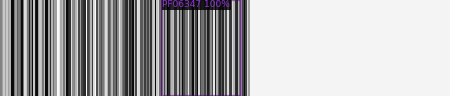

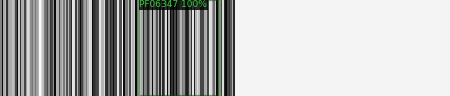

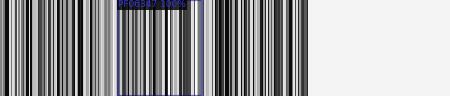

In [3]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("train")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train").set(thing_classes = classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

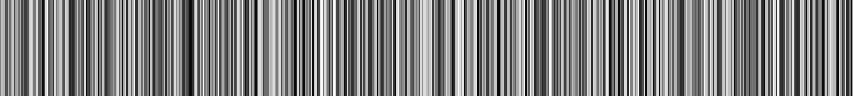

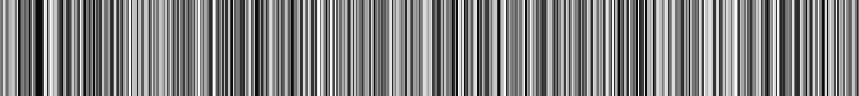

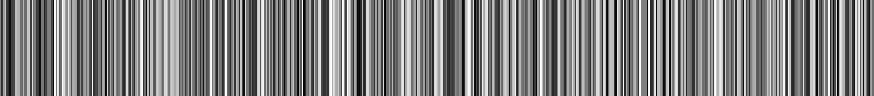

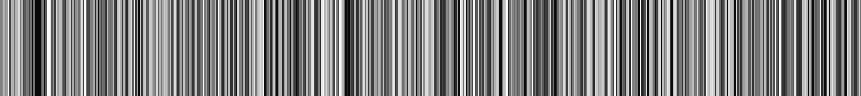

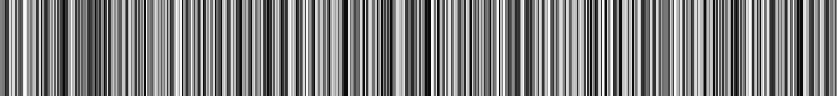

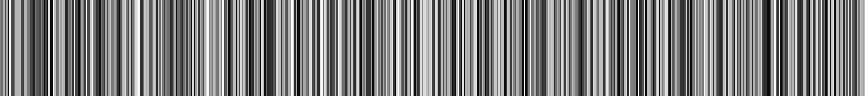

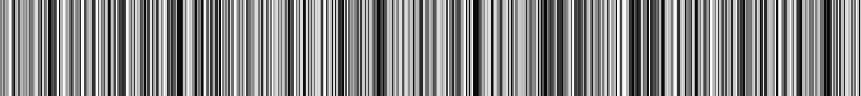

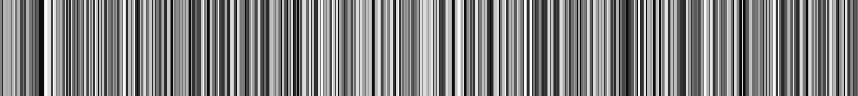

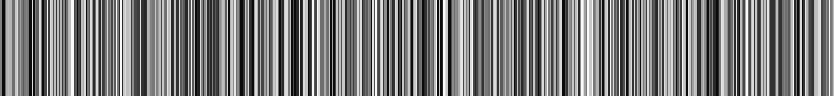

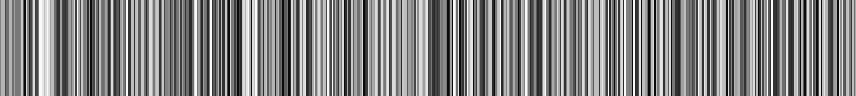

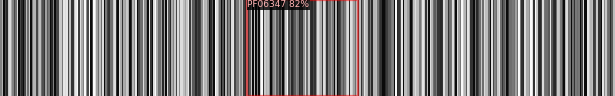

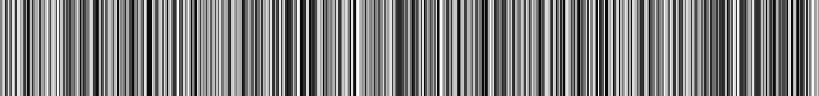

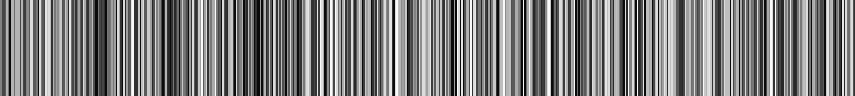

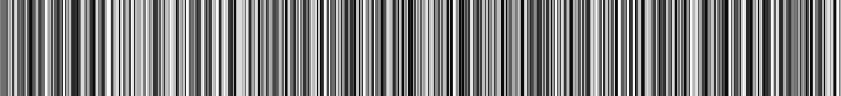

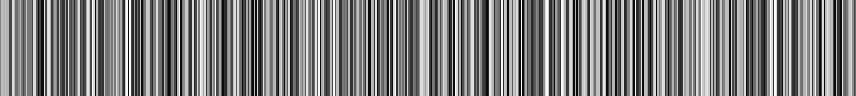

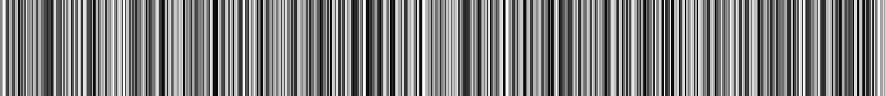

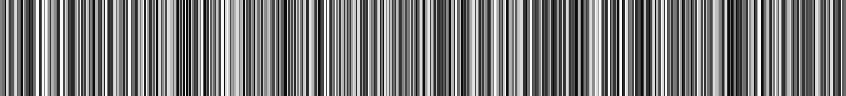

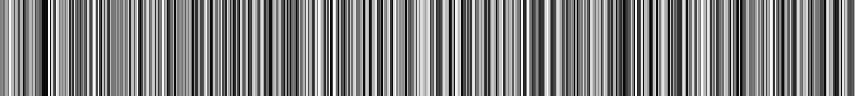

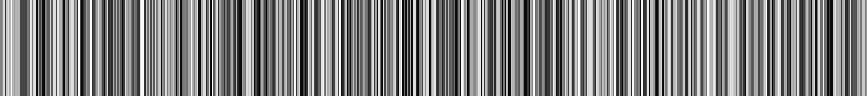

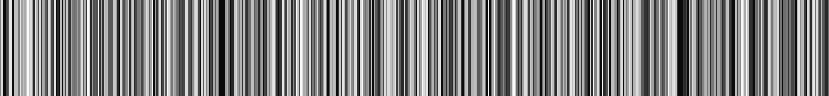

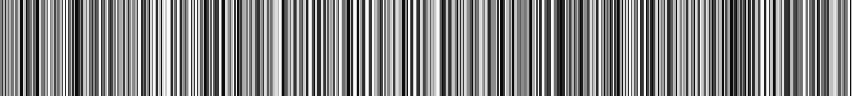

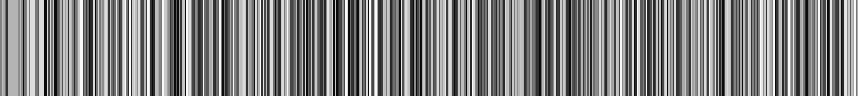

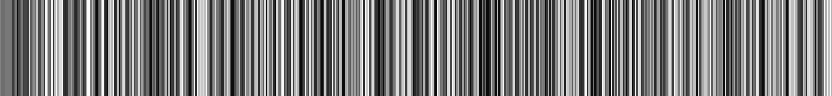

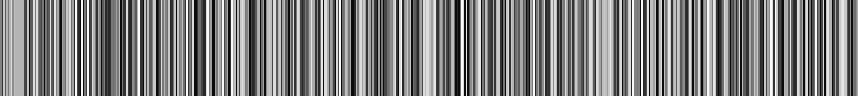

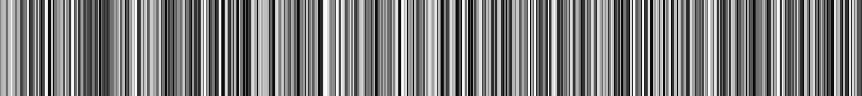

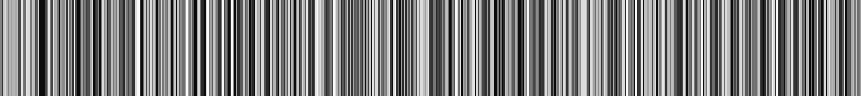

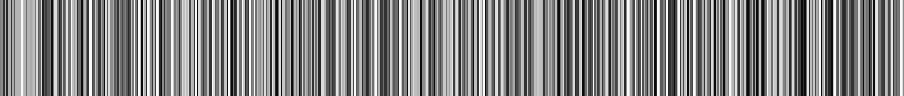

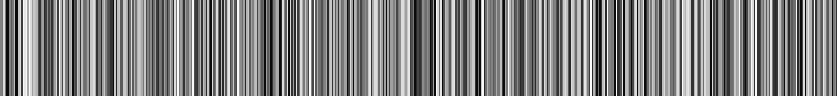

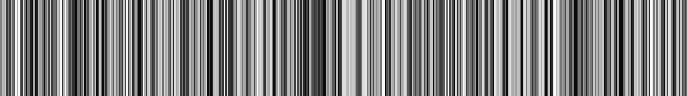

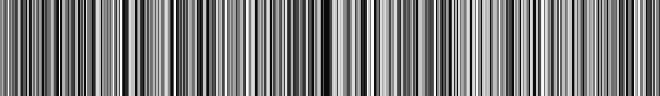

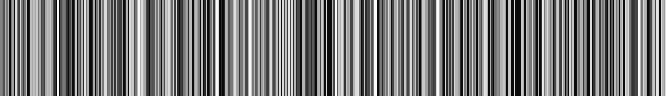

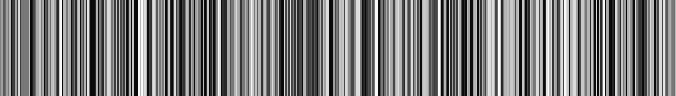

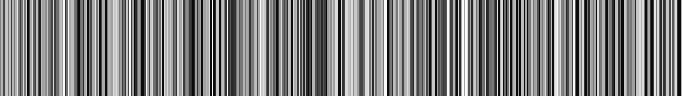

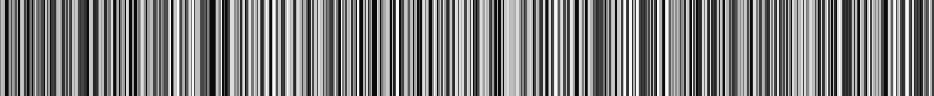

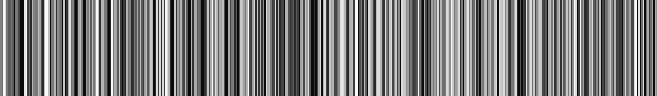

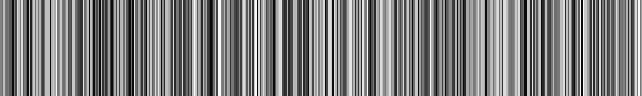

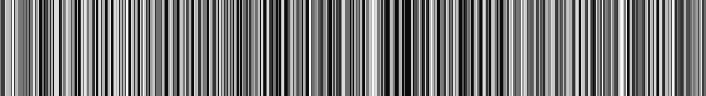

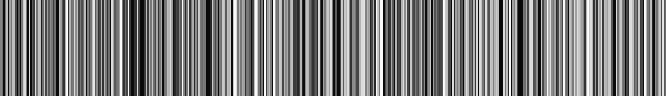

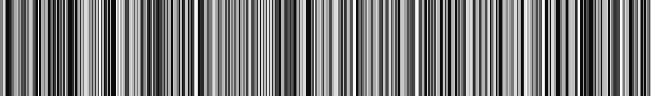

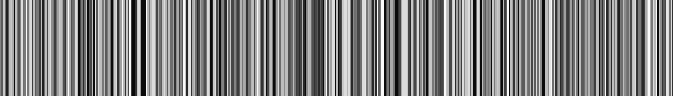

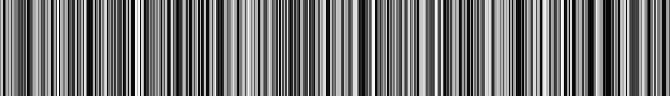

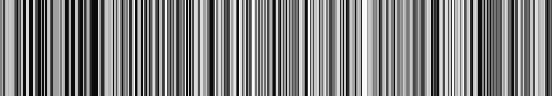

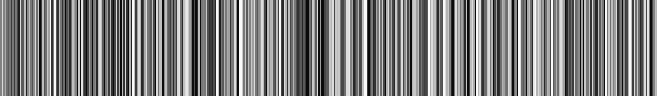

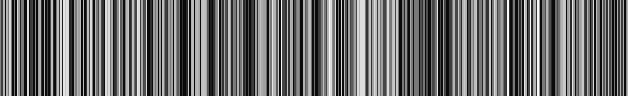

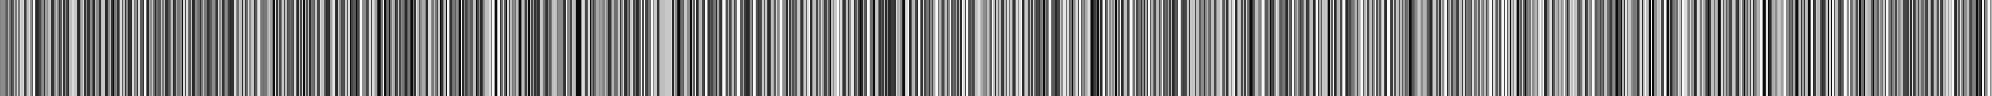

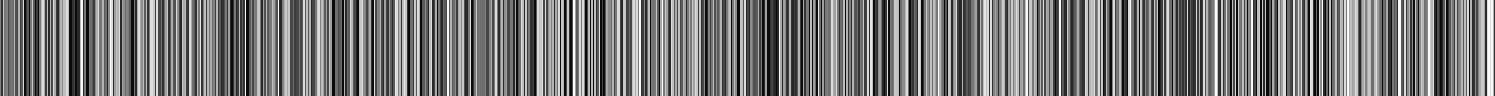

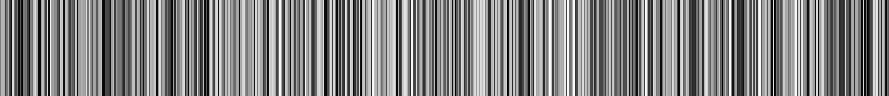

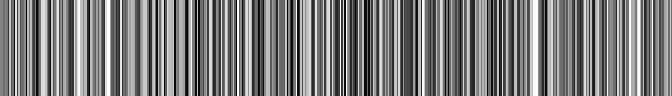

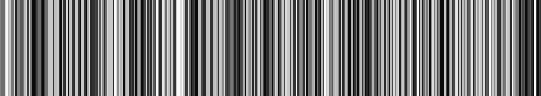

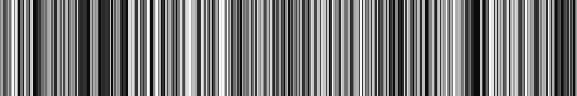

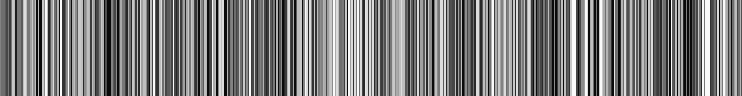

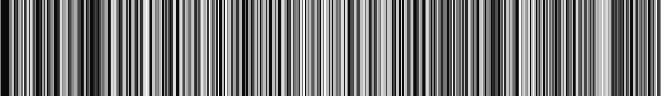

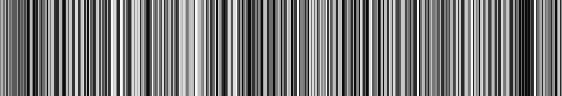

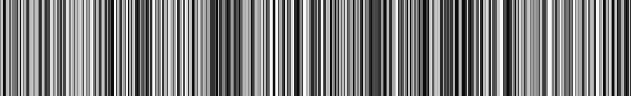

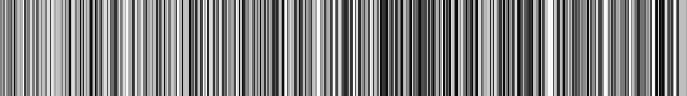

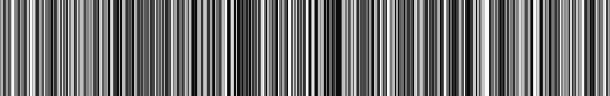

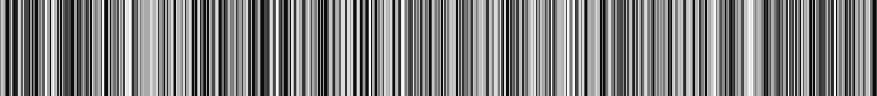

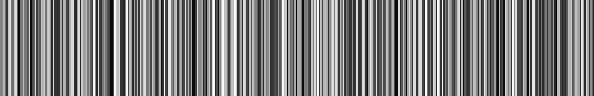

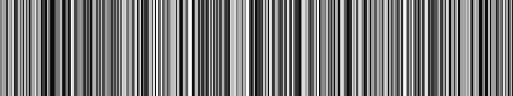

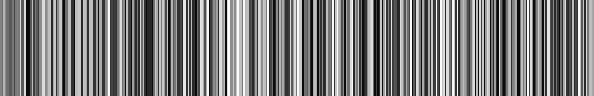

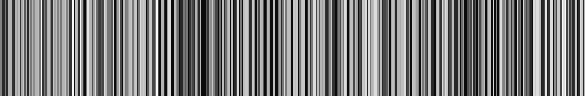

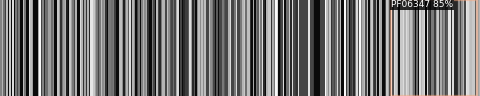

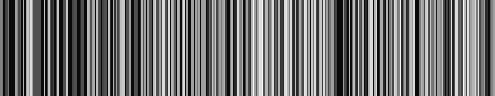

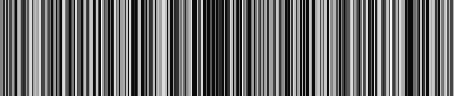

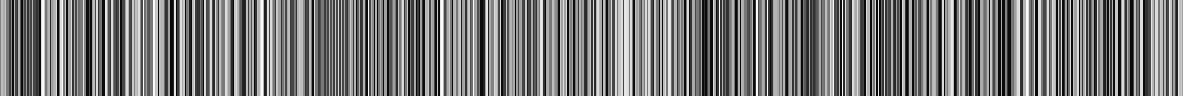

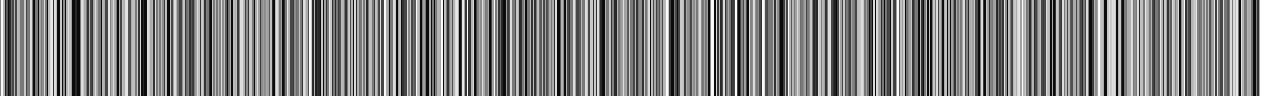

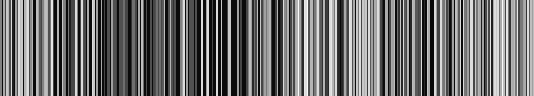

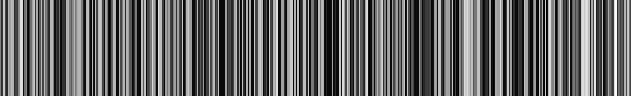

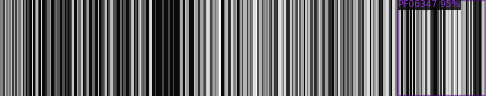

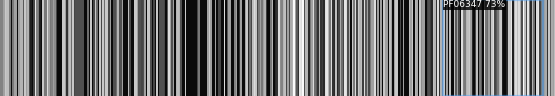

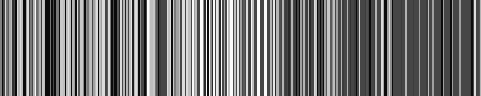

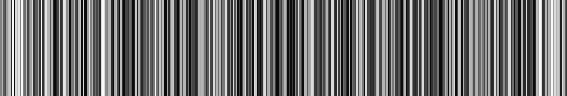

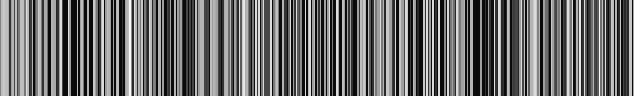

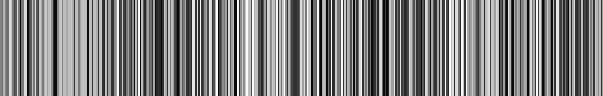

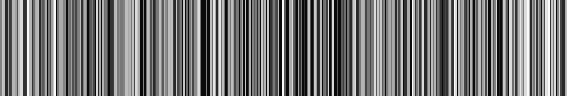

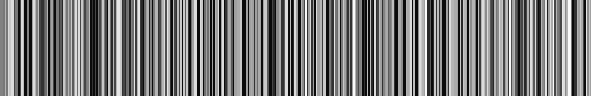

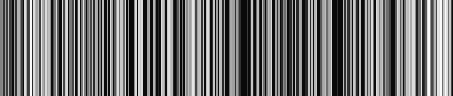

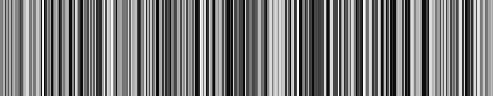

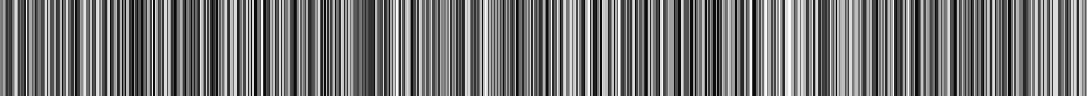

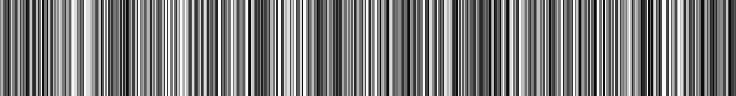

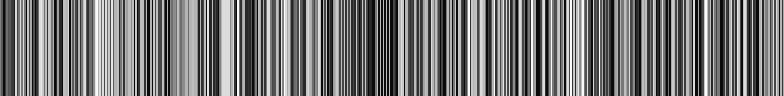

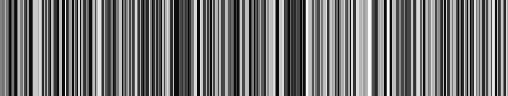

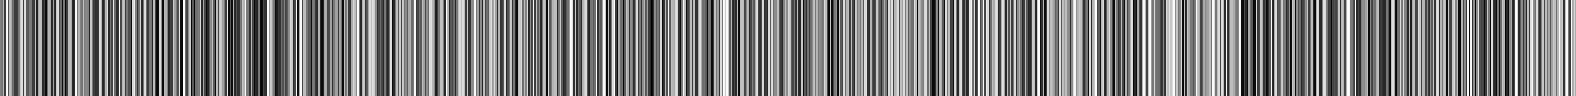

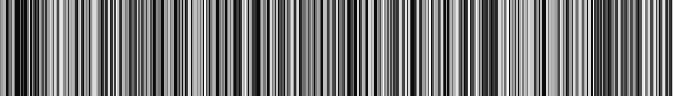

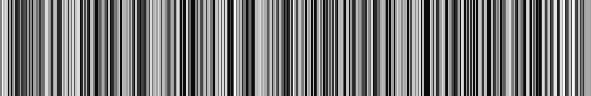

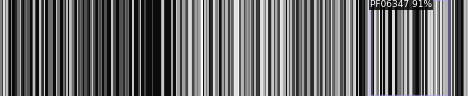

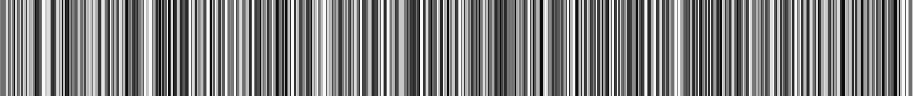

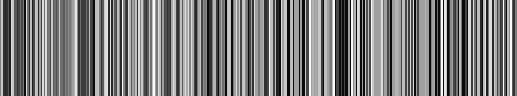

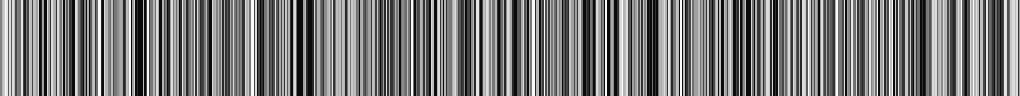

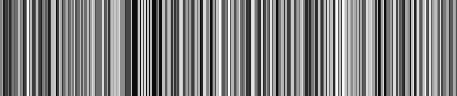

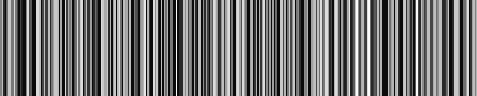

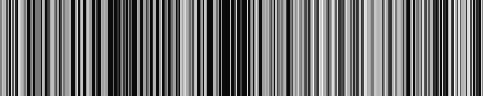

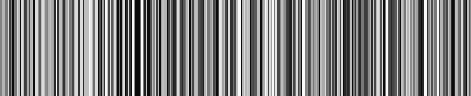

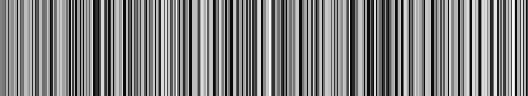

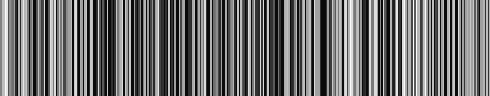

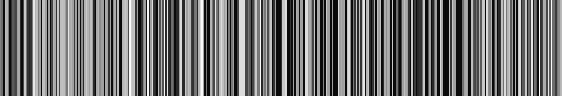

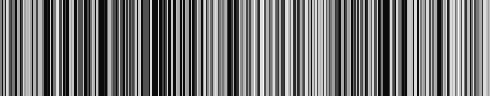

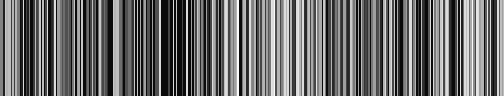

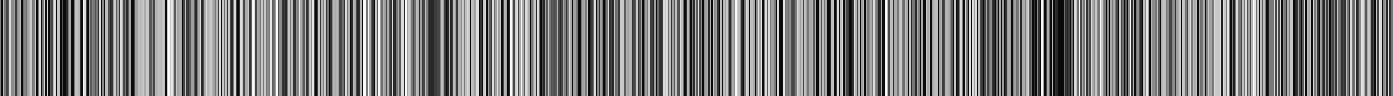

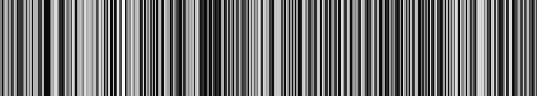

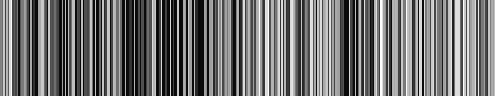

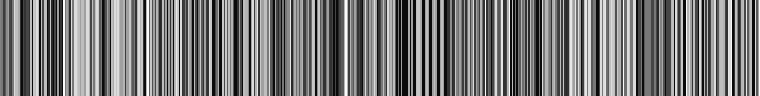

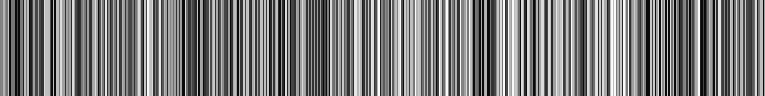

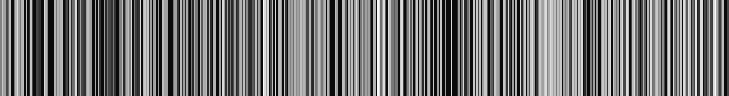

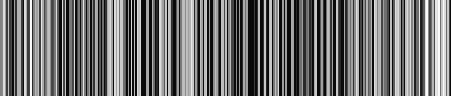

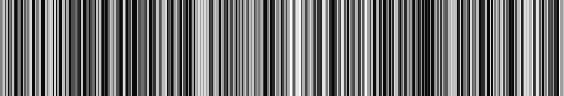

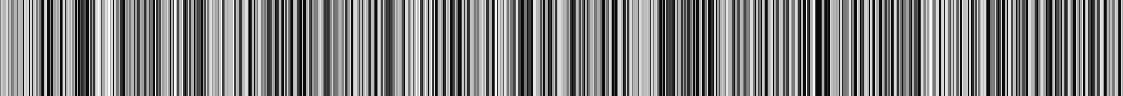

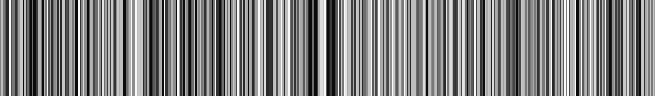

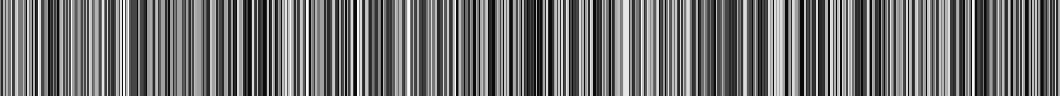

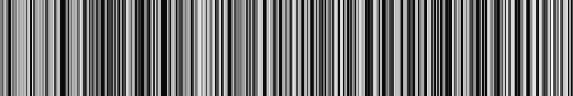

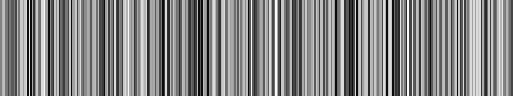

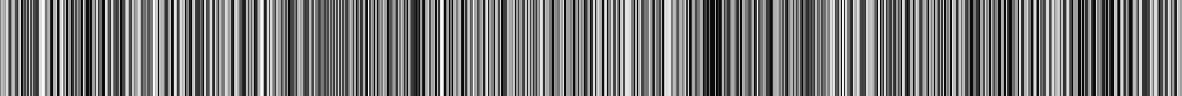

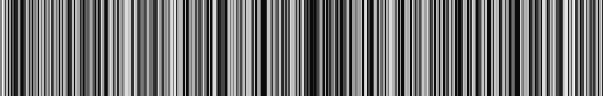

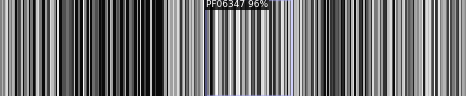

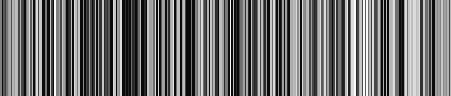

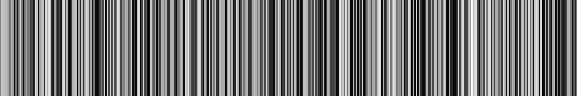

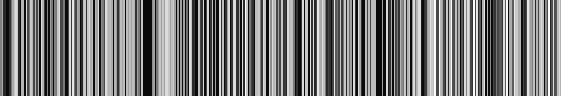

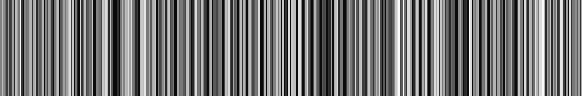

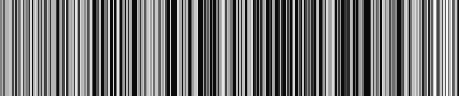

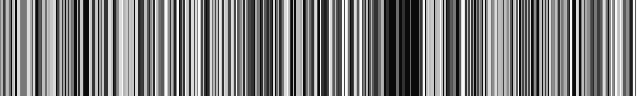

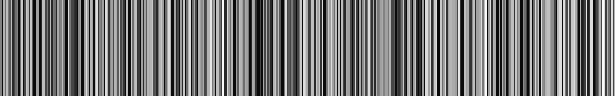

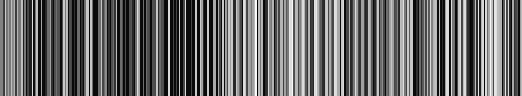

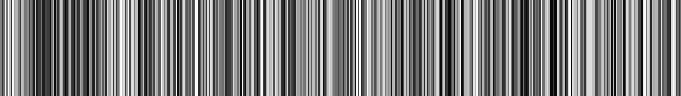

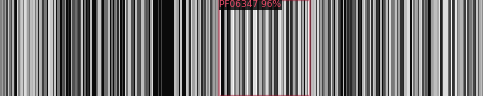

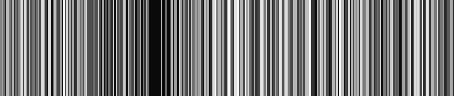

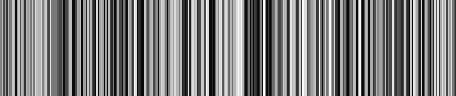

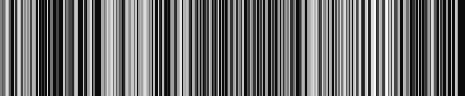

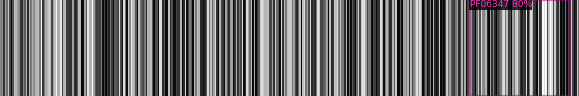

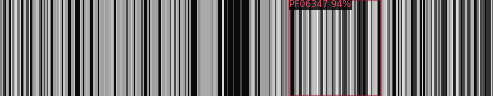

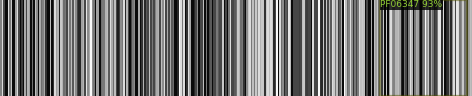

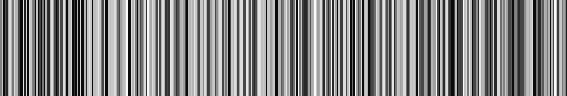

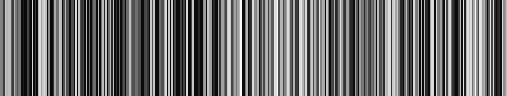

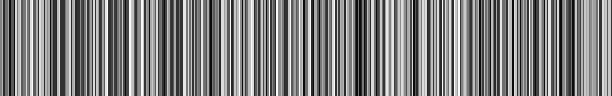

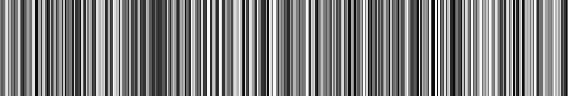

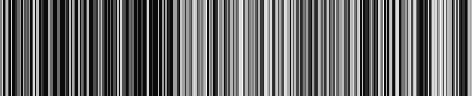

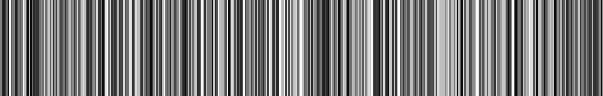

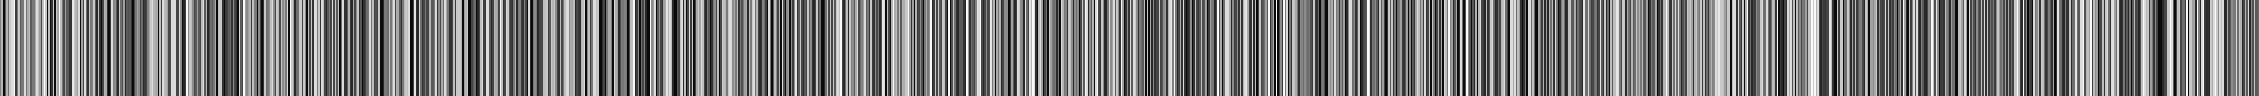

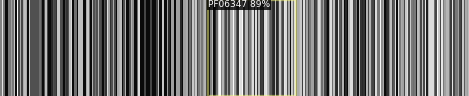

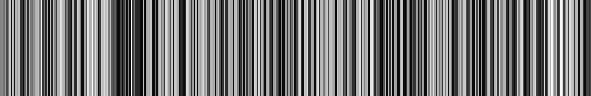

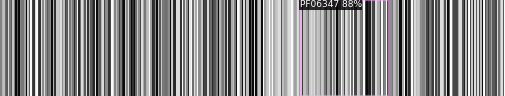

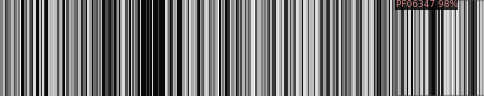

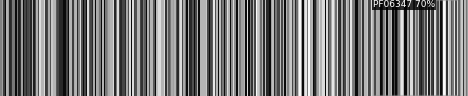

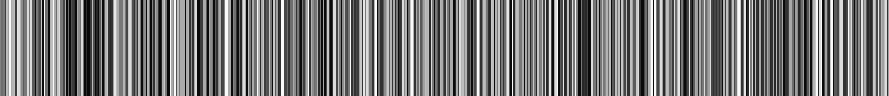

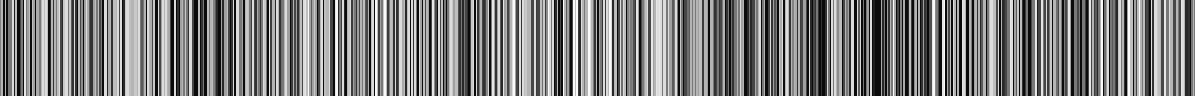

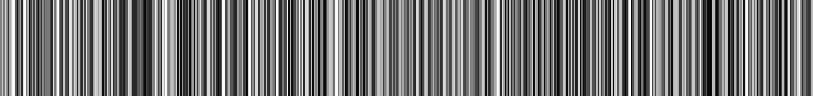

In [25]:
# test on samples bigger than 600
import string
from PIL import Image
grt_thn_600 = protein_domain_data[(protein_domain_data['Class']=='PF06347') & (protein_domain_data['SeqLen']>300)]
test_sequences = grt_thn_600['Sequence']
color_map = {}
index = 0
for amino_acid in string.ascii_uppercase:
    color_map[amino_acid] = (index+10, index+10, index+10)
    index = index+10
def create_protein_seq_image(sequence, img_name, color_map=color_map):
    """
    Create an image from a sequence
    """
    sequence
    image = np.full((img_h, len(sequence),3), (500,500,500))
    for index in range(len(sequence)):
        image[:, index, :] = color_map[sequence[index]]
    pil_image = Image.fromarray(image.astype(np.uint8))
#     assert pil_image.size == (img_w, img_h), f"{pil_image.size}!=({img_w},{img_h})"
    pil_image.save(img_name)
    
count=0
for index,seq in enumerate(test_sequences):
    img_pth = Path('/tmp/{index}.png')
    create_protein_seq_image(seq, img_pth)
    im = cv2.imread(str(img_pth))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train").set(thing_classes = classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    try:
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        if len(outputs['instances'].get_fields()['pred_classes'])==0:
            count+=1
        cv2_imshow(out.get_image()[:, :, ::-1])
    except: 
        pass

In [24]:
outputs

NameError: name 'outputs' is not defined

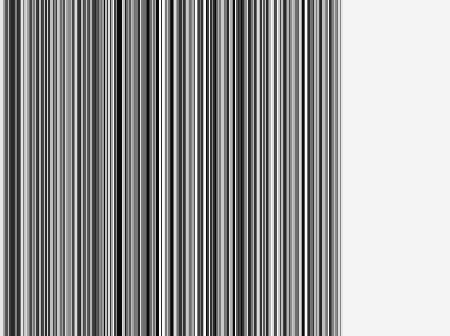

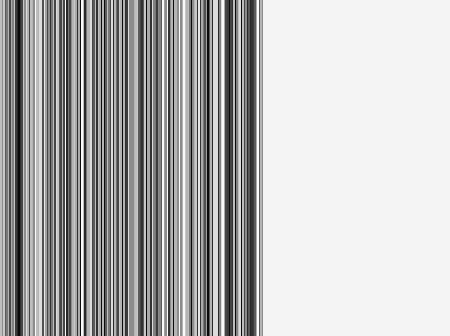

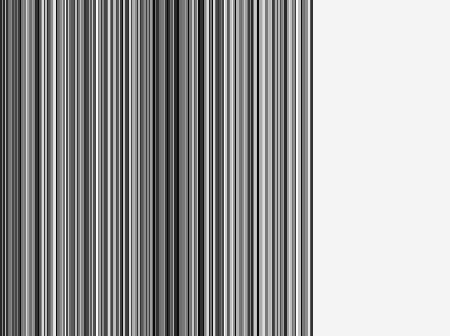

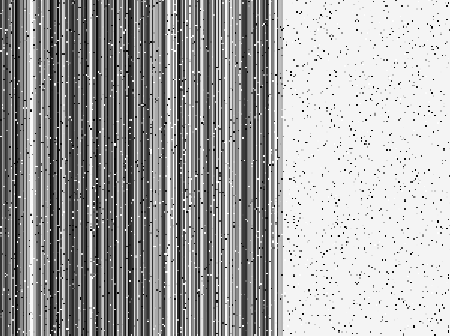

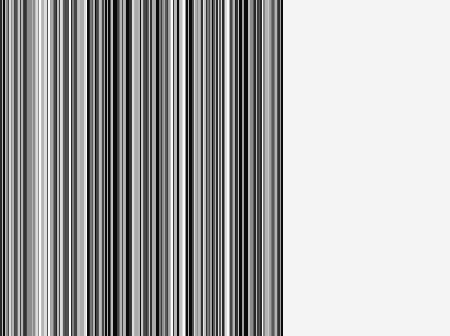

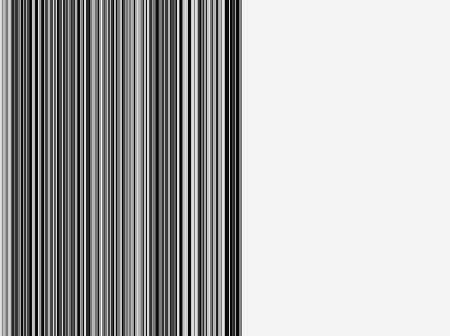

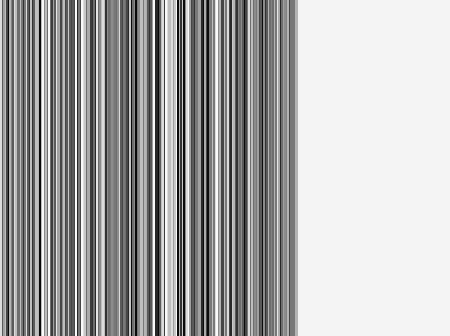

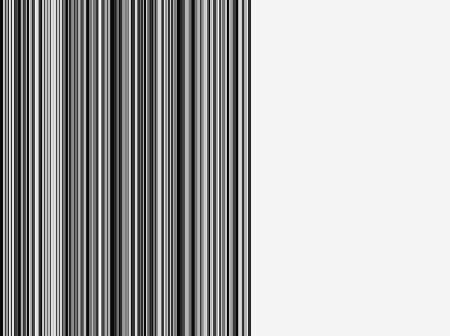

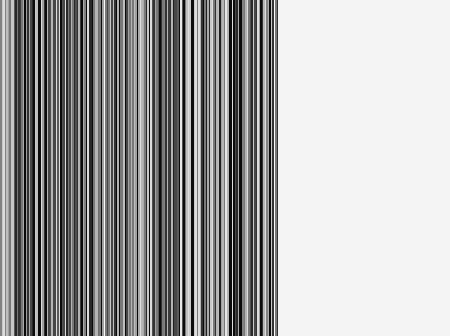

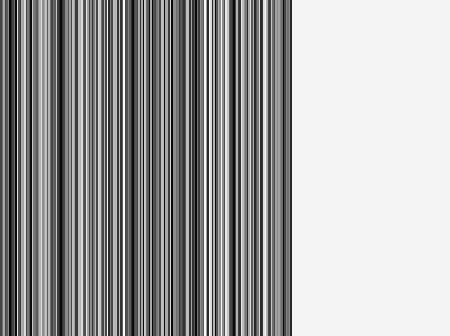

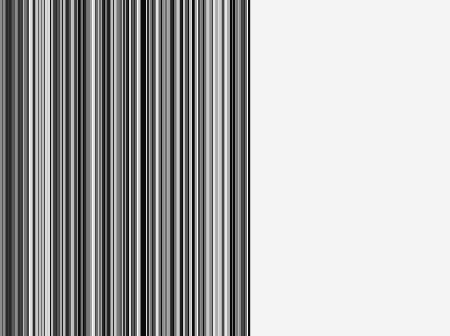

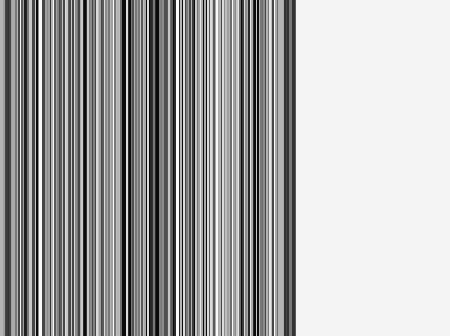

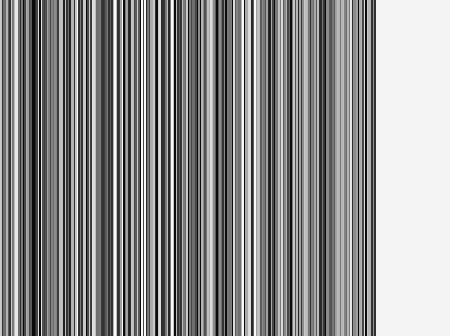

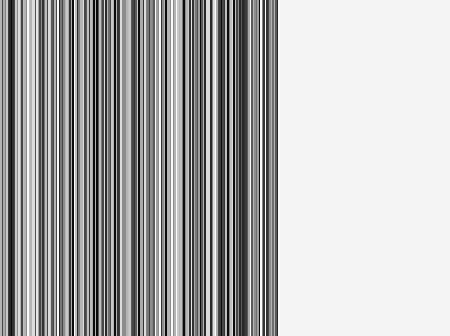

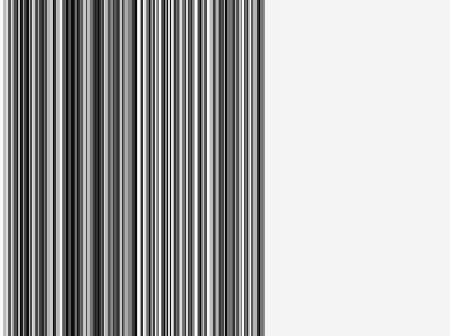

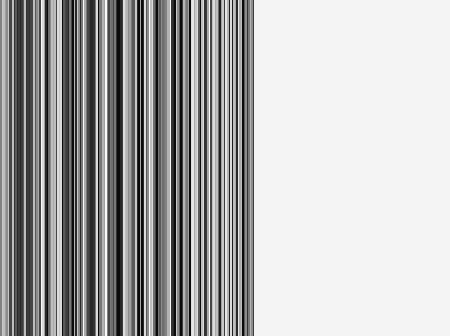

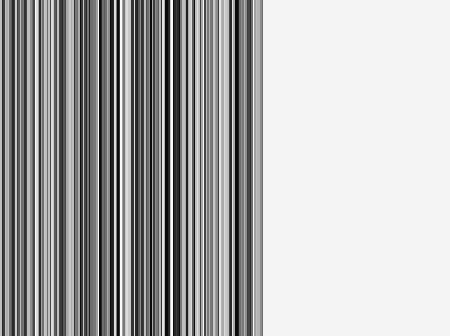

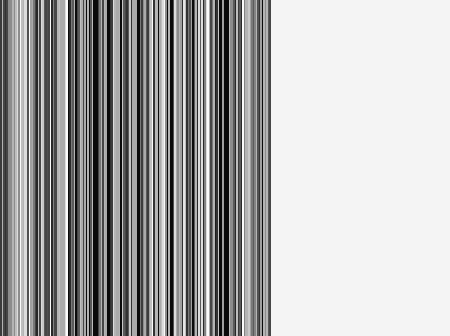

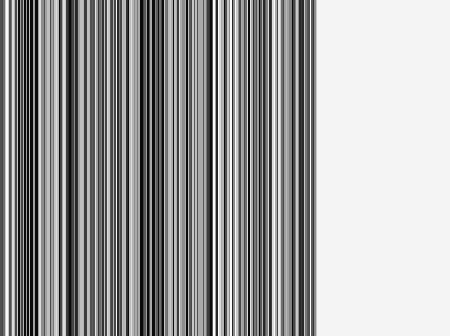

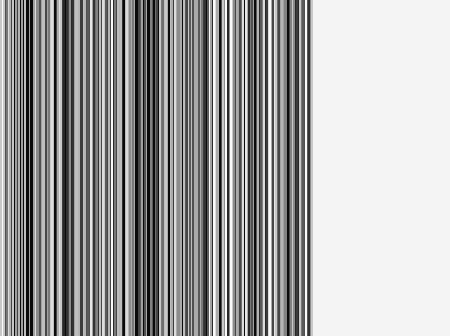

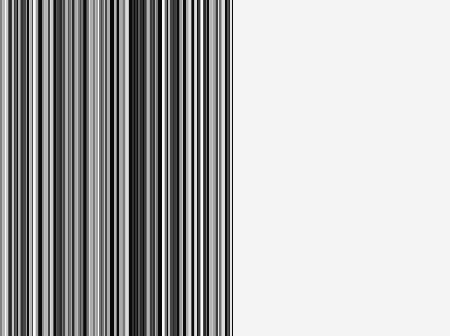

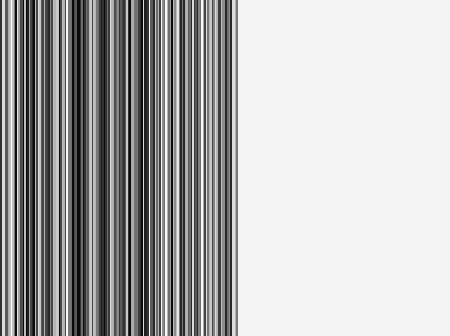

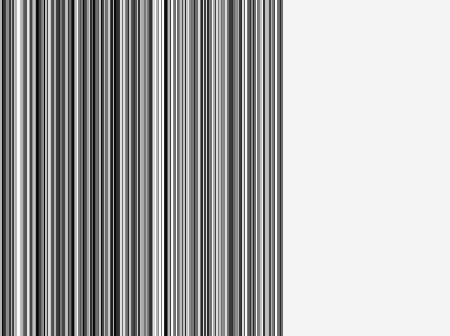

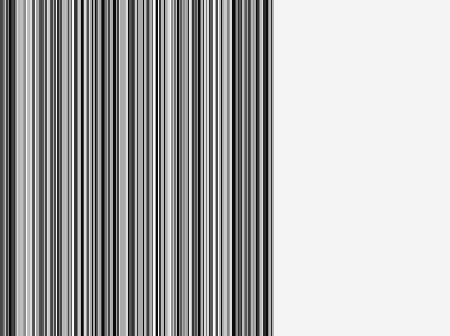

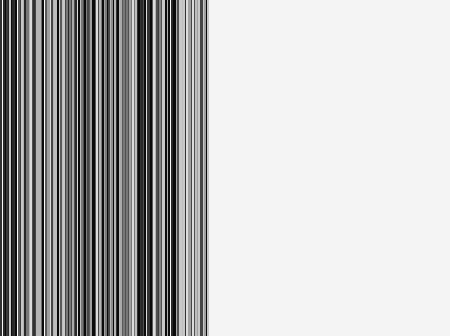

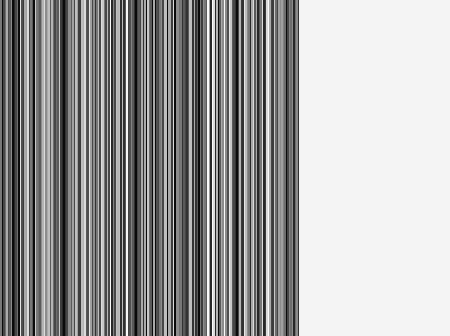

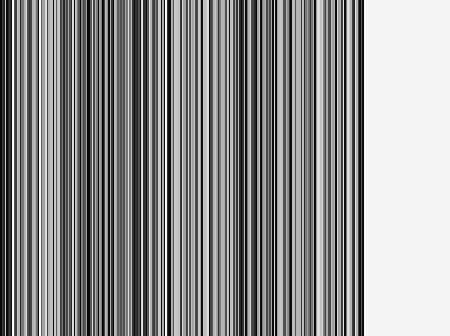

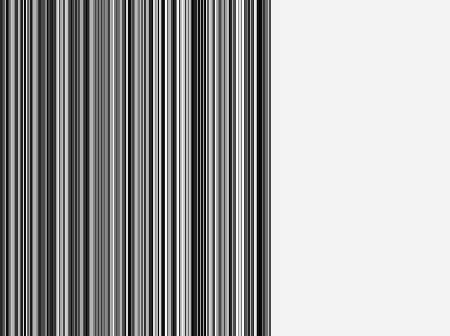

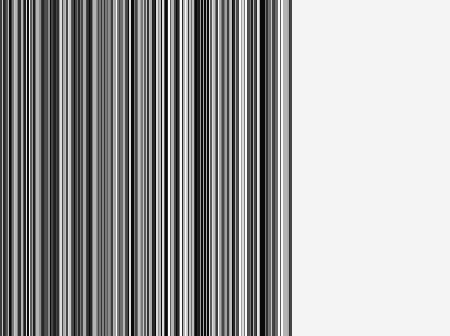

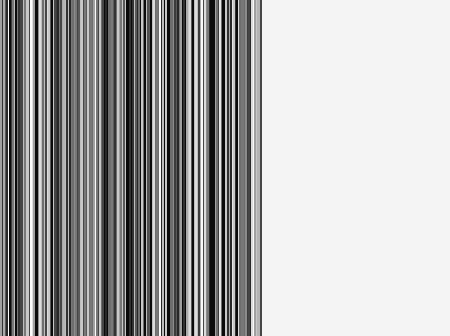

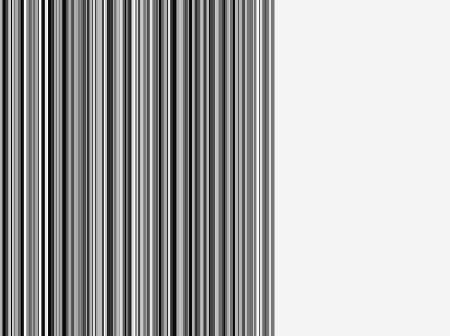

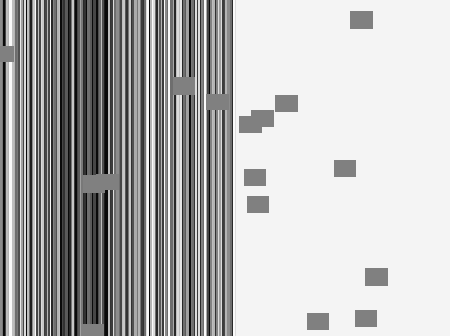

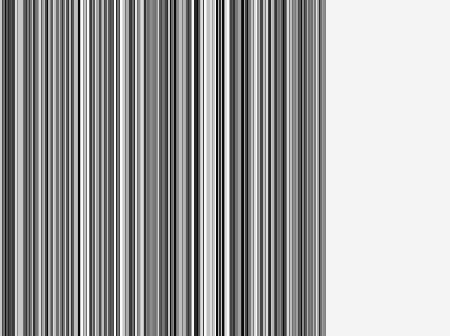

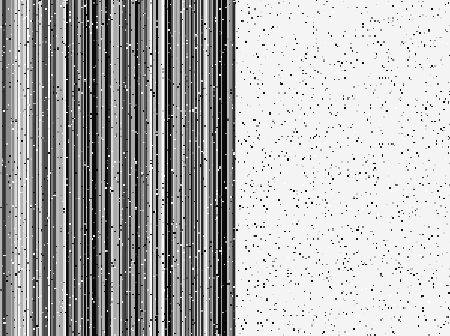

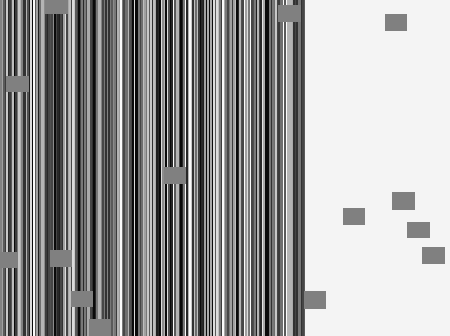

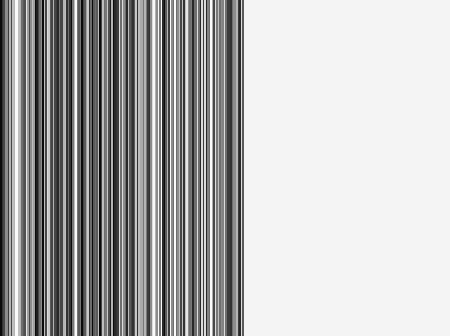

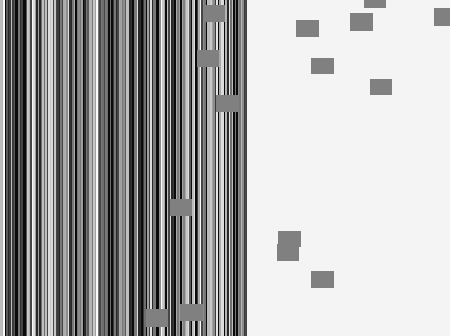

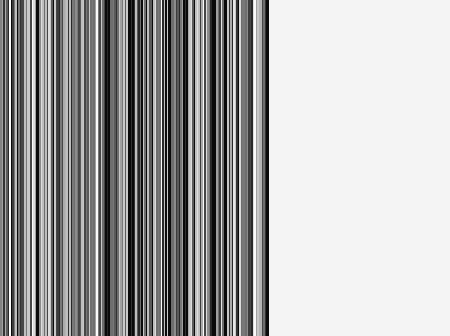

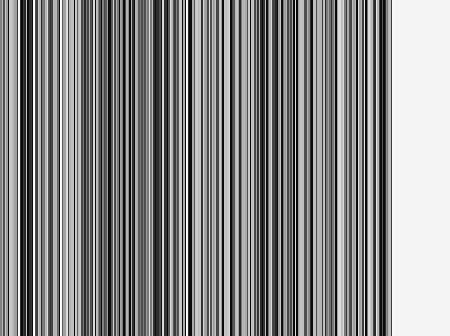

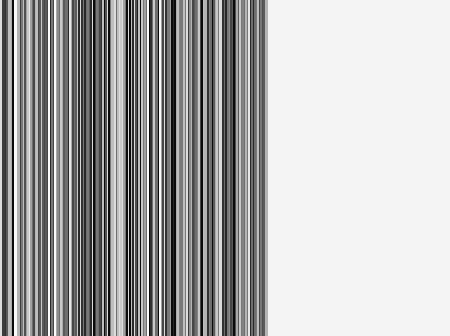

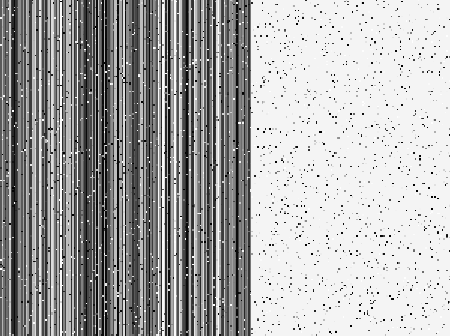

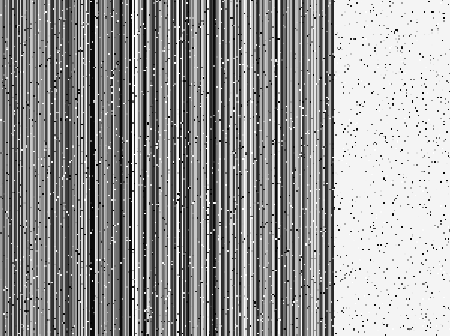

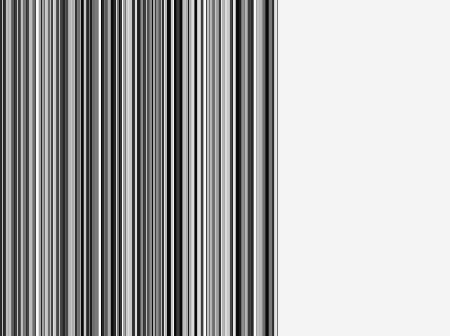

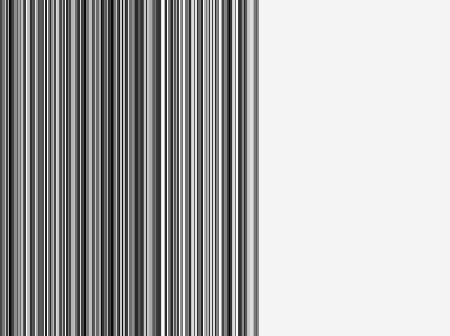

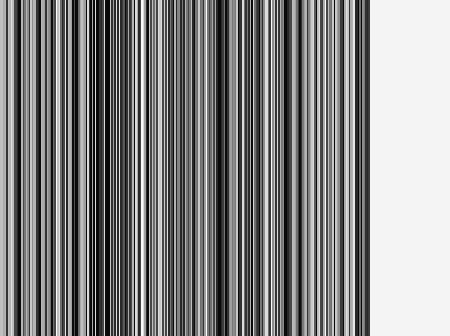

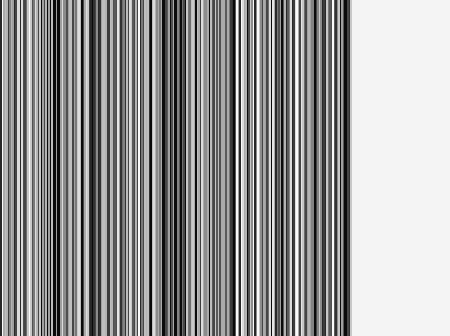

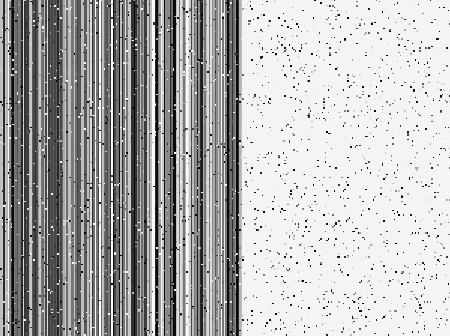

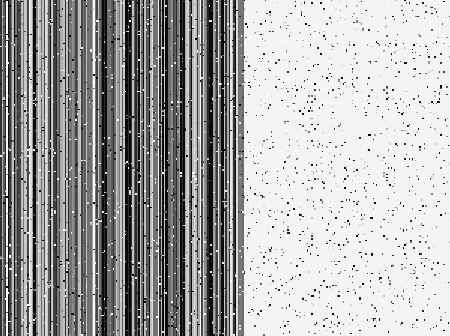

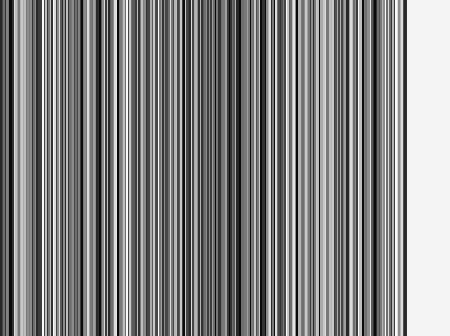

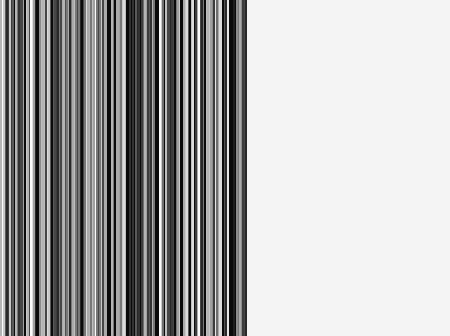

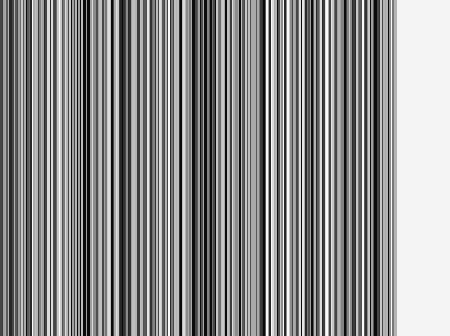

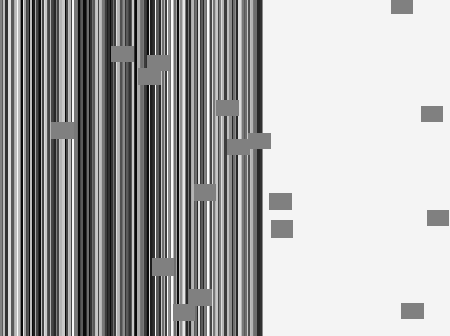

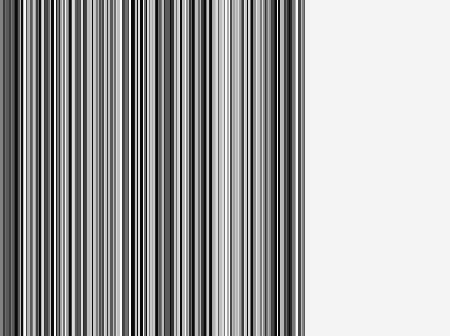

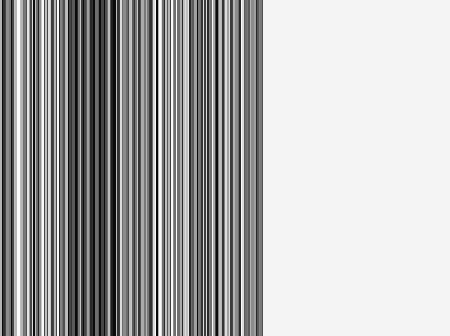

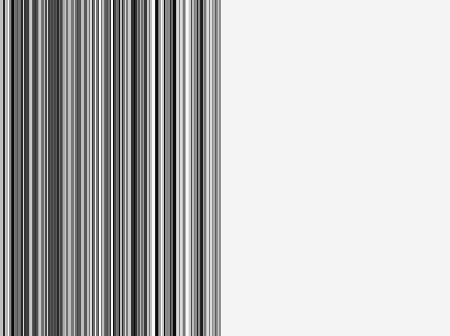

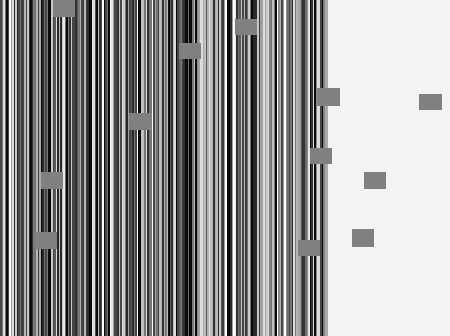

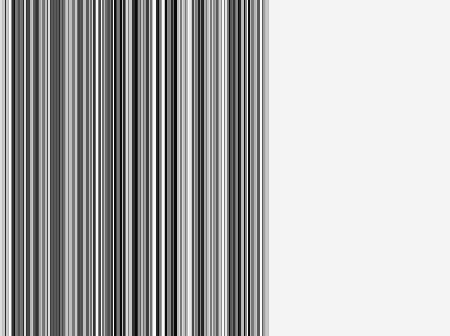

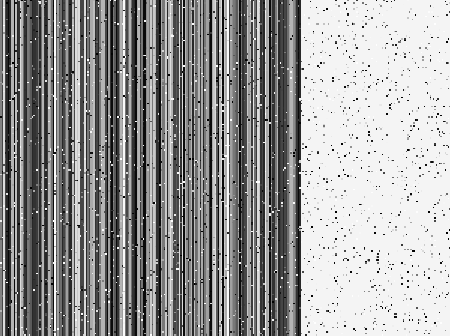

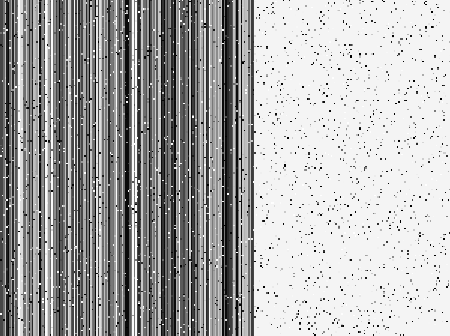

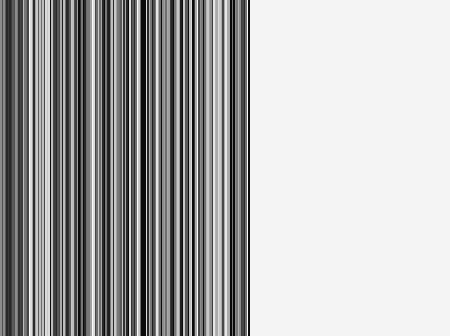

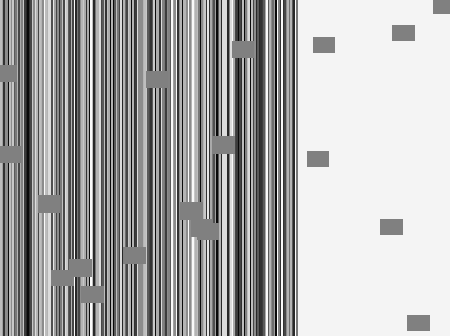

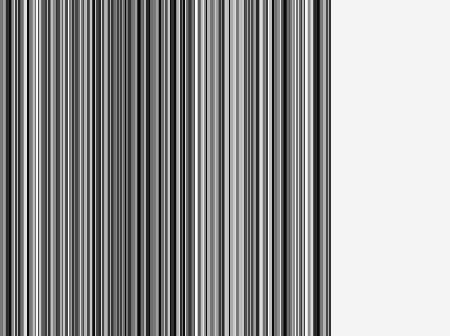

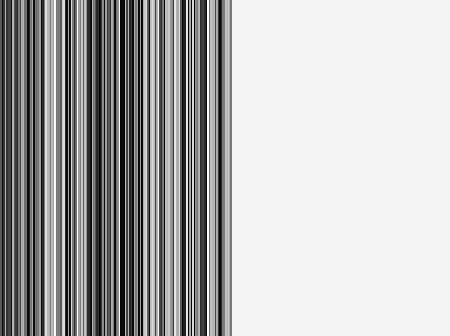

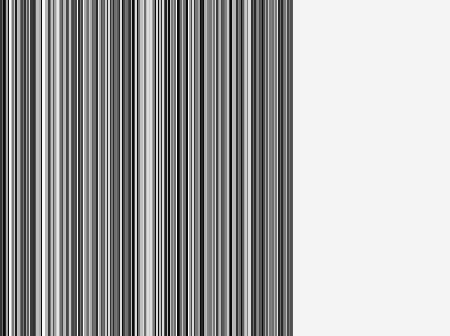

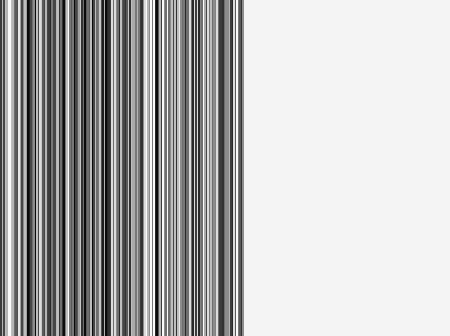

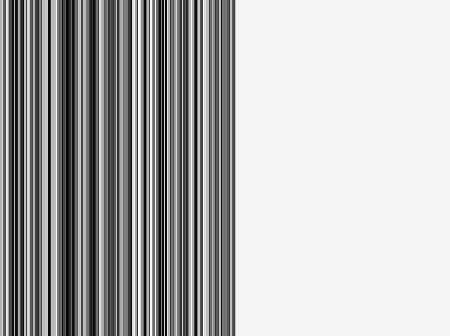

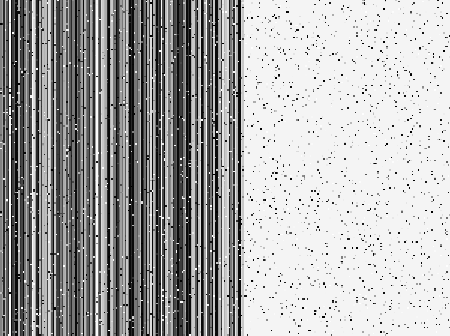

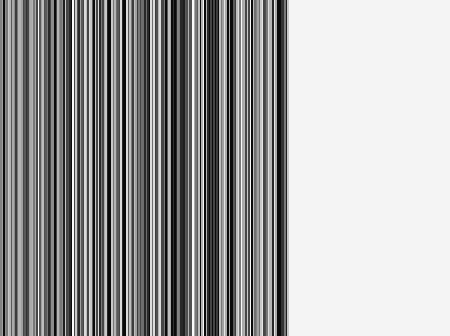

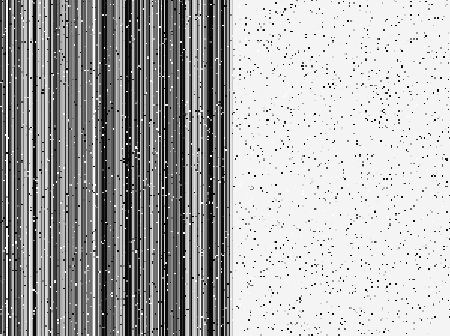

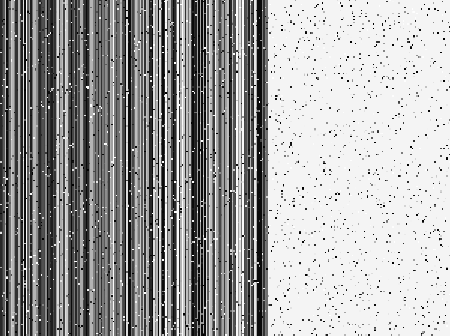

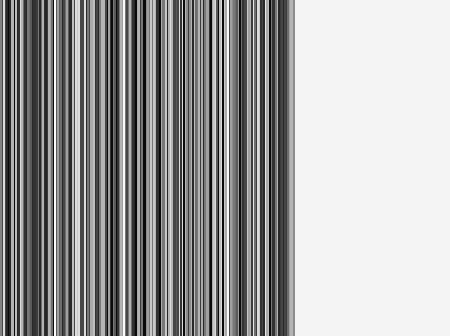

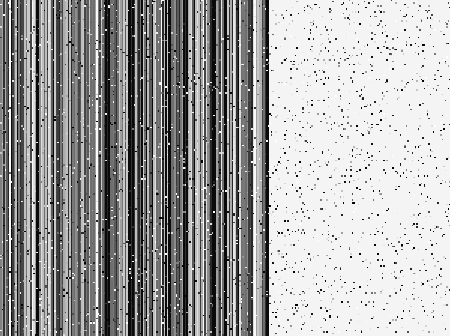

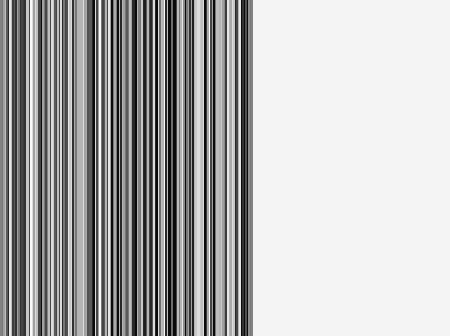

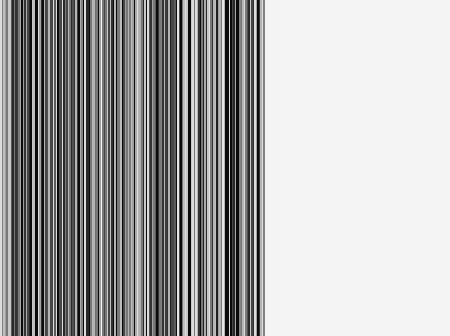

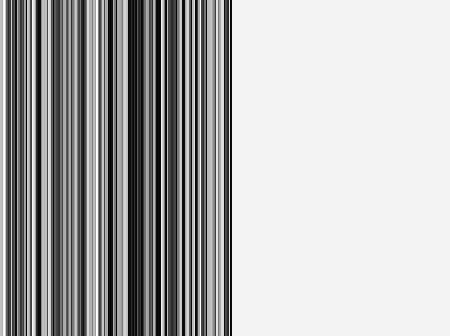

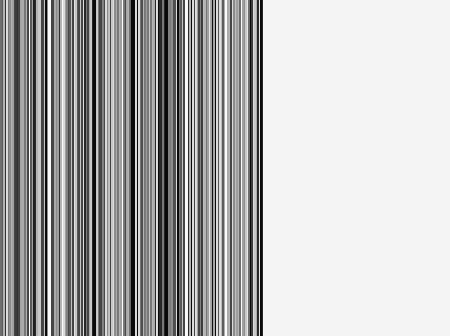

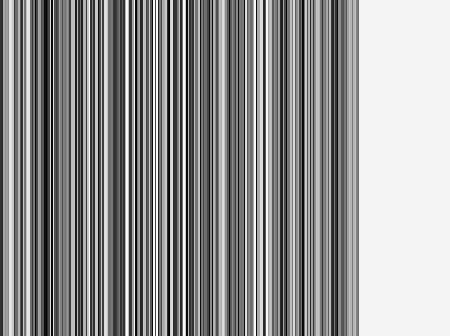

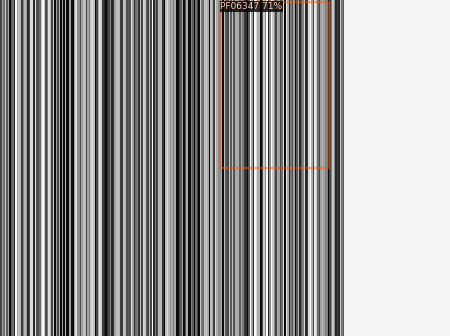

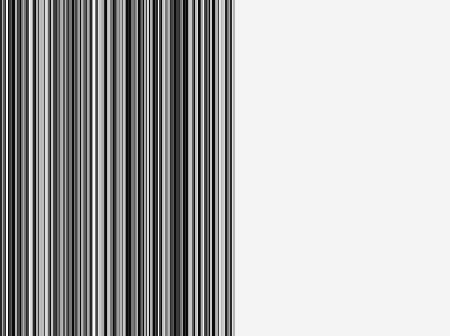

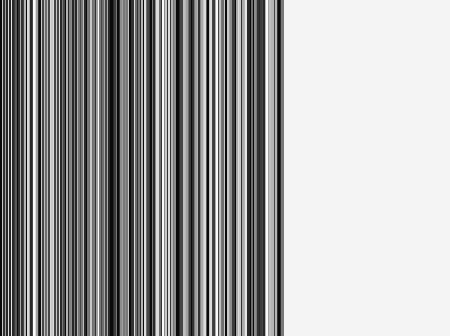

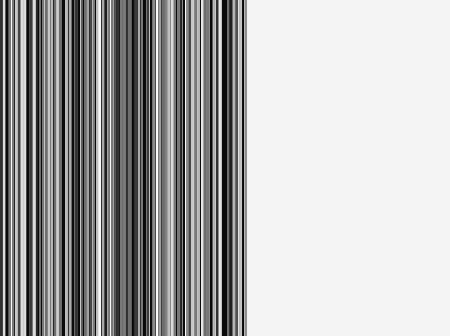

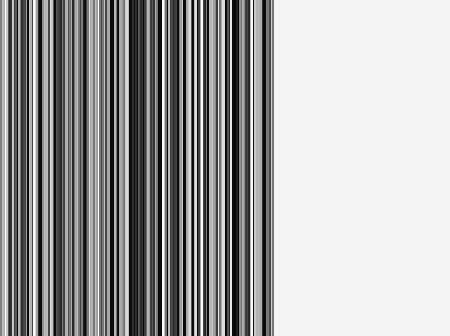

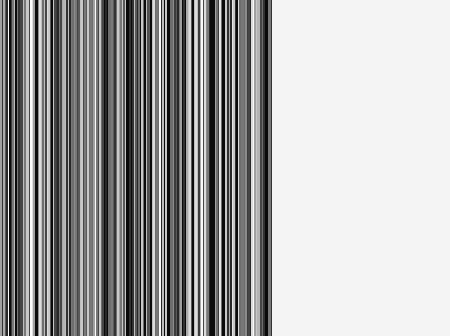

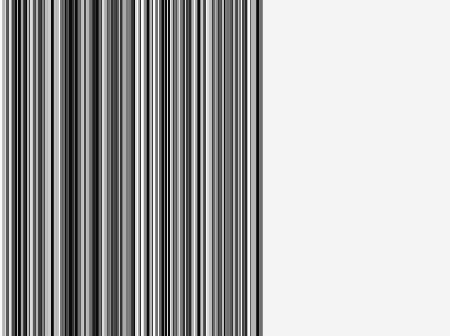

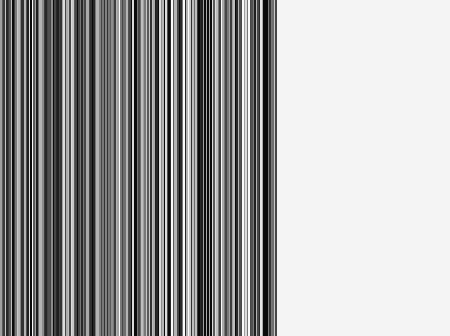

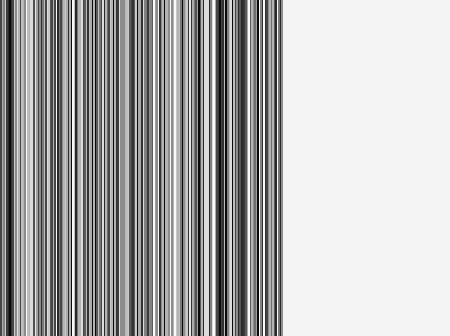

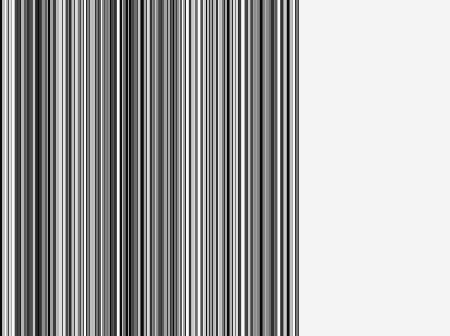

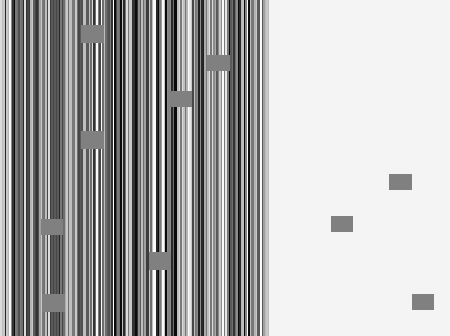

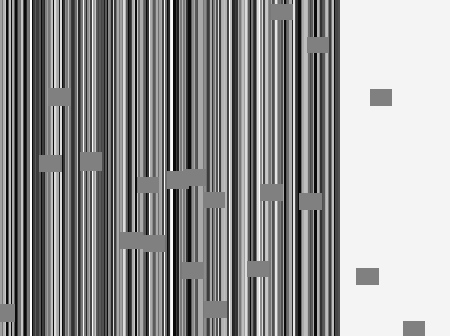

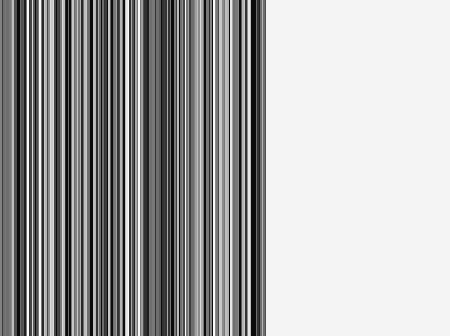

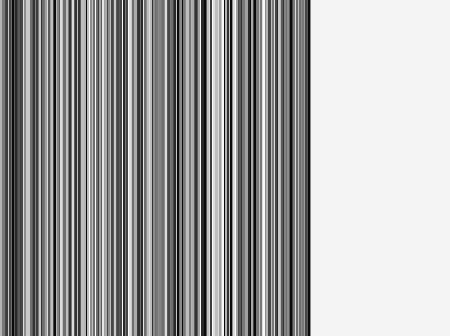

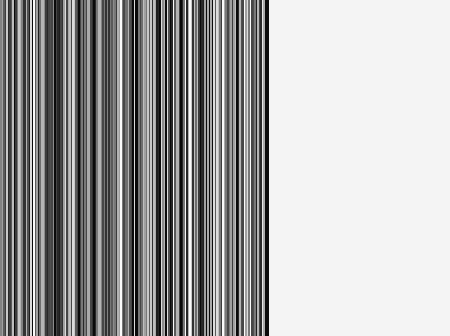

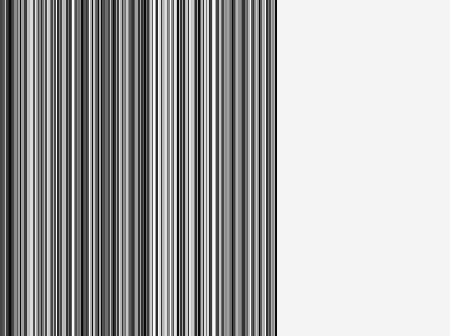

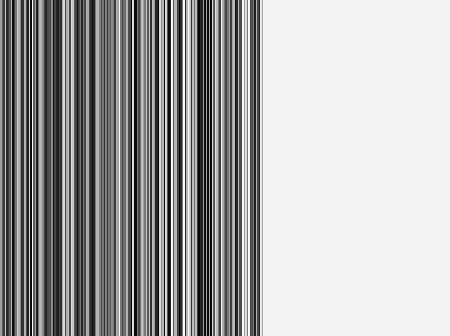

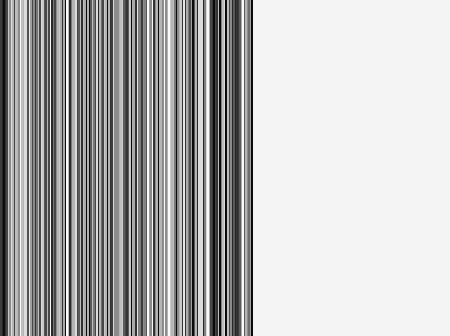

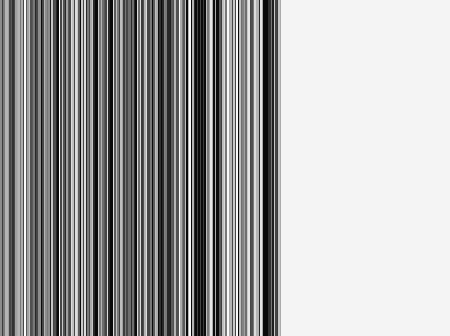

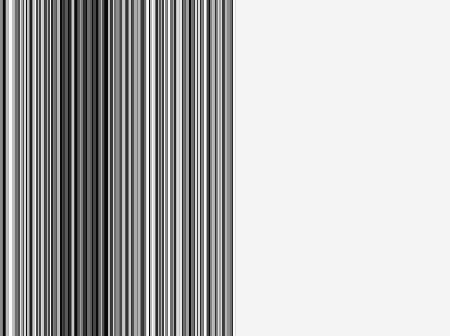

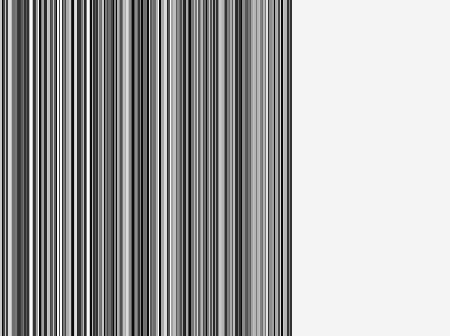

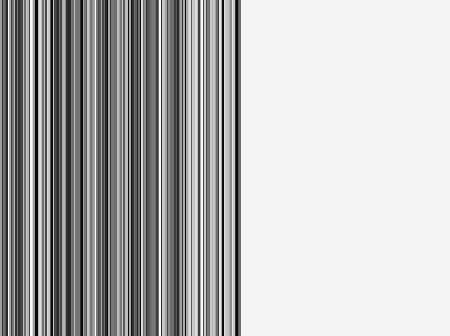

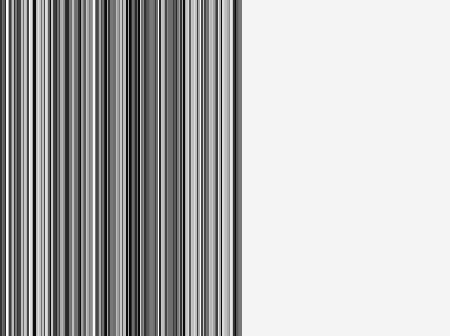

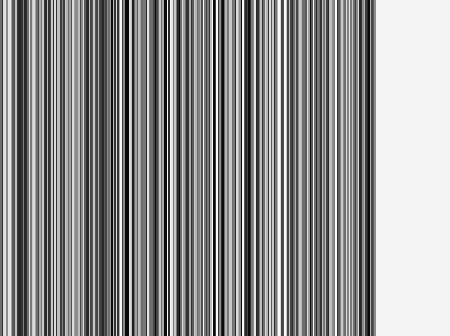

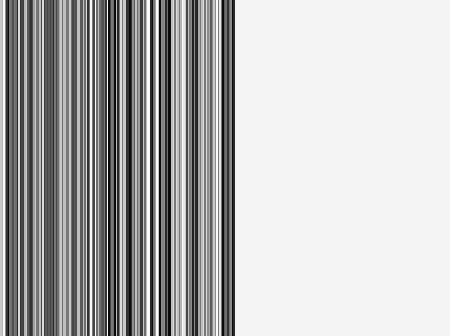

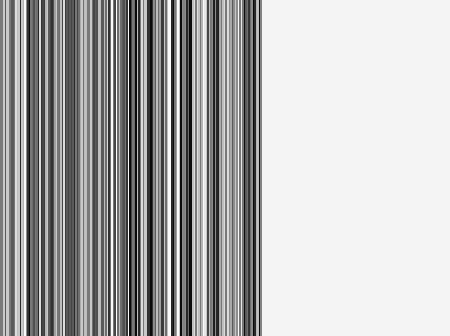

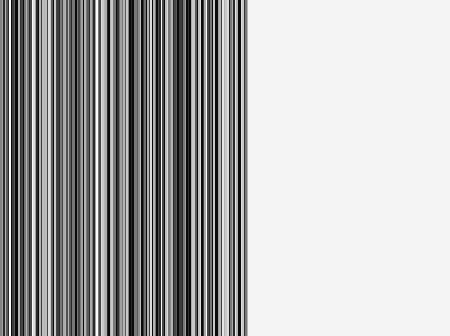

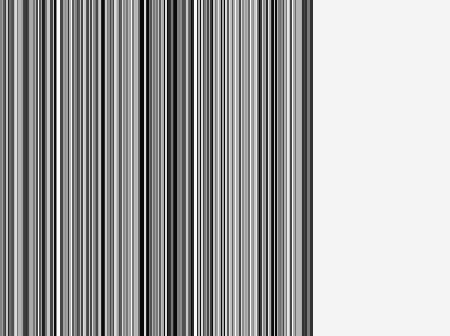

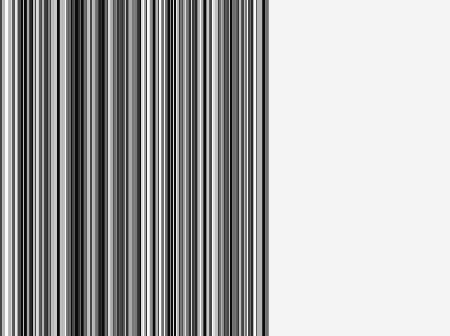

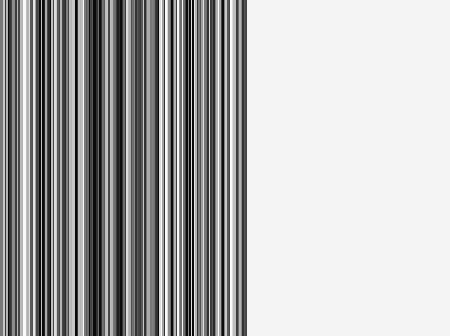

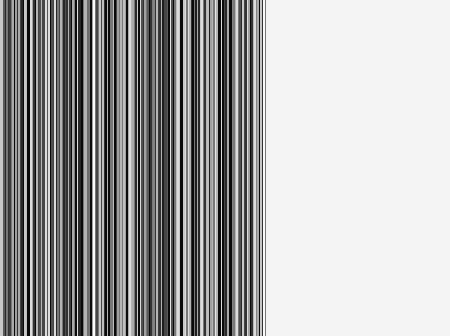

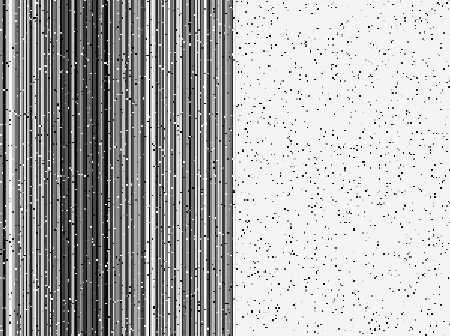

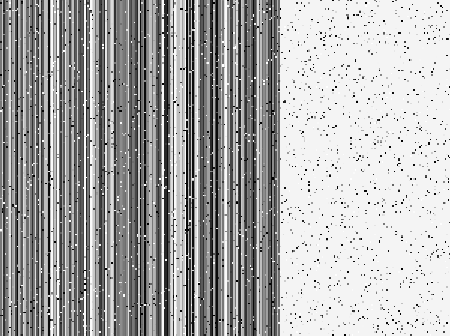

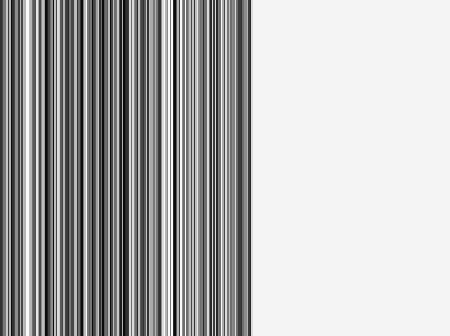

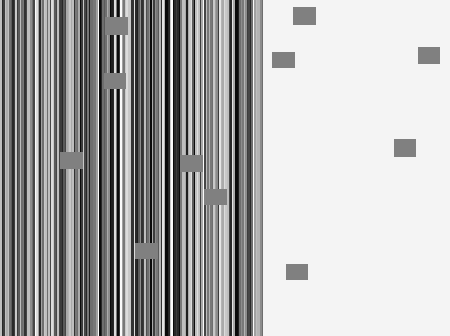

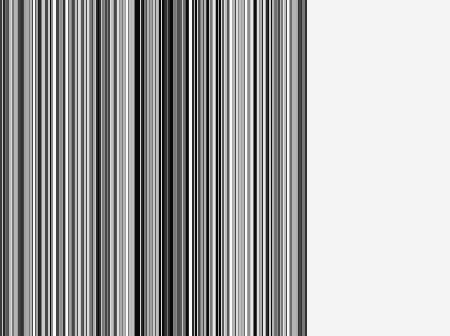

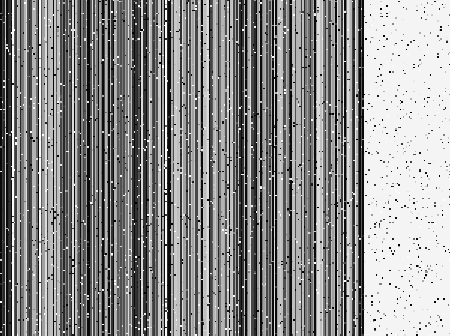

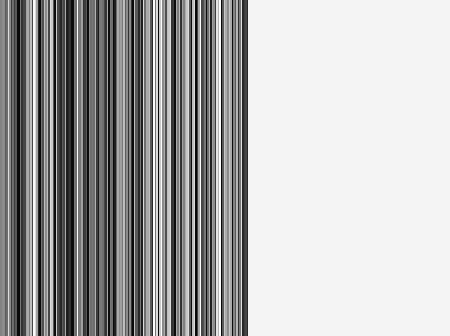

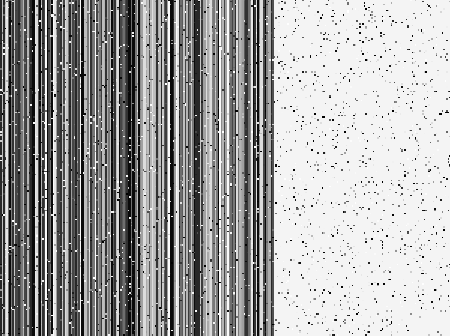

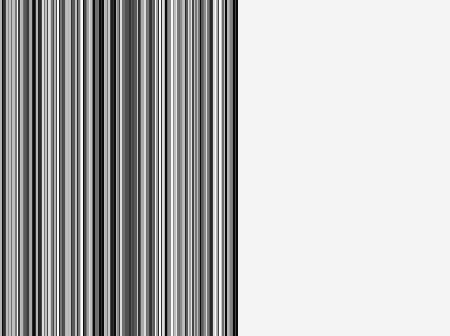

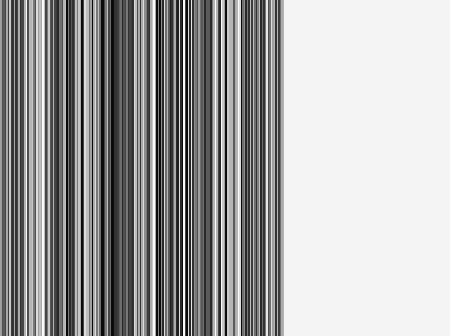

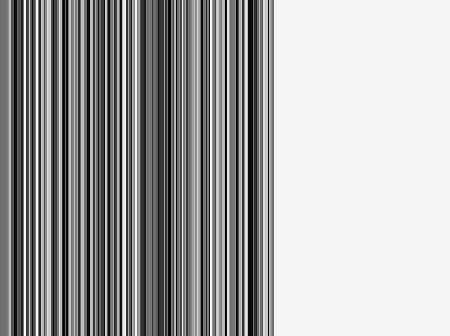

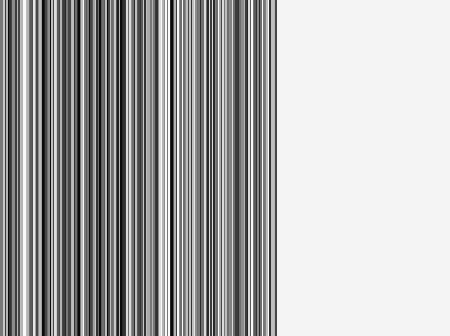

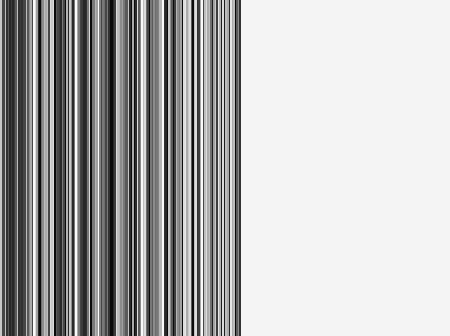

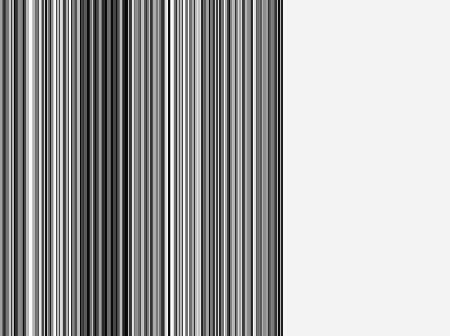

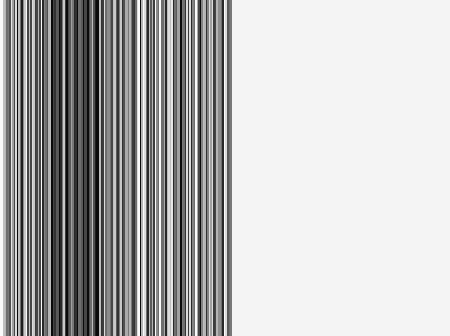

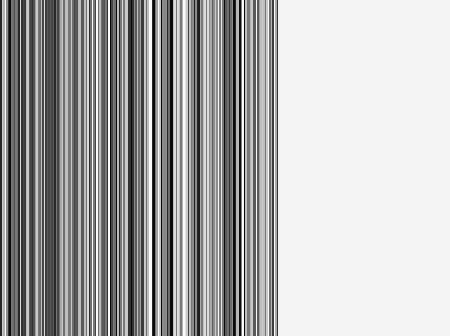

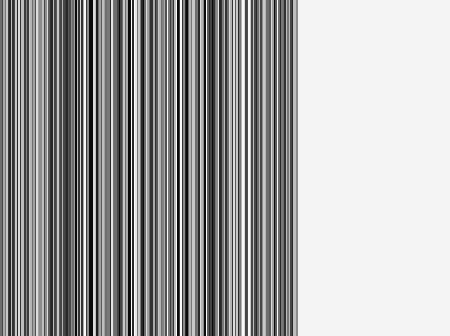

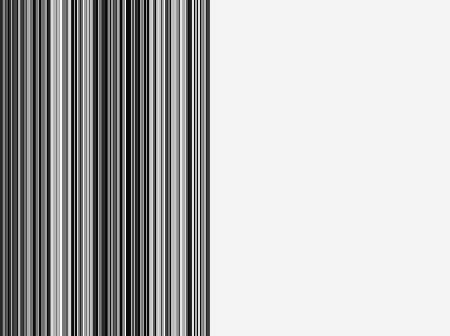

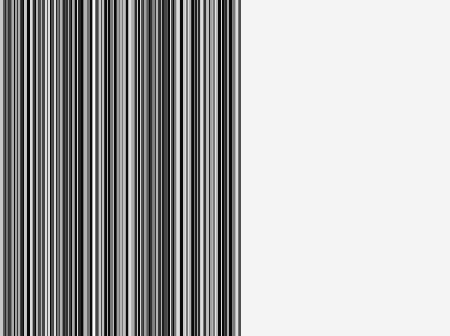

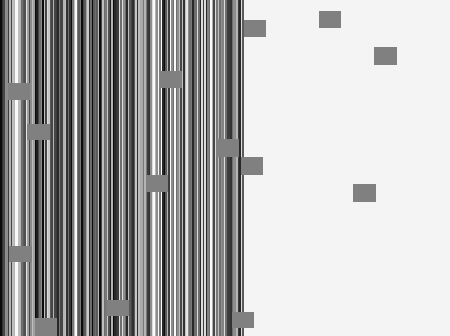

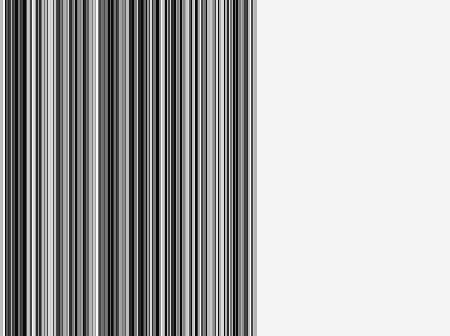

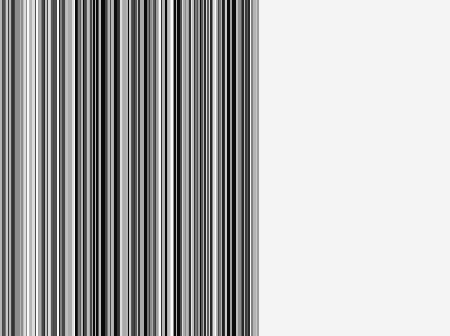

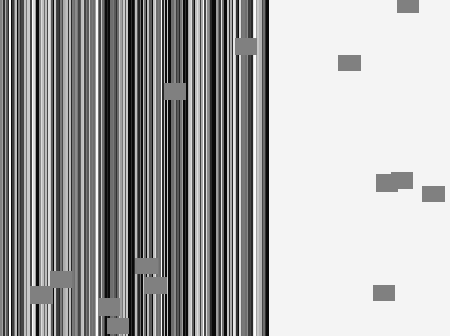

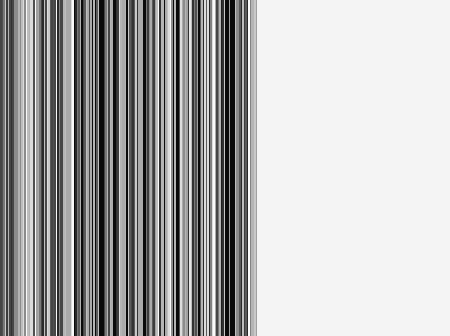

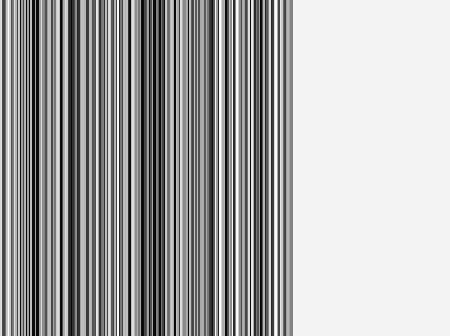

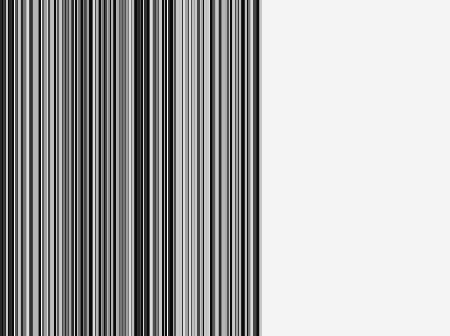

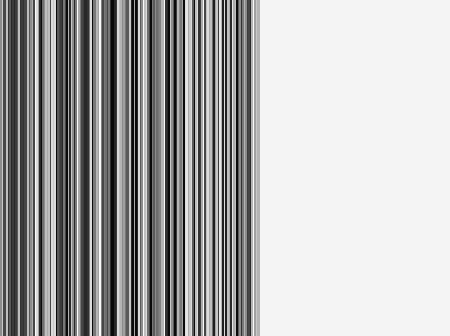

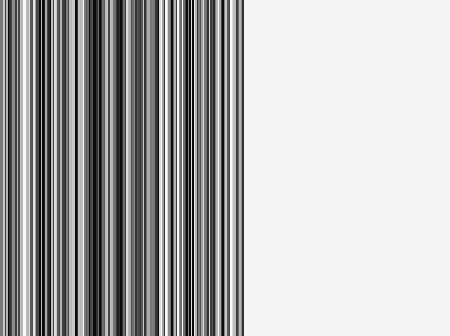

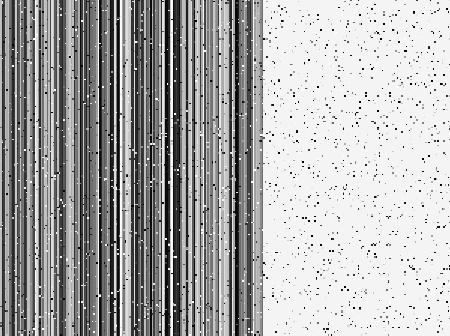

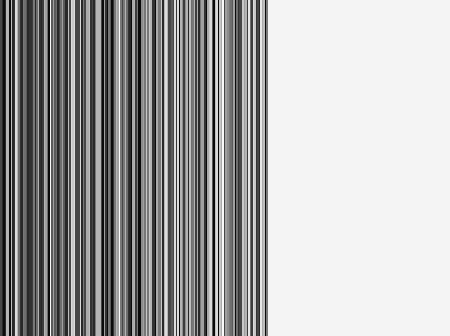

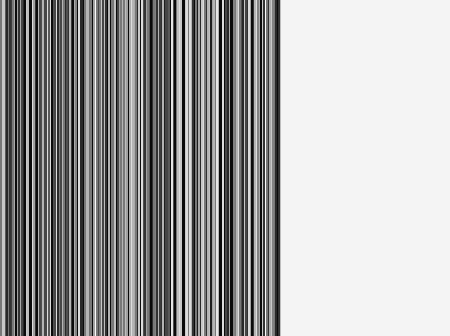

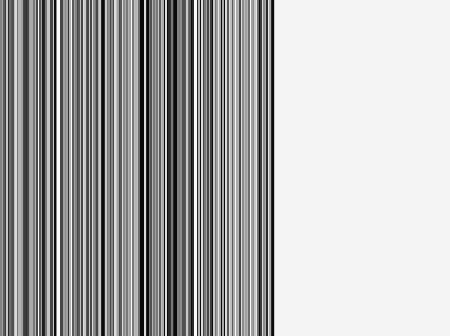

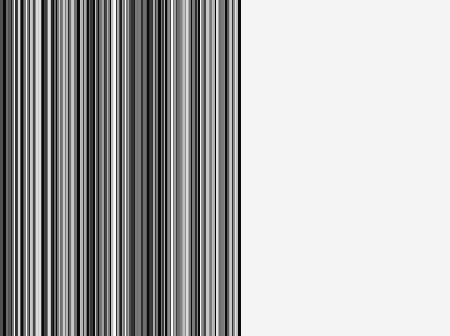

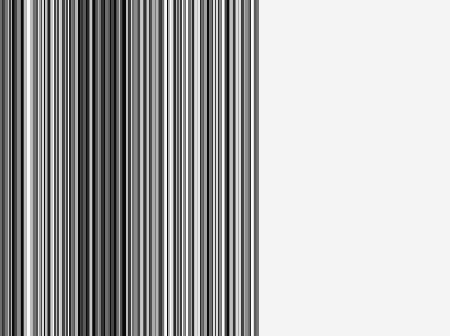

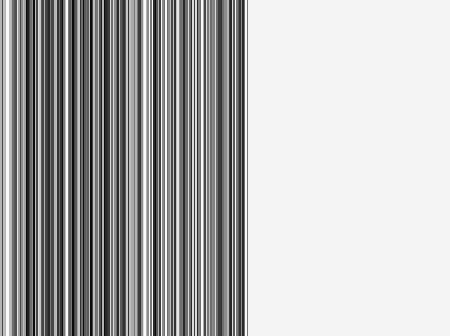

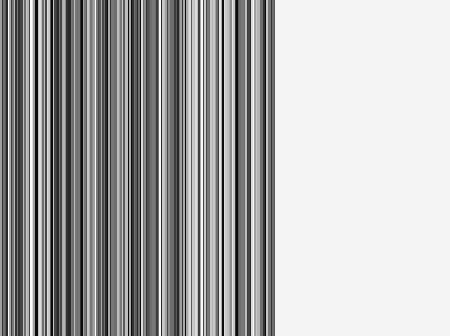

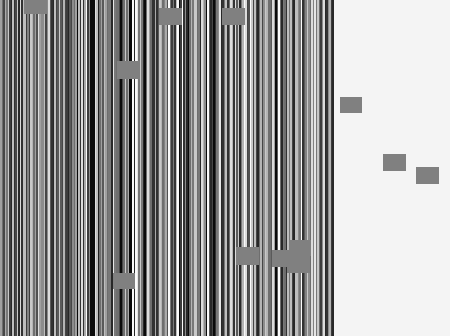

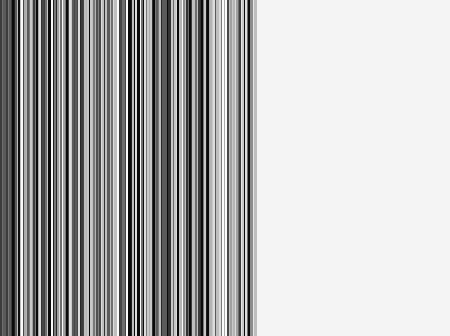

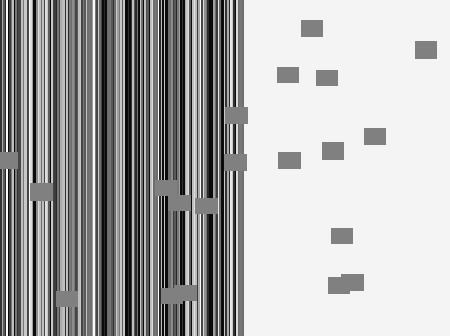

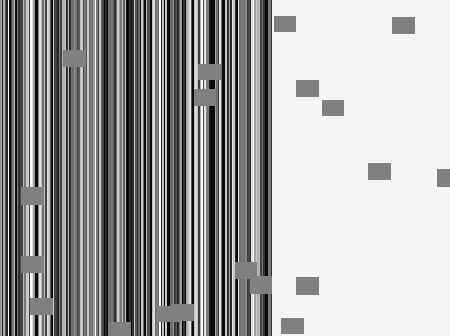

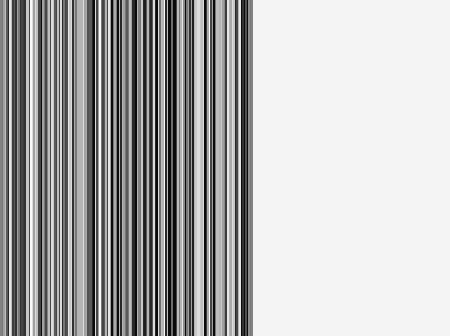

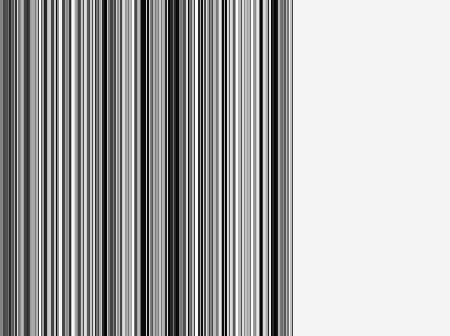

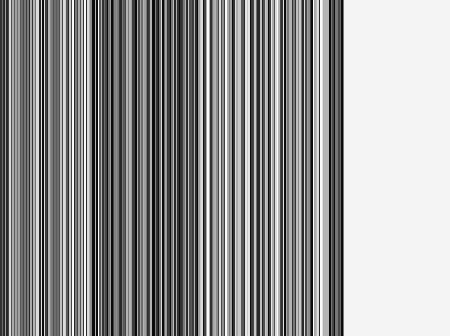

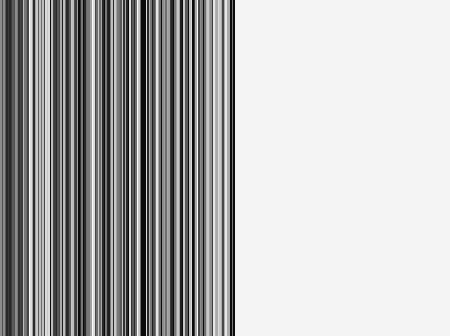

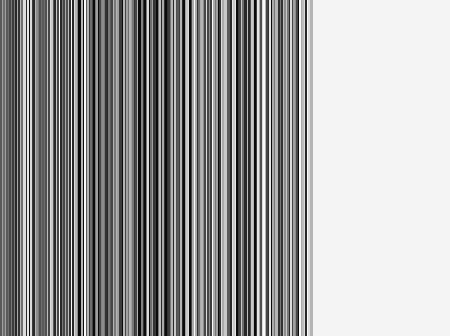

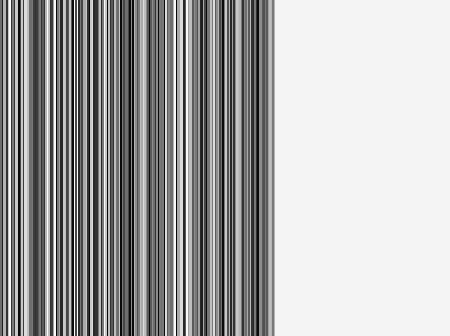

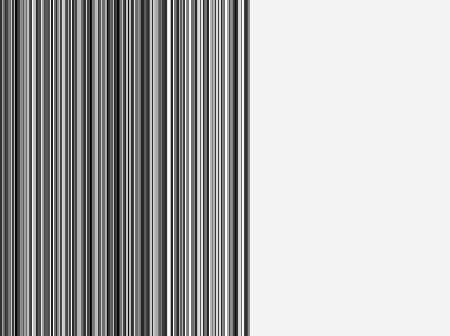

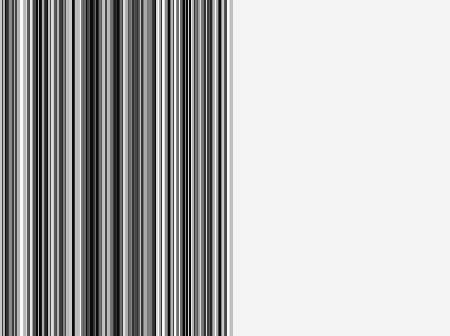

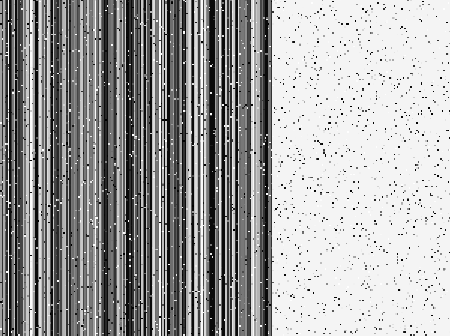

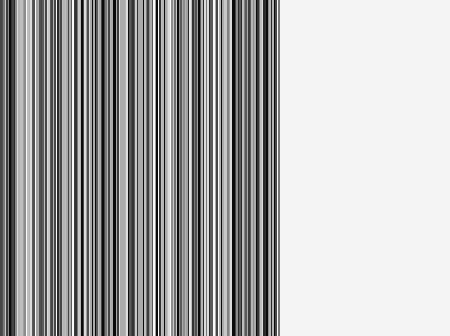

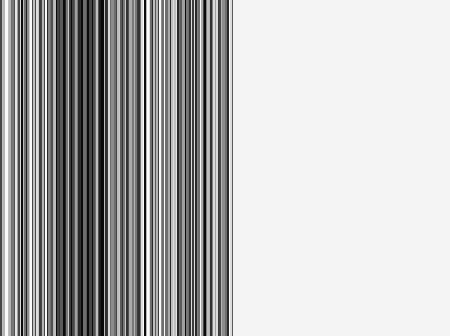

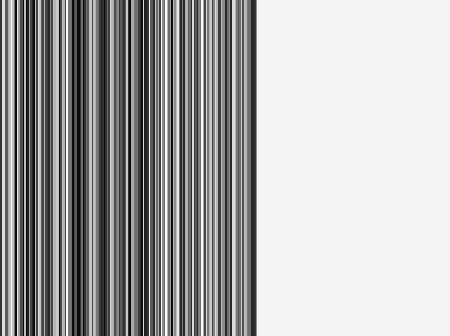

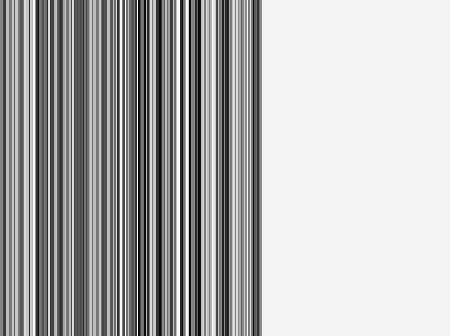

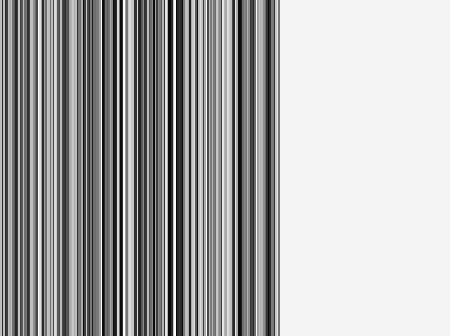

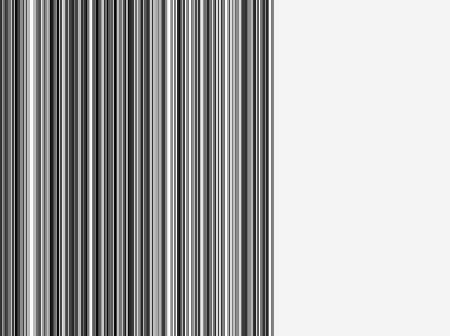

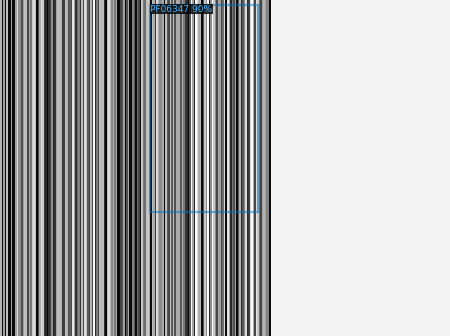

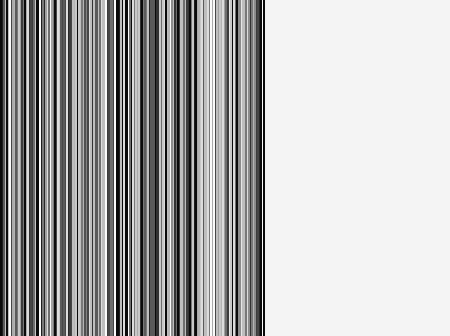

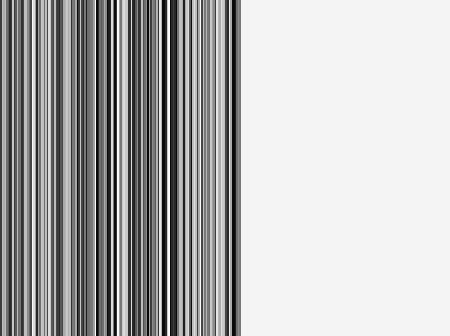

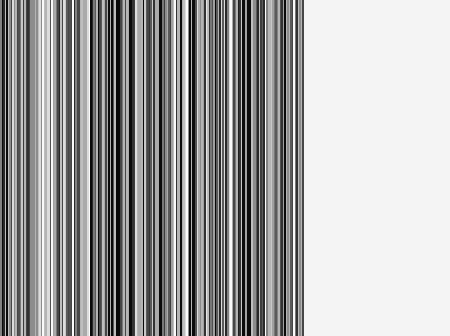

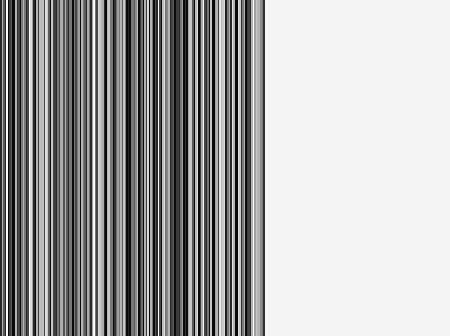

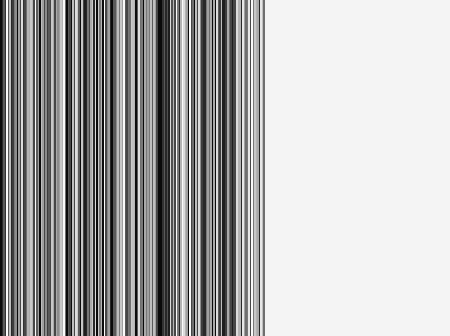

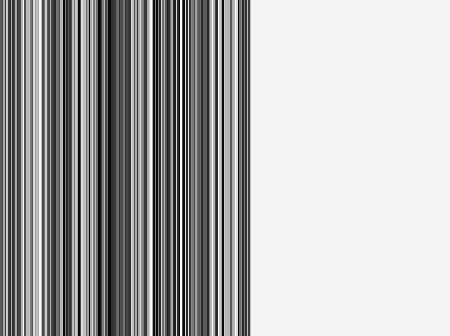

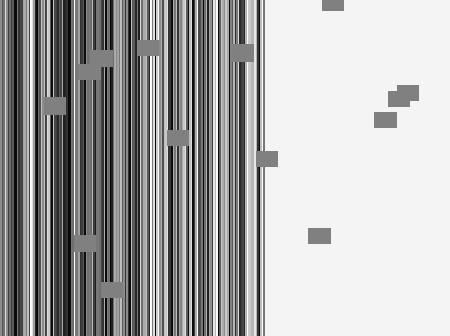

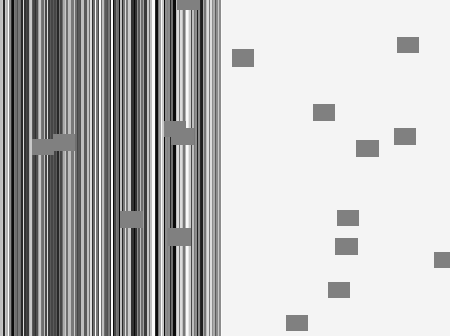

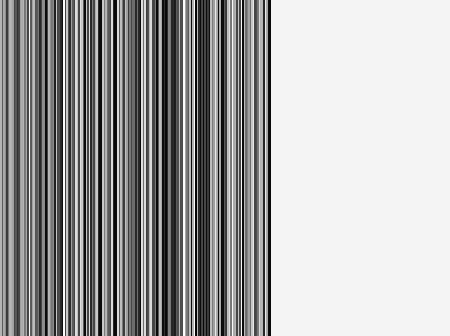

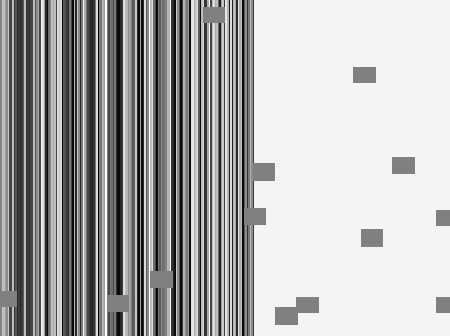

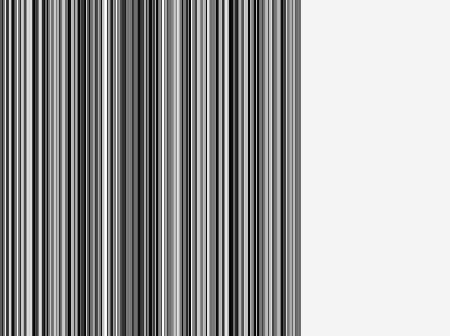

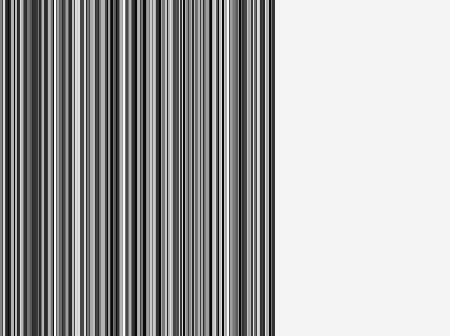

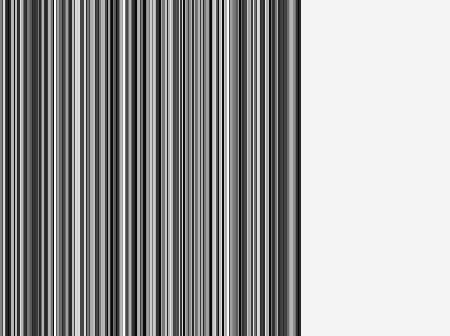

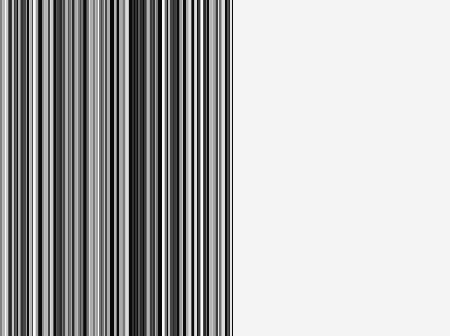

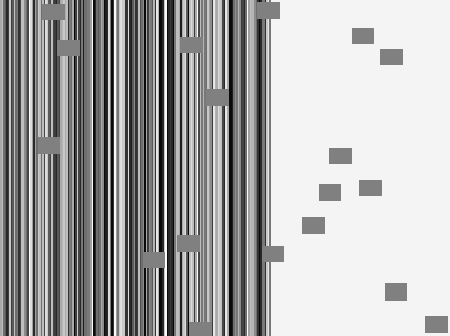

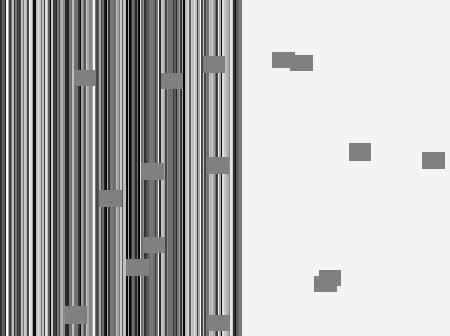

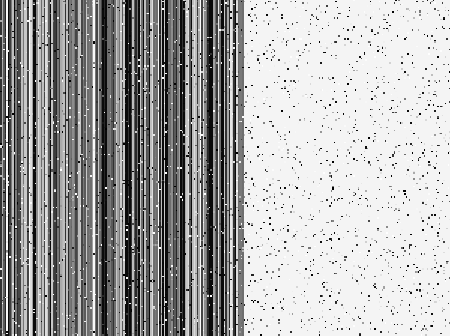

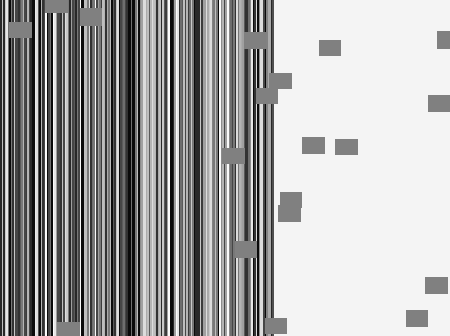

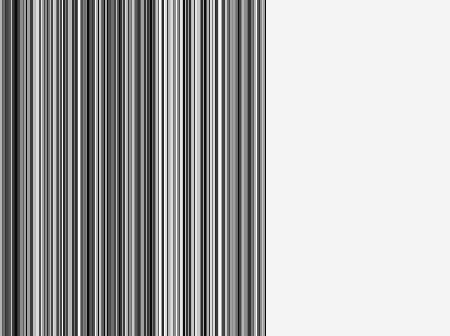

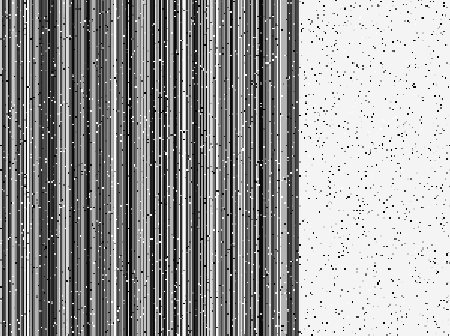

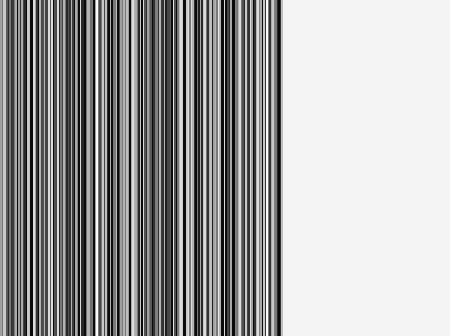

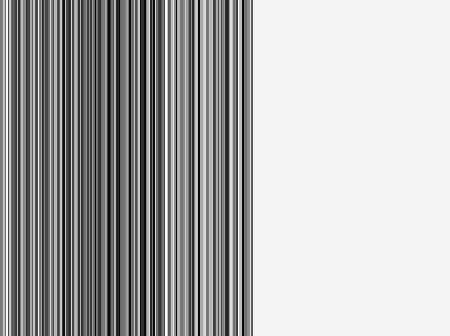

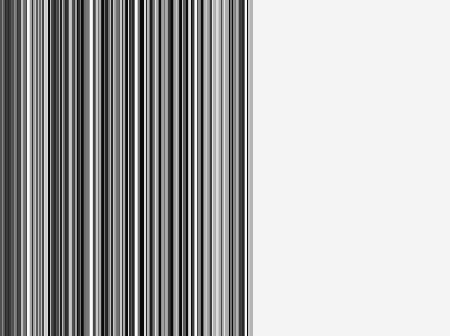

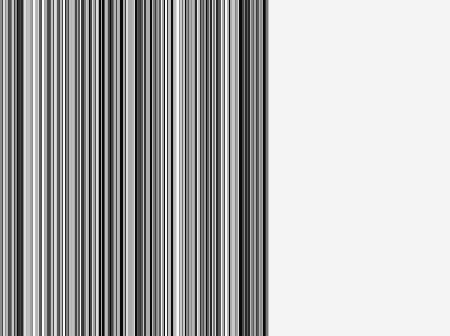

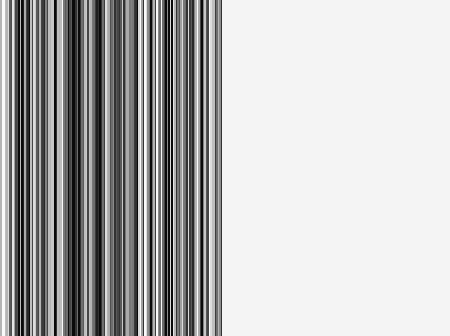

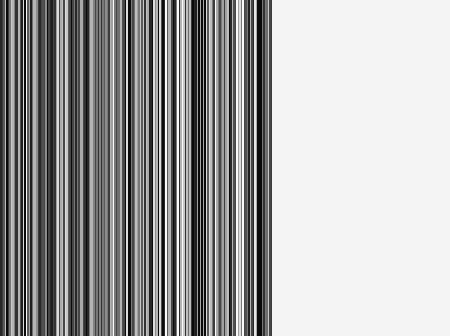

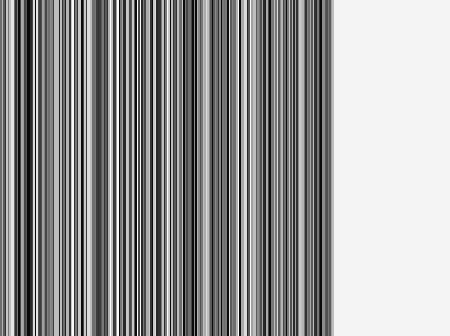

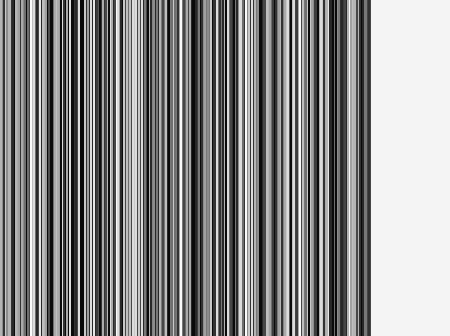

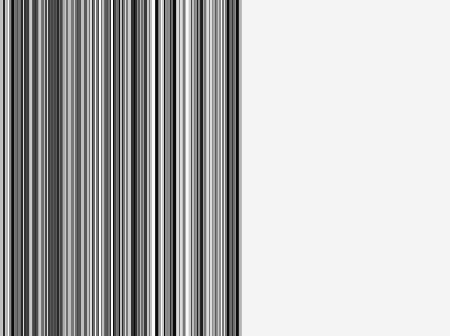

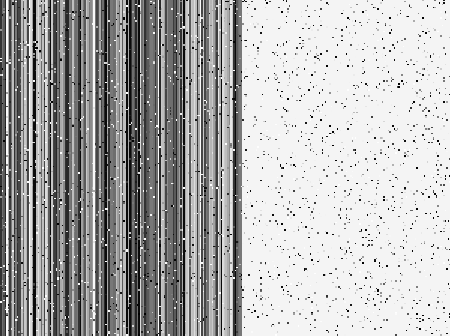

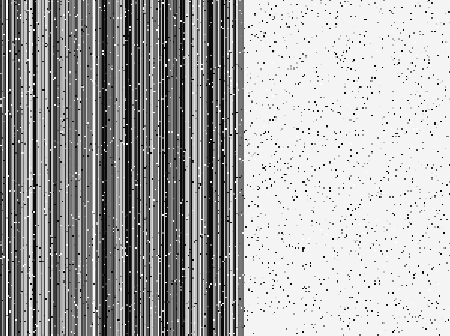

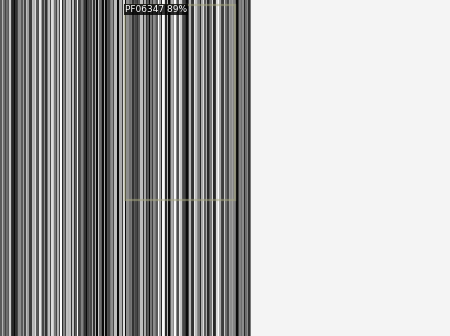

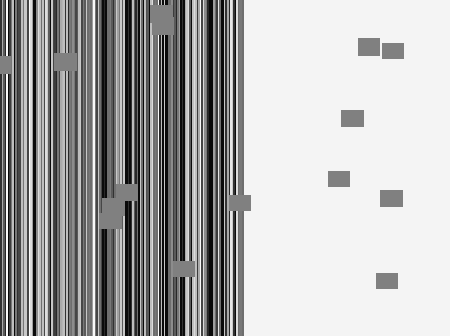

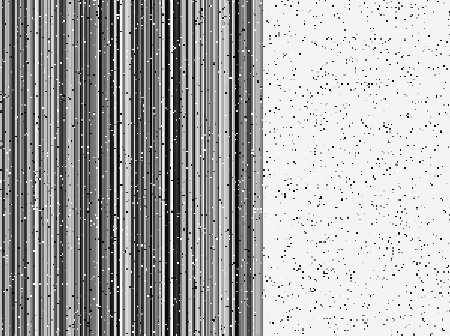

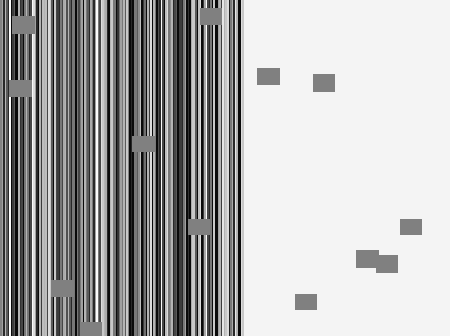

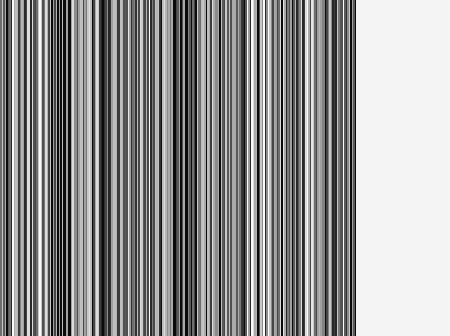

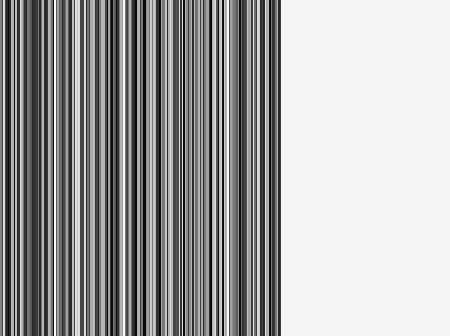

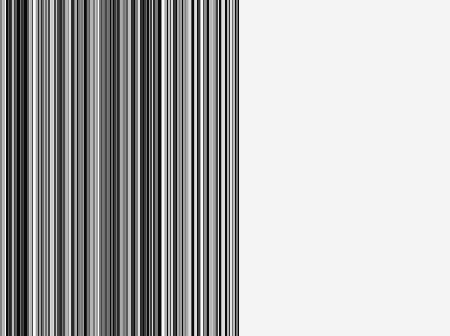

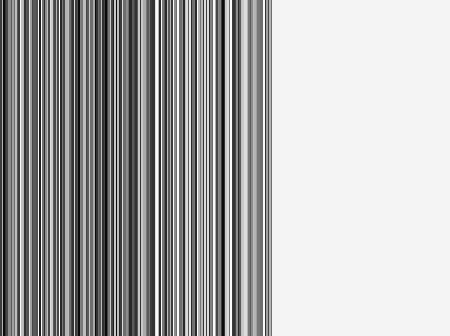

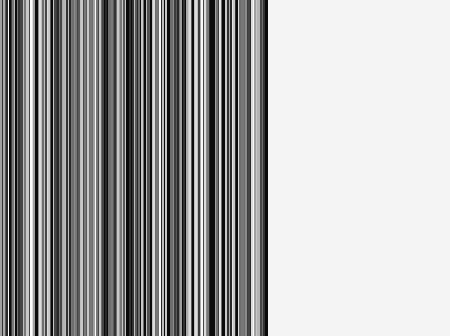

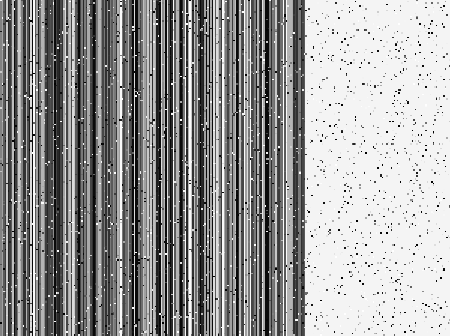

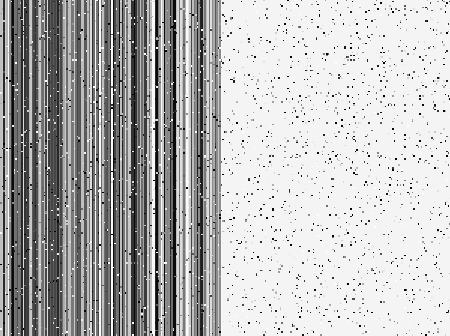

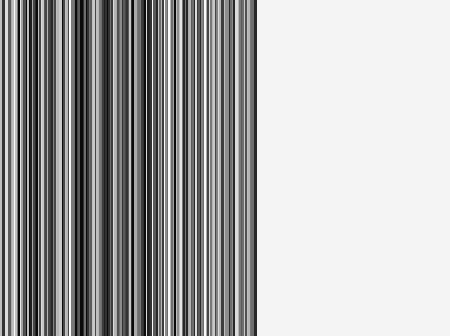

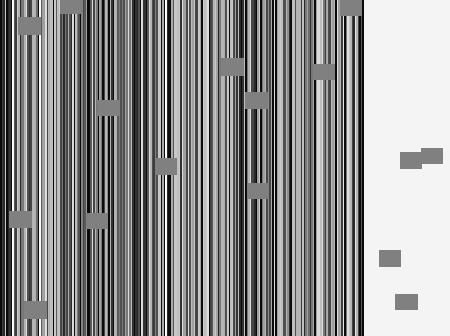

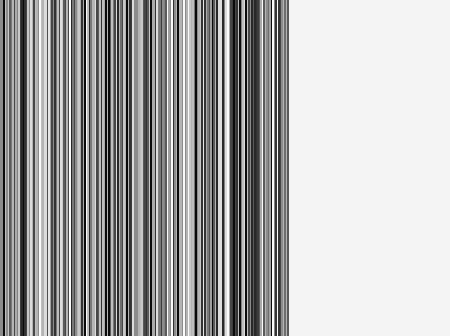

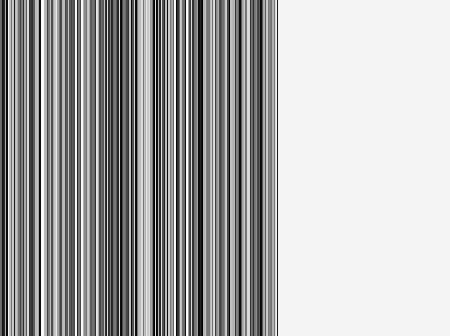

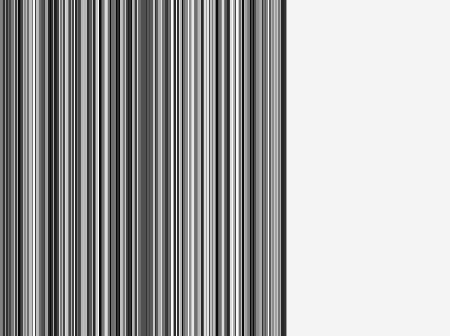

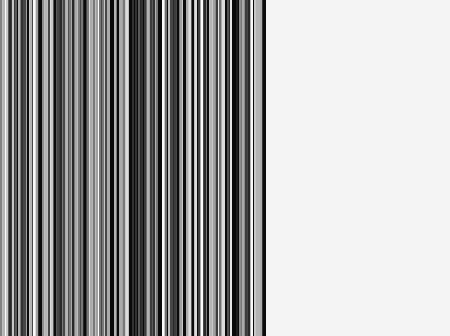

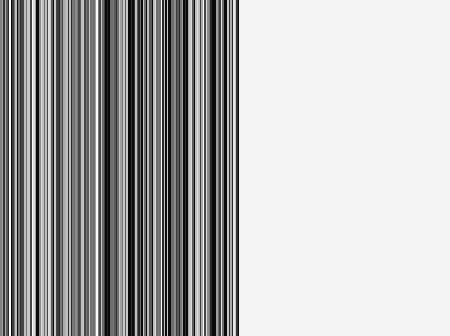

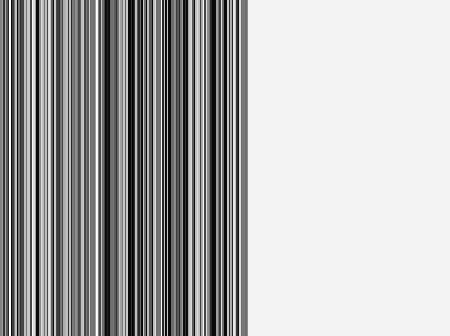

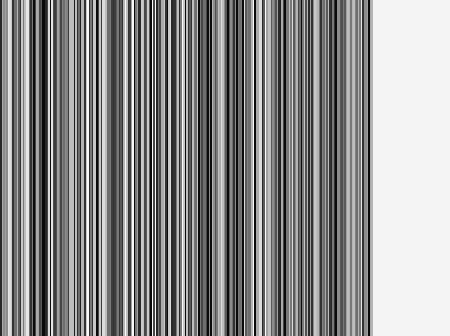

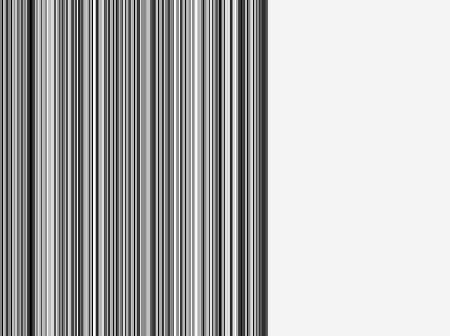

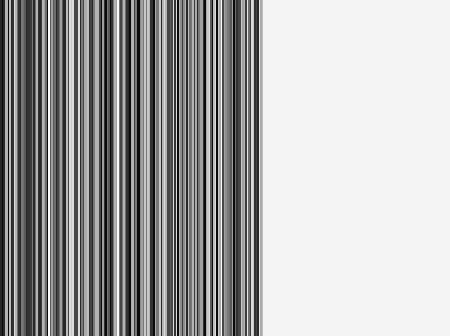

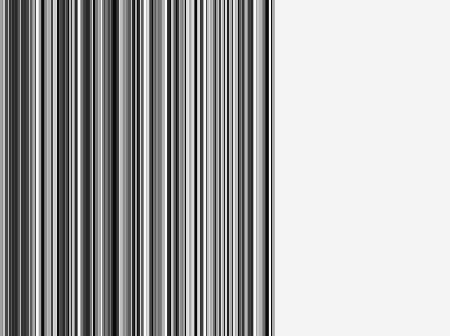

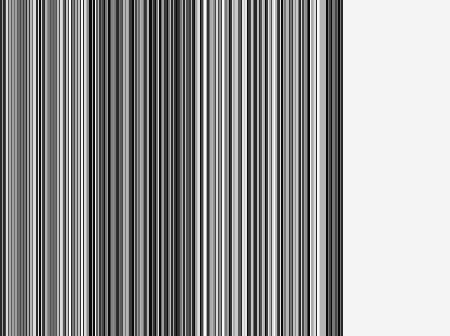

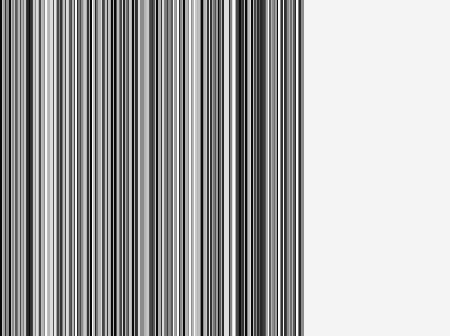

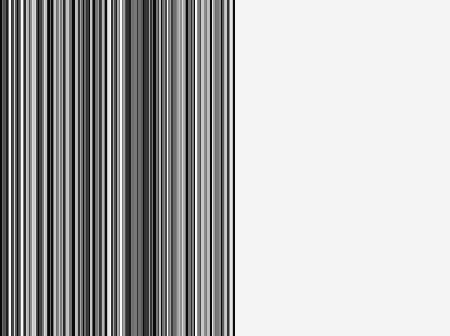

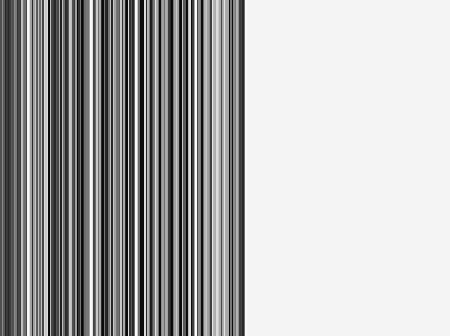

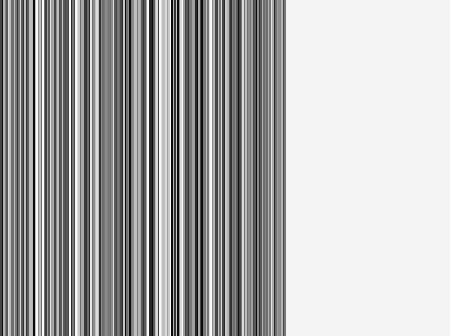

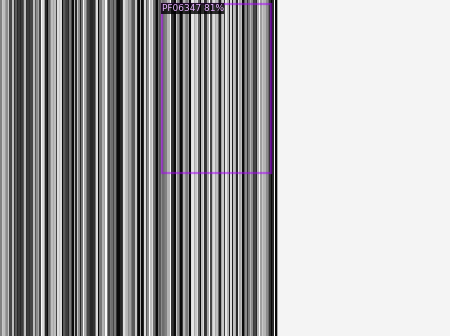

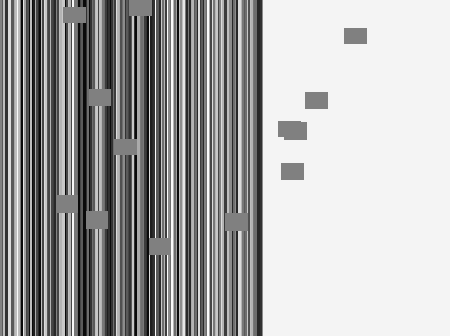

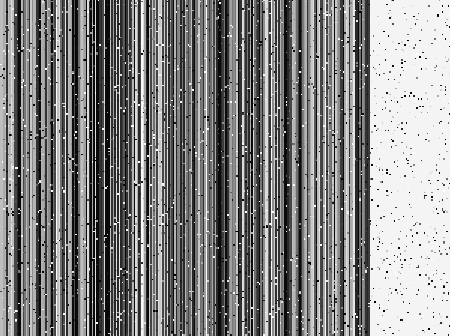

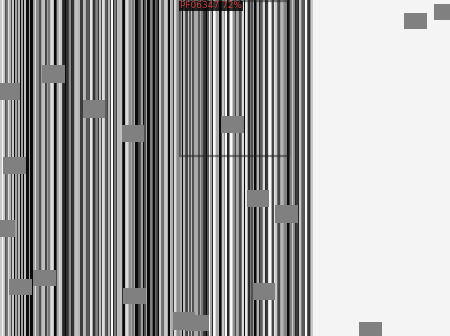

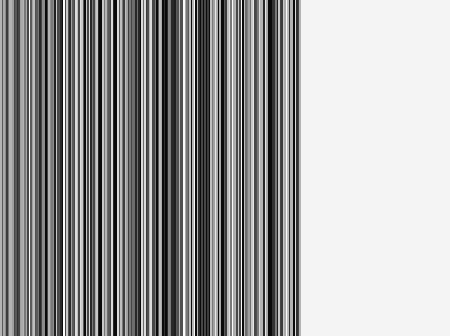

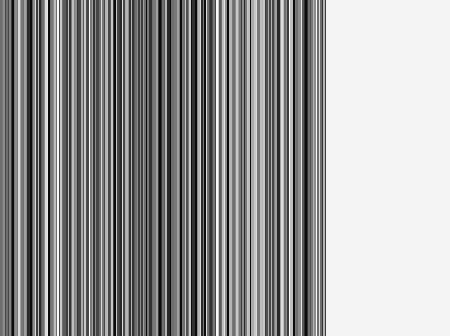

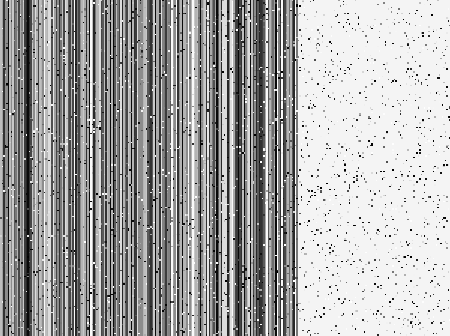

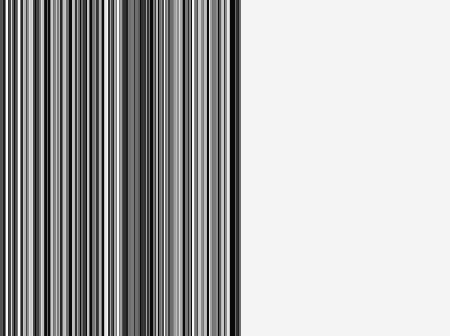

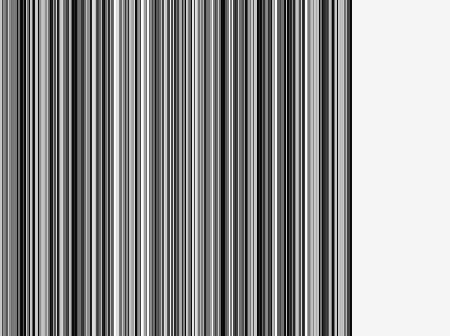

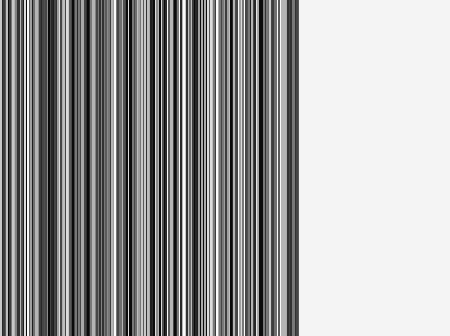

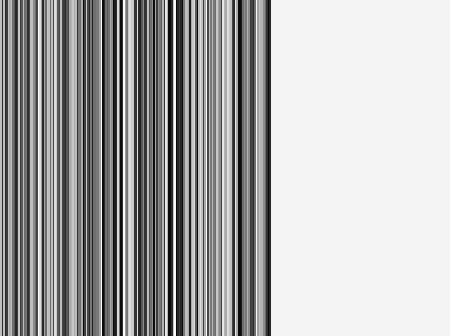

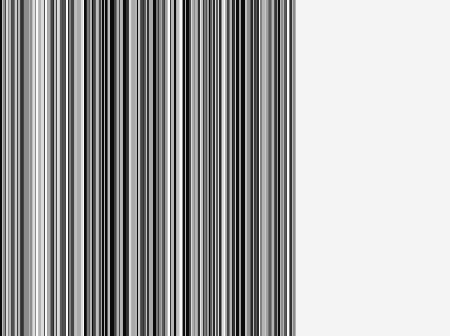

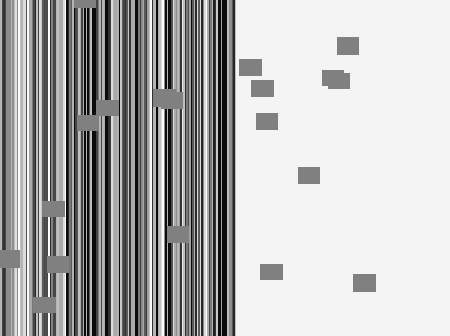

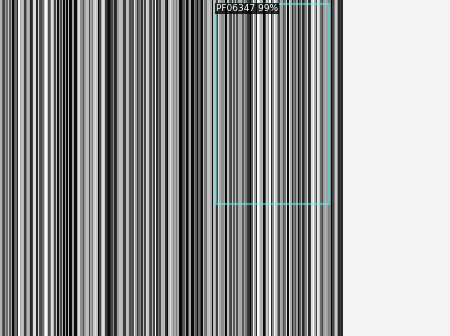

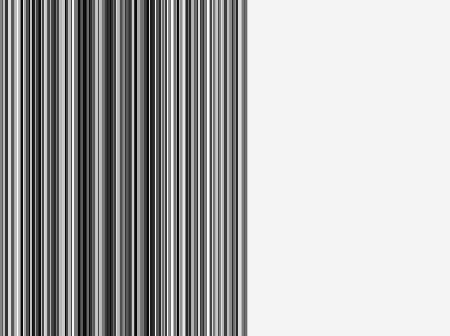

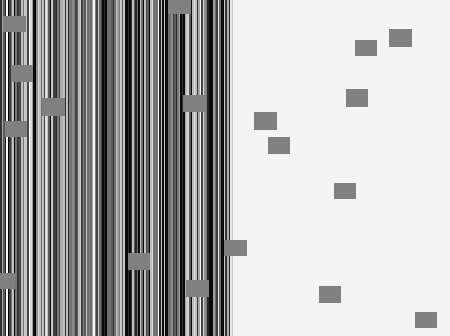

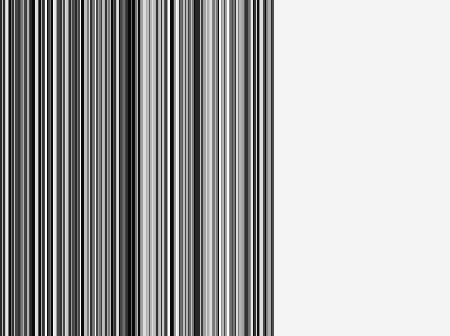

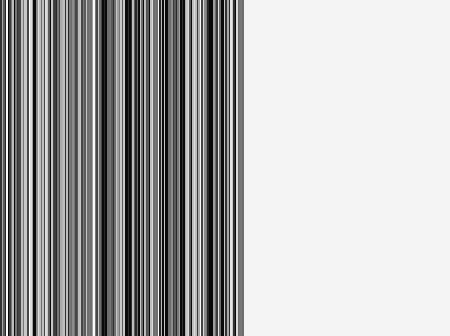

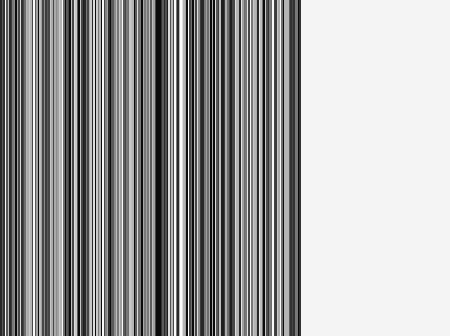

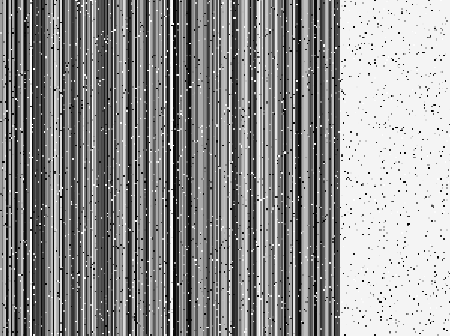

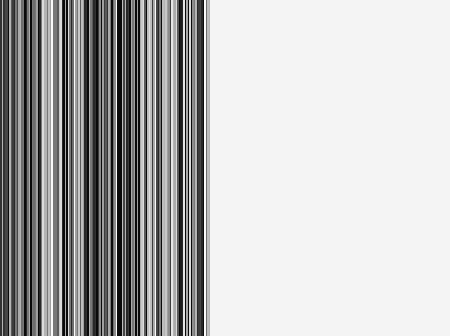

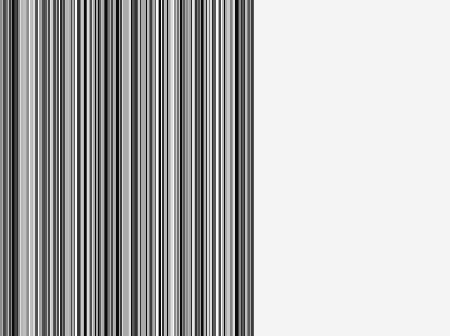

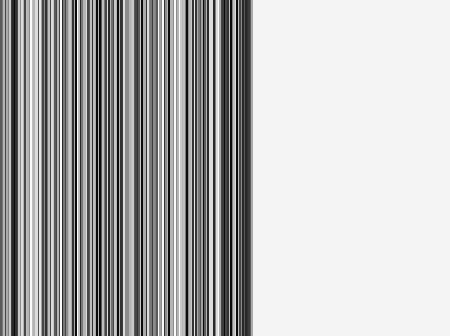

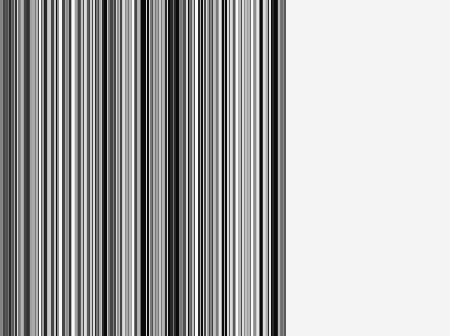

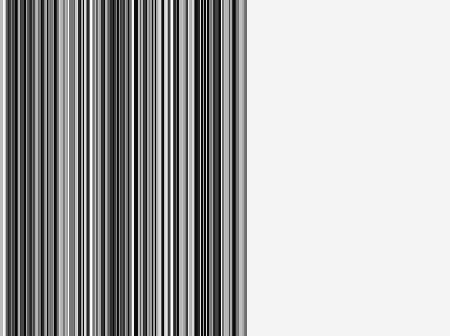

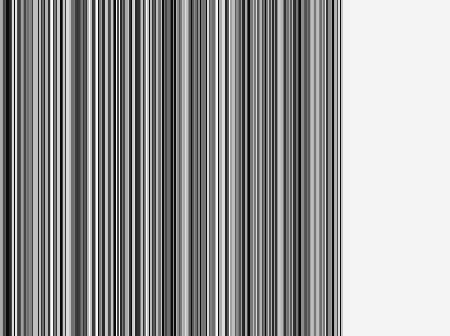

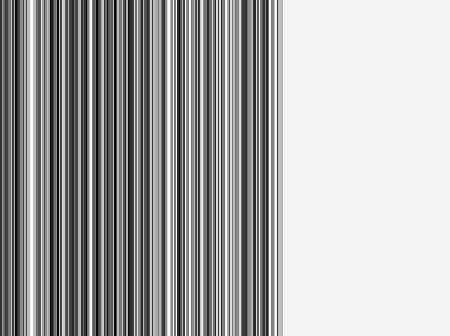

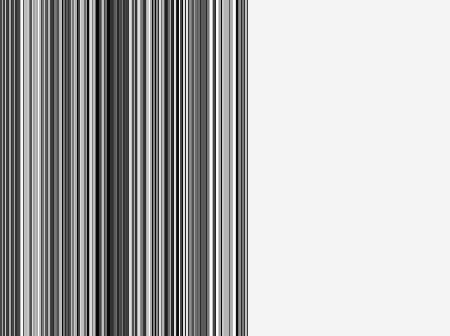

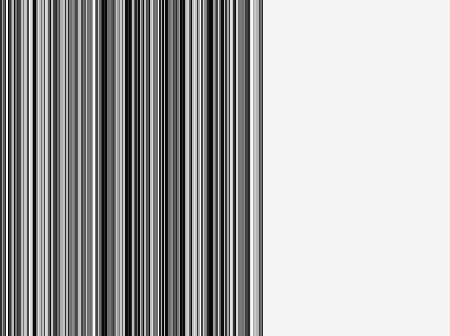

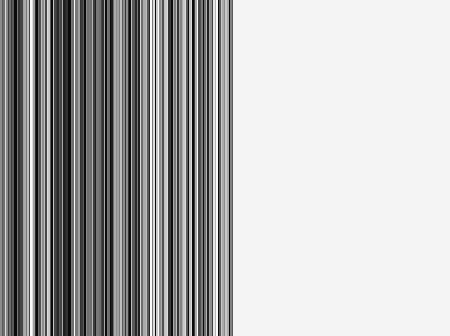

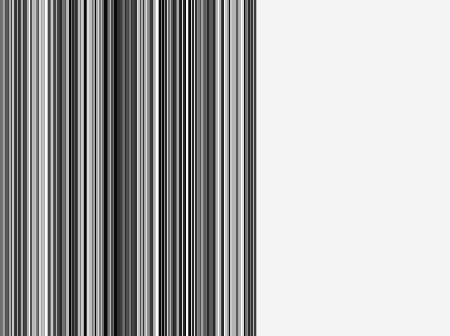

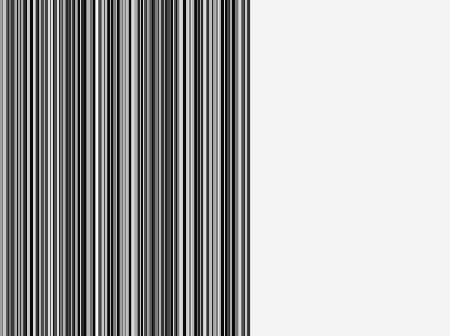

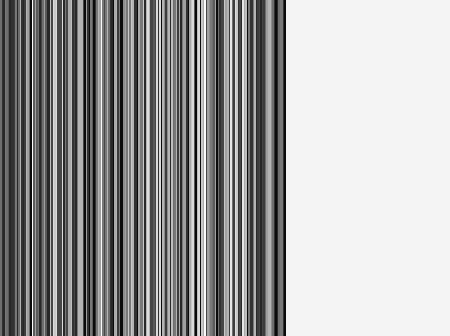

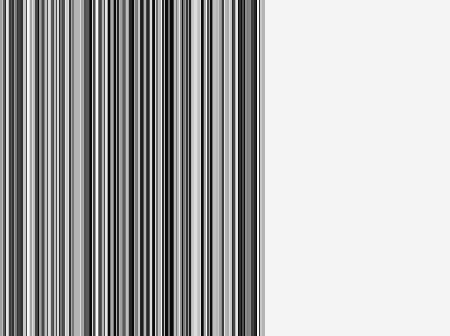

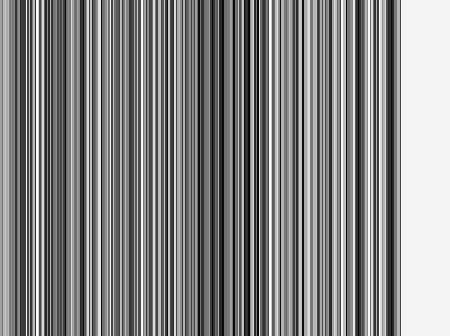

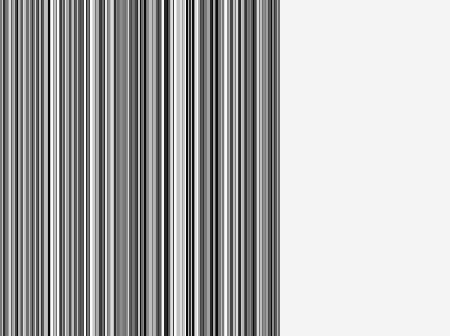

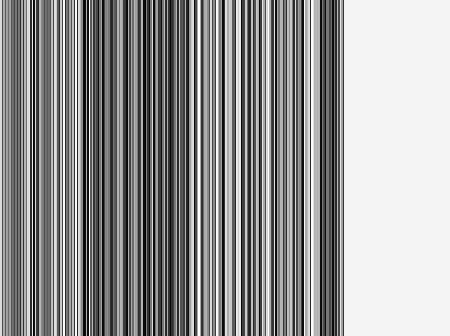

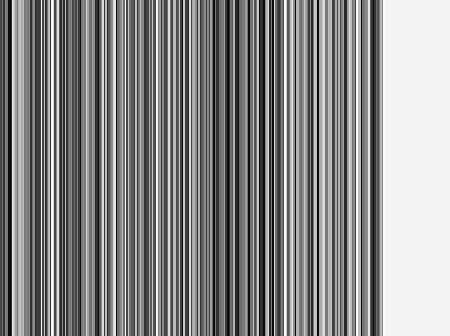

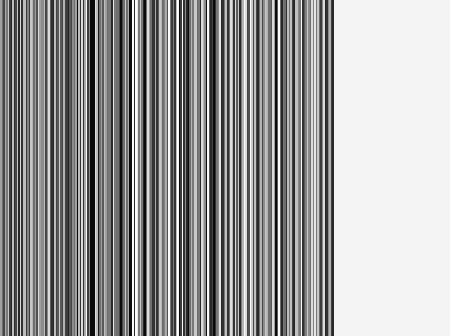

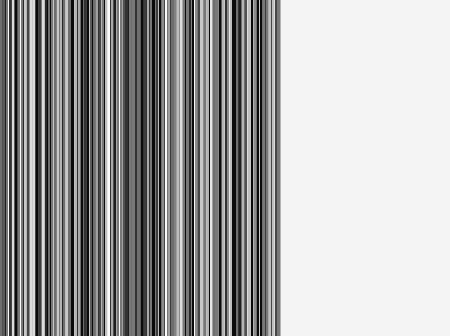

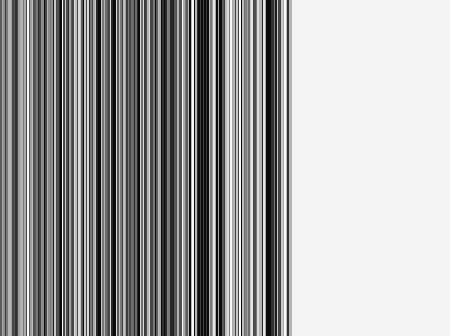

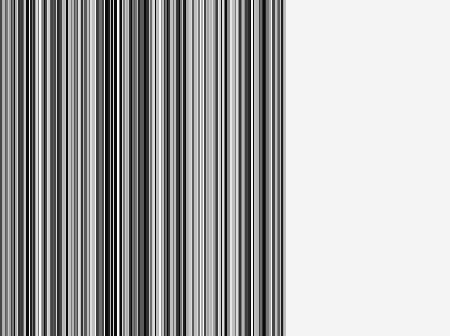

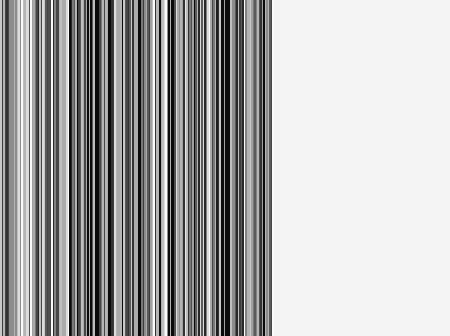

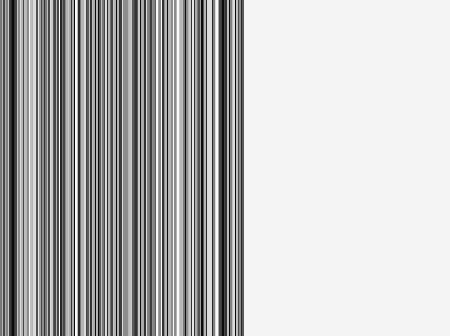

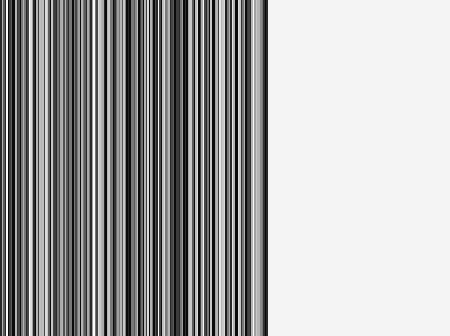

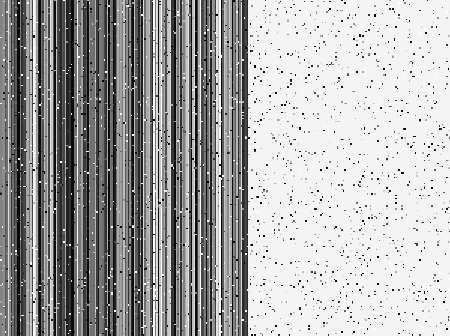

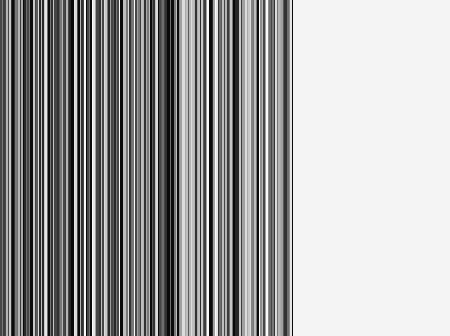

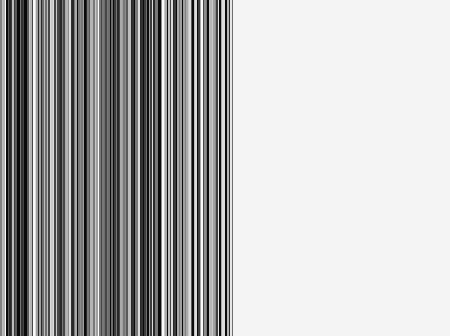

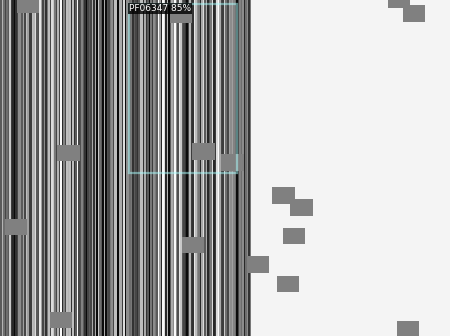

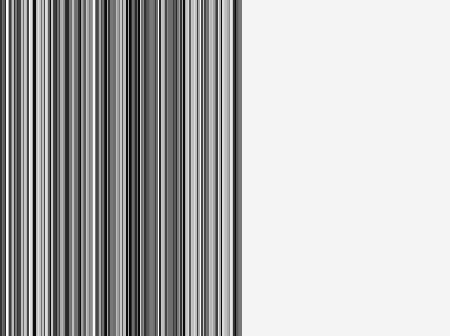

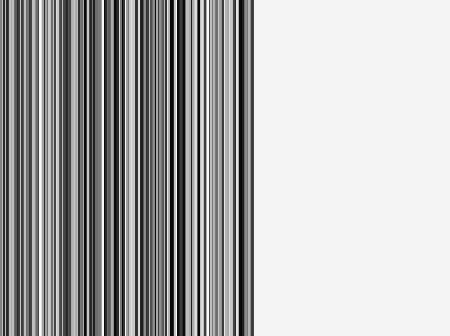

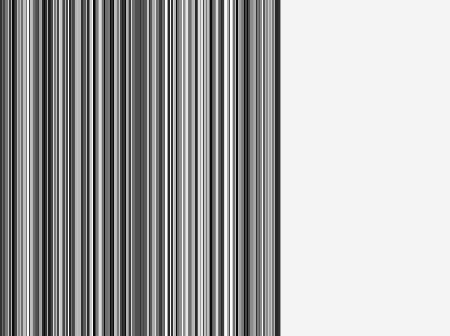

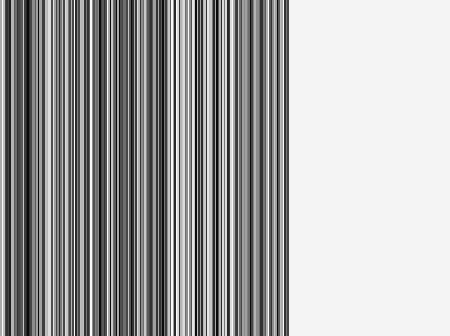

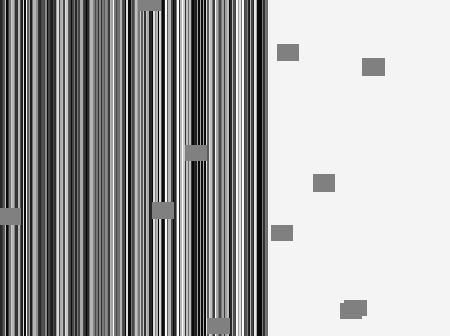

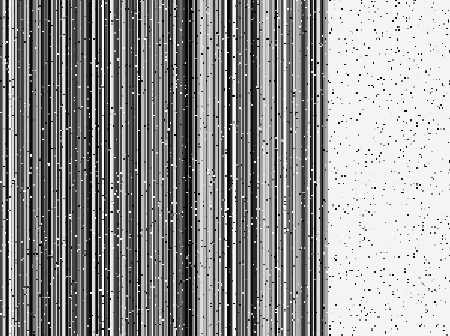

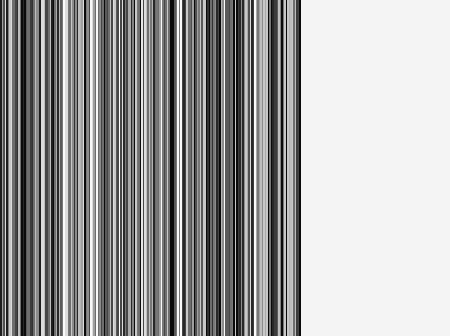

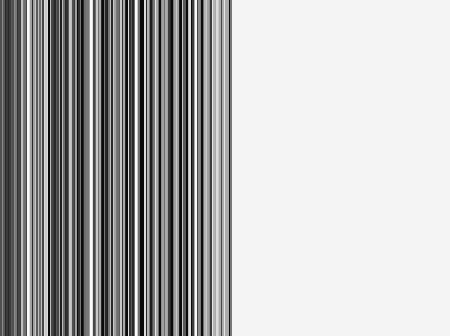

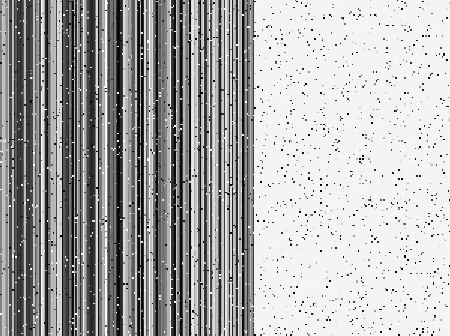

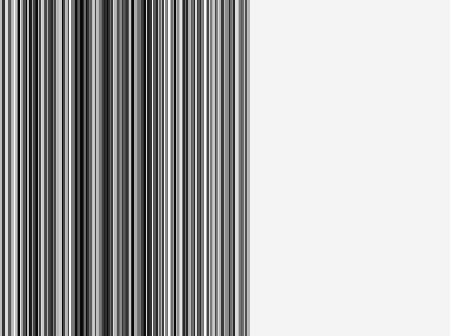

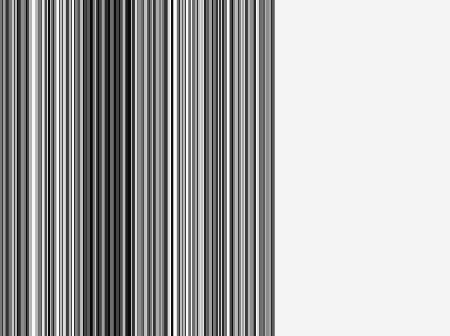

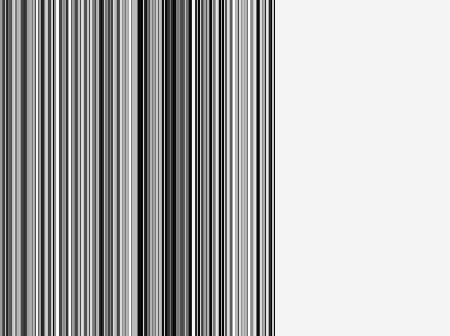

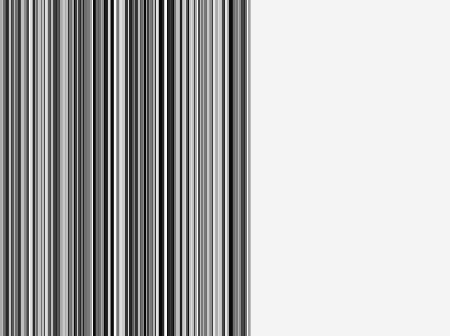

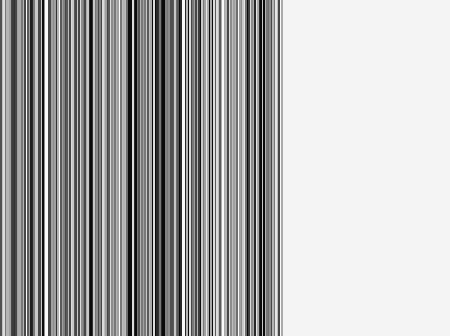

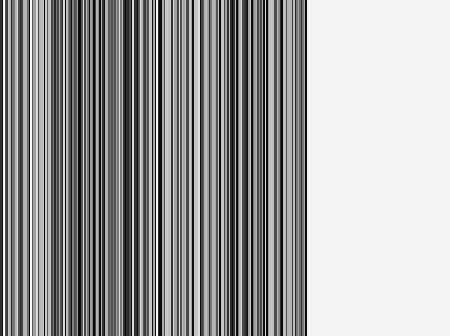

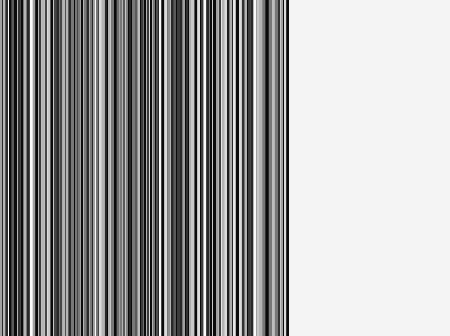

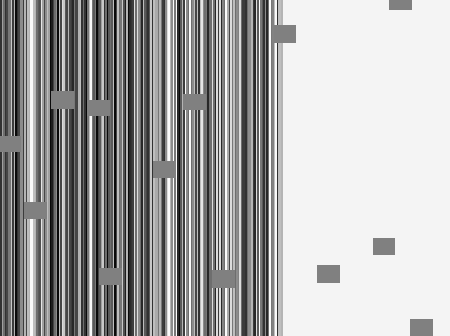

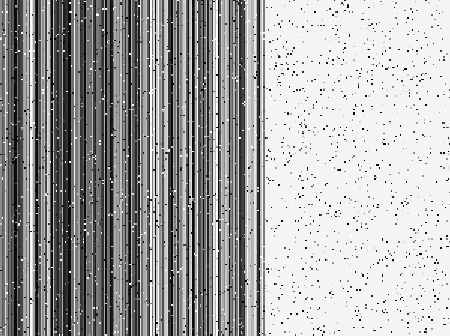

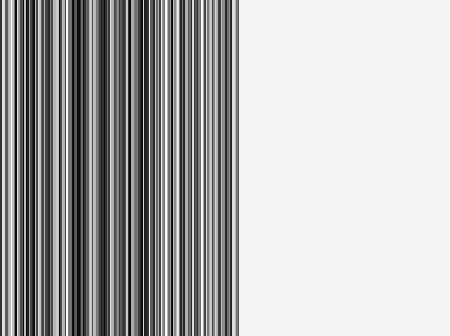

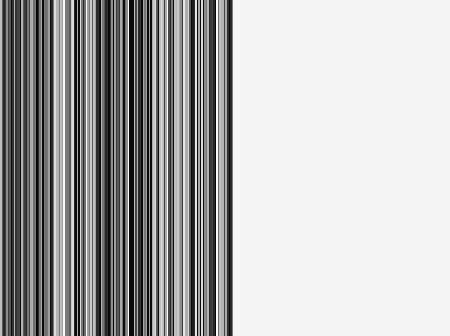

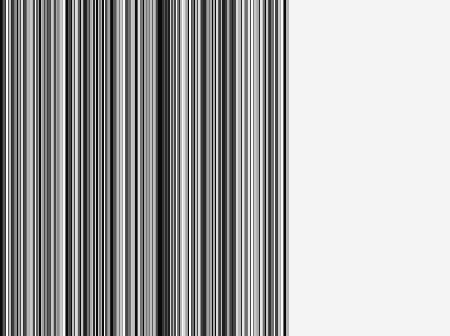

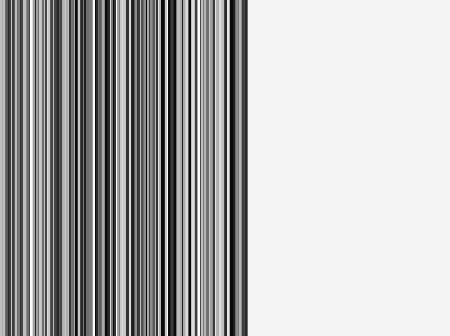

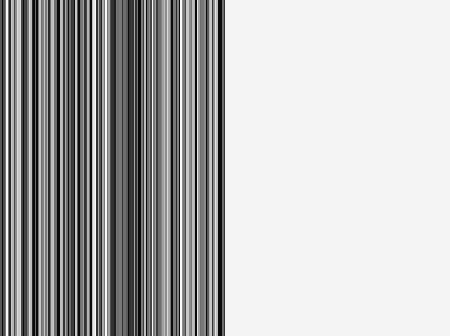

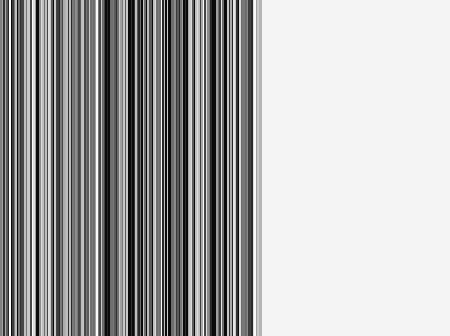

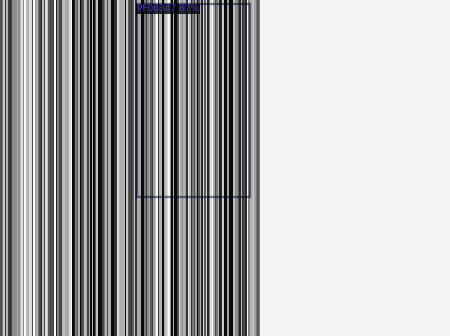

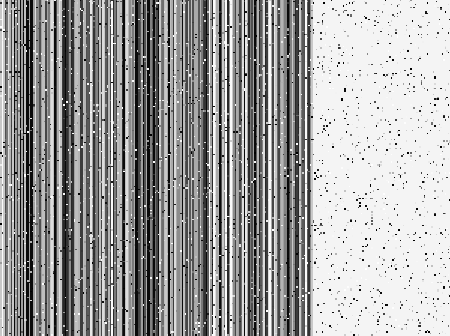

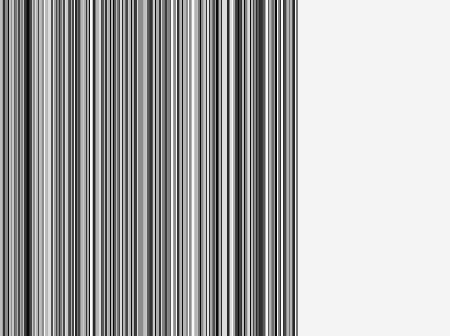

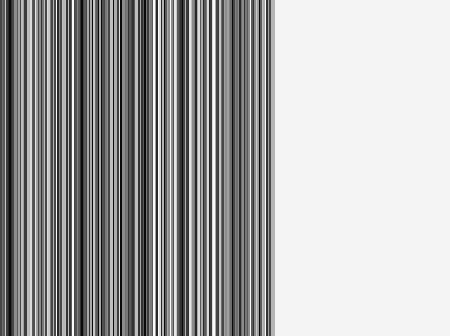

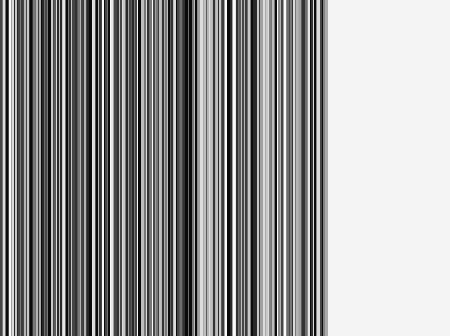

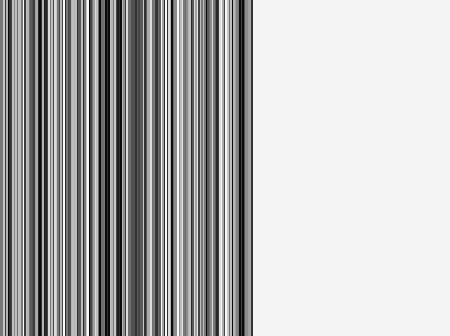

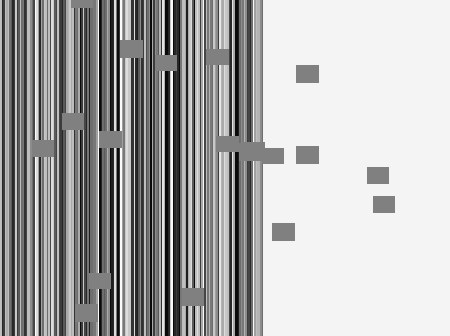

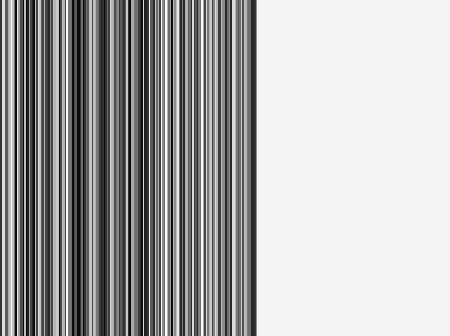

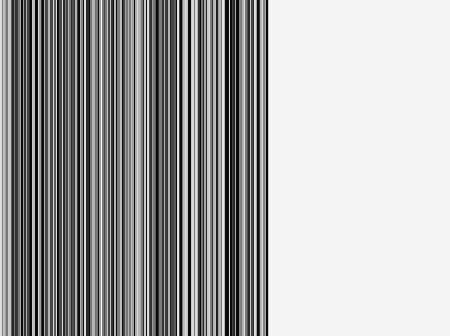

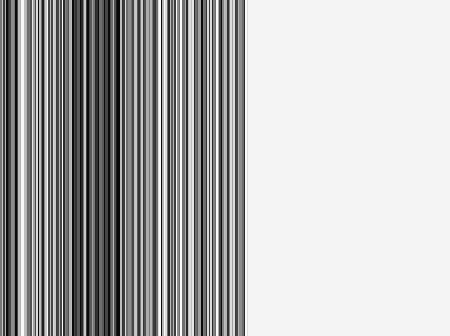

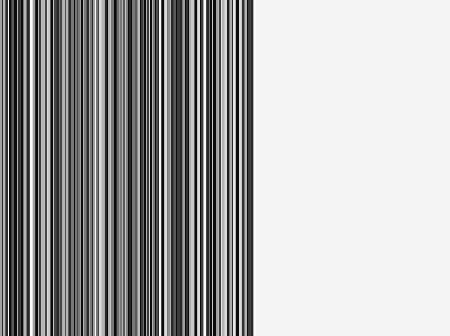

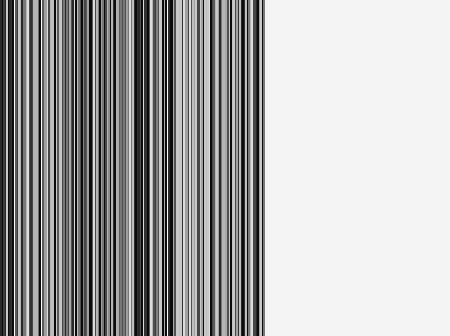

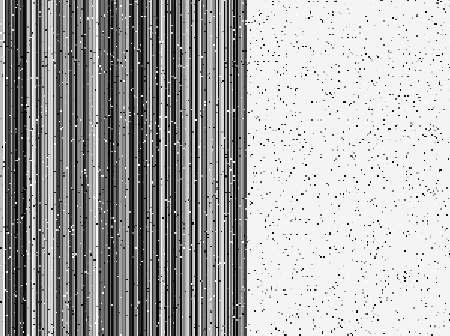

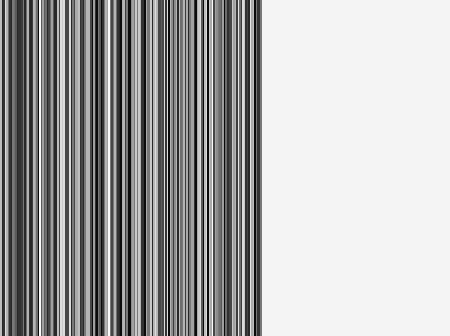

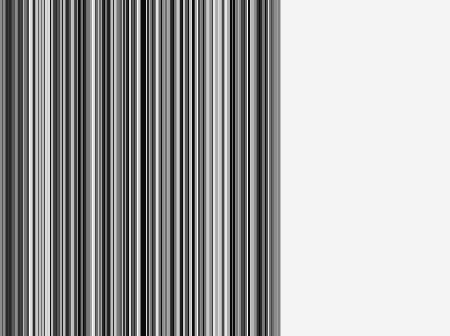

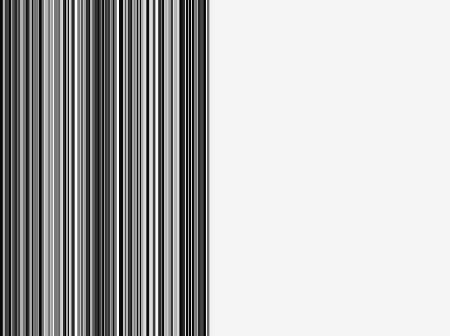

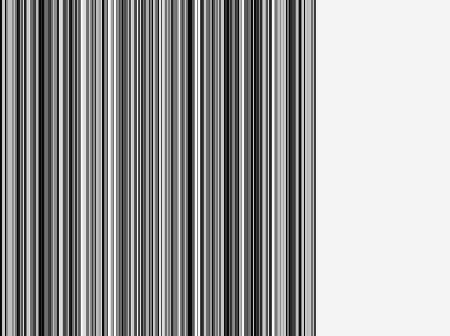

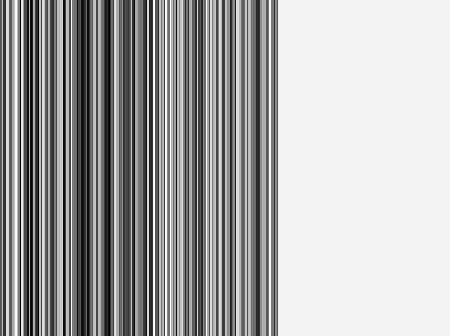

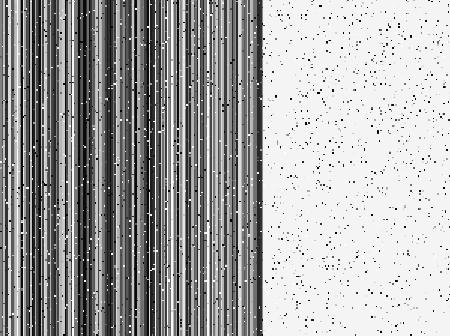

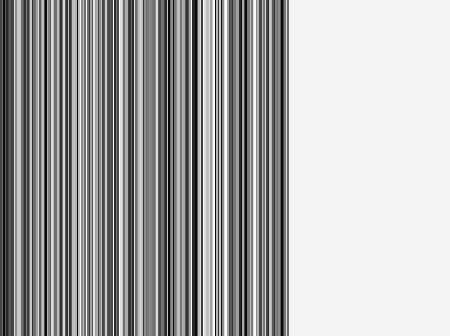

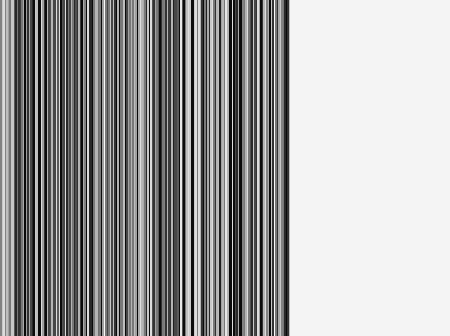

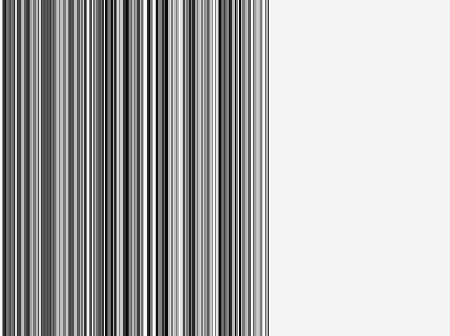

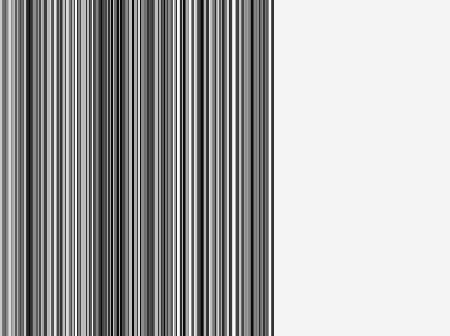

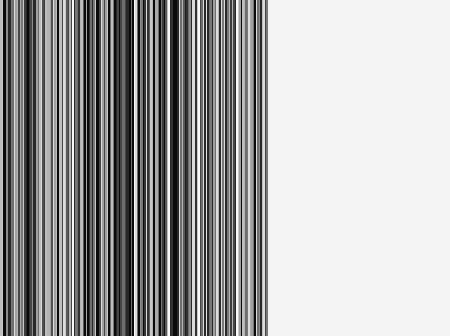

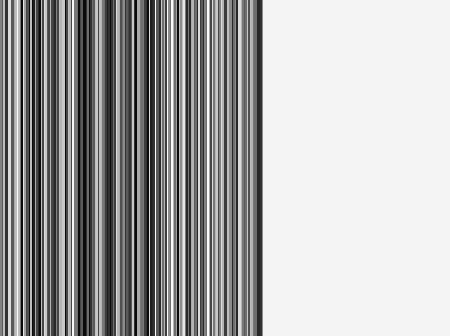

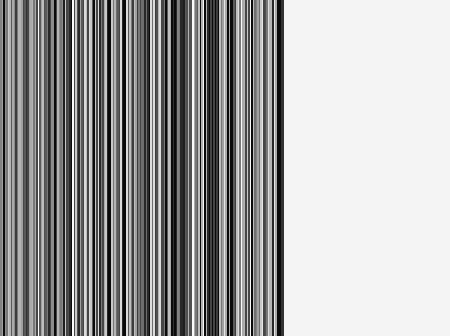

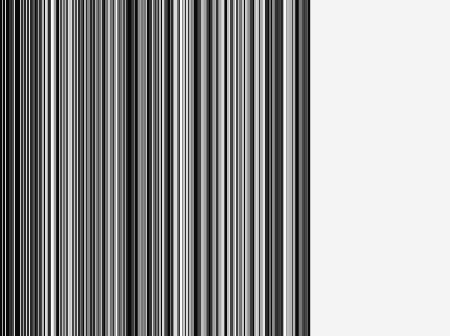

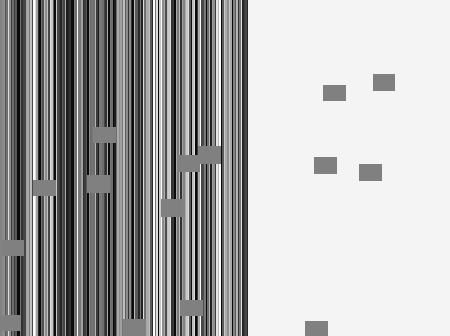

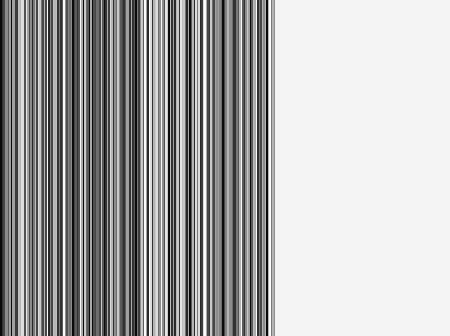

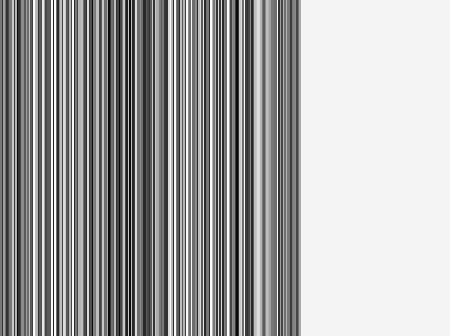

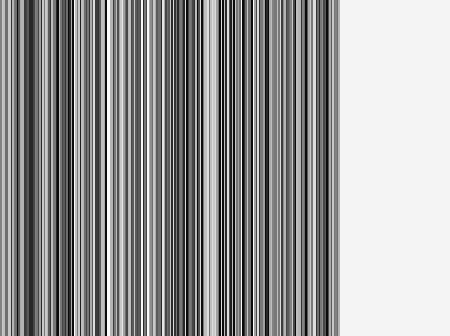

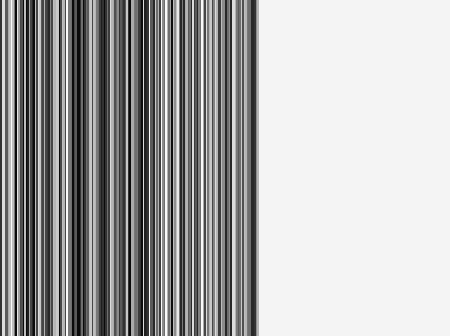

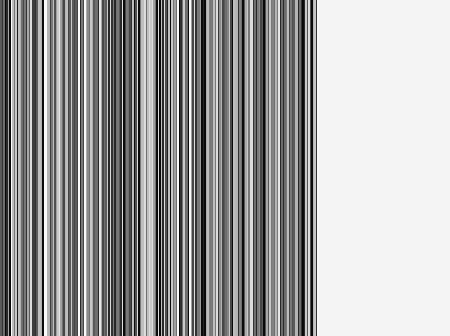

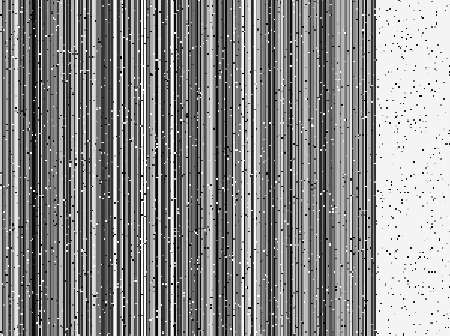

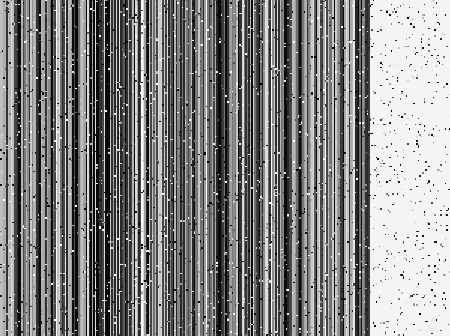

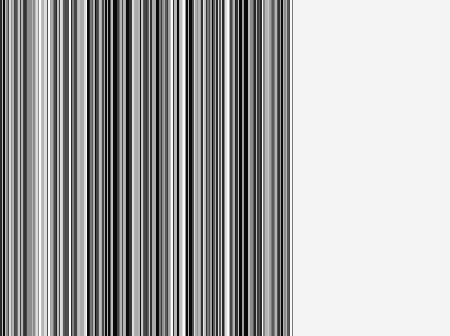

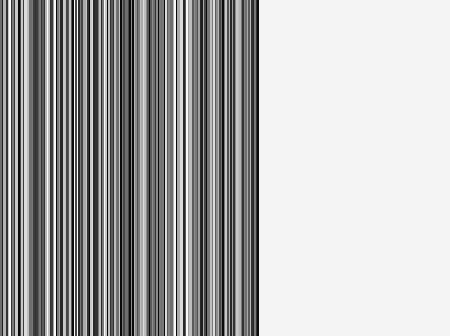

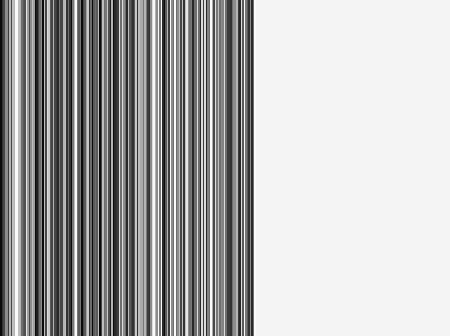

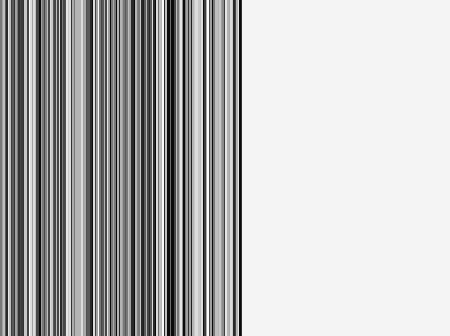

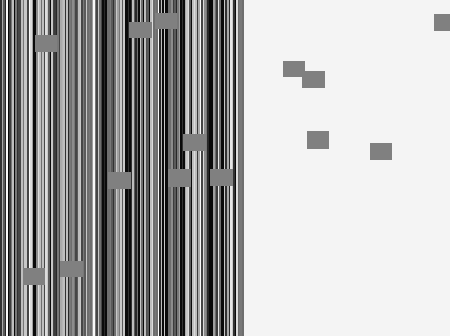

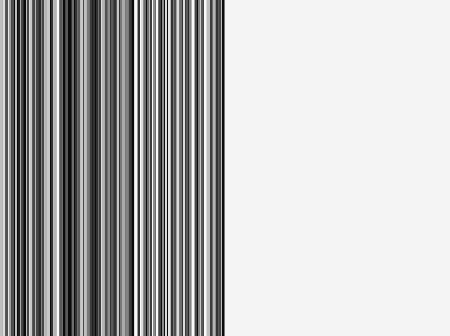

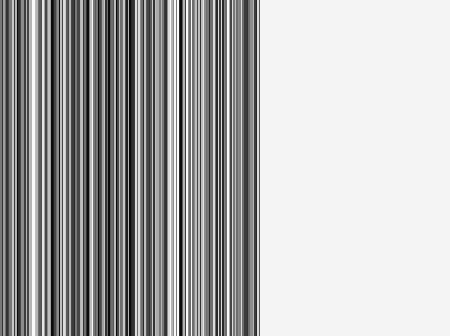

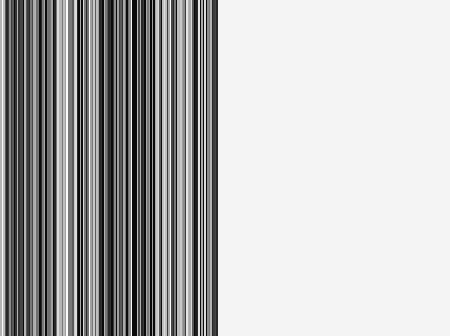

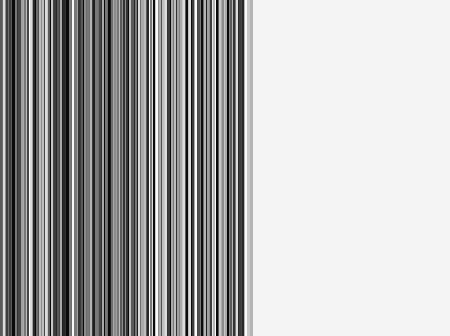

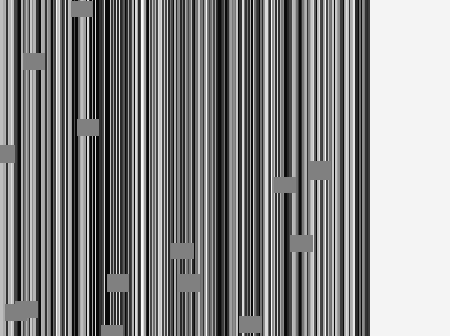

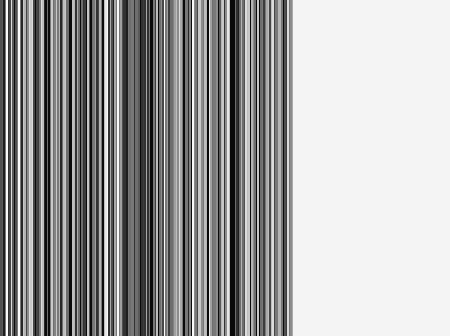

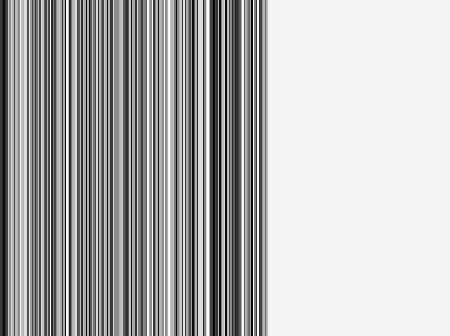

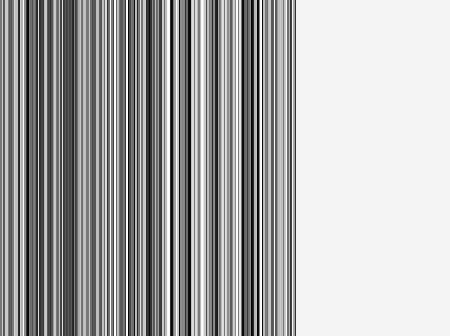

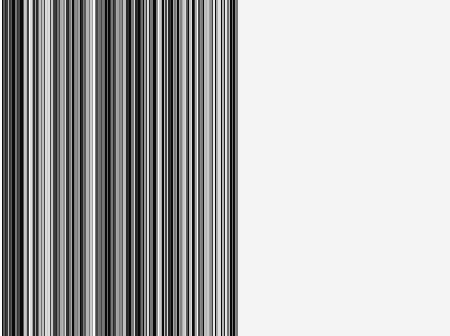

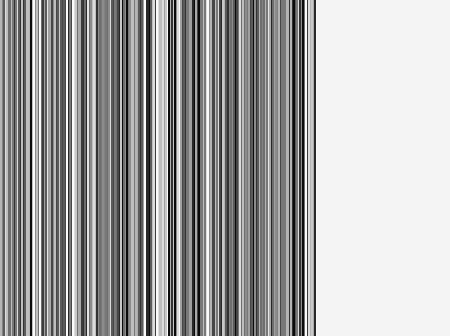

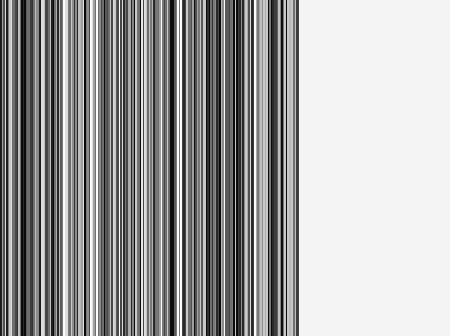

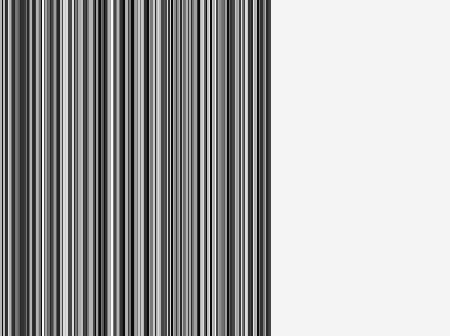

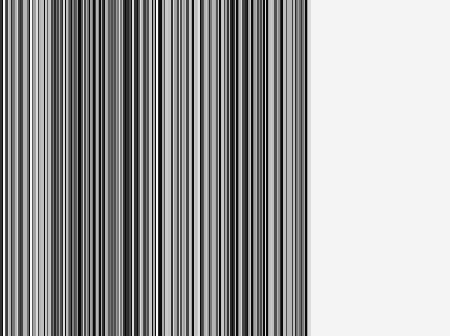

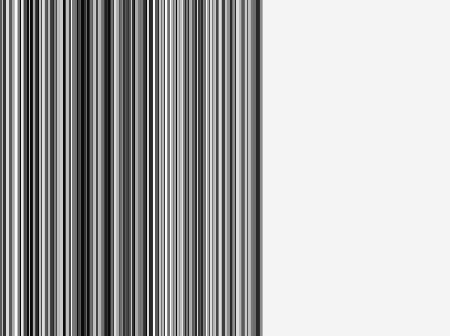

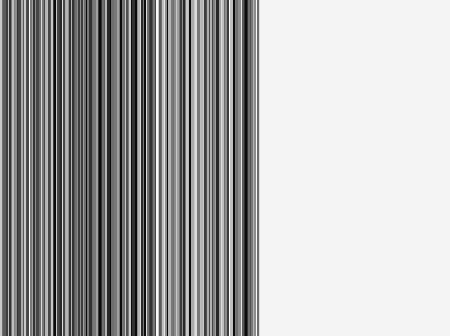

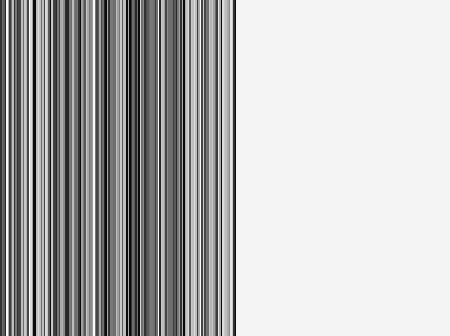

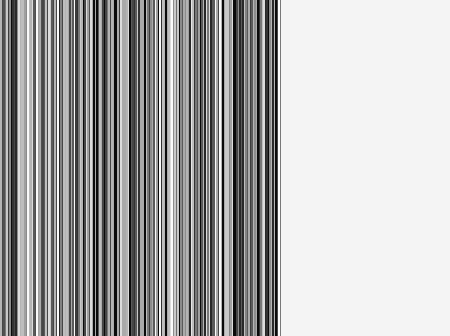

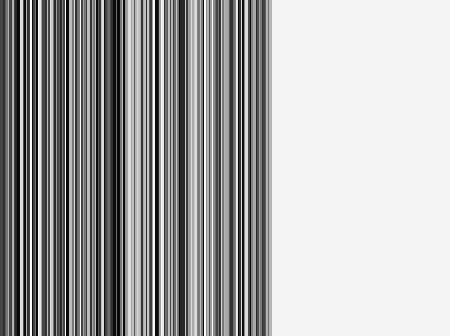

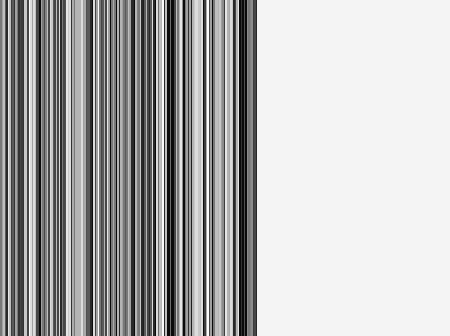

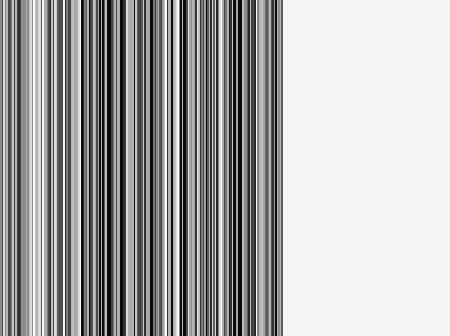

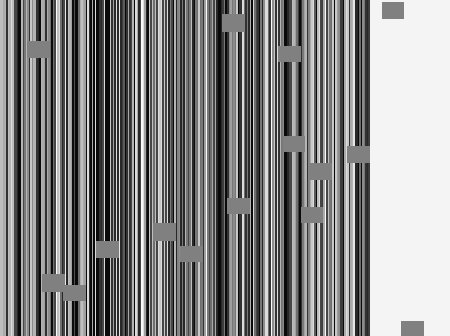

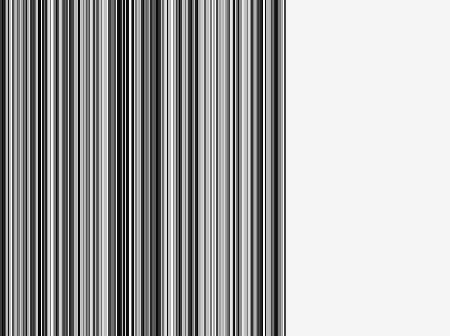

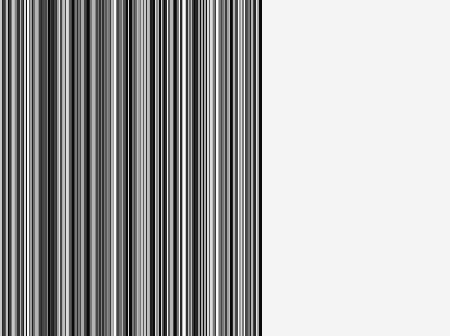

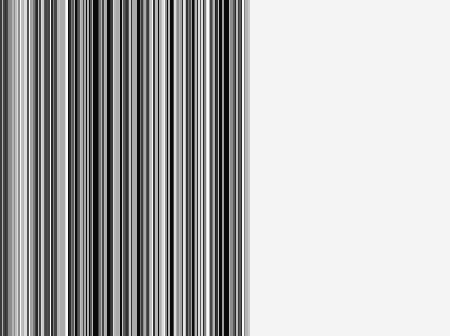

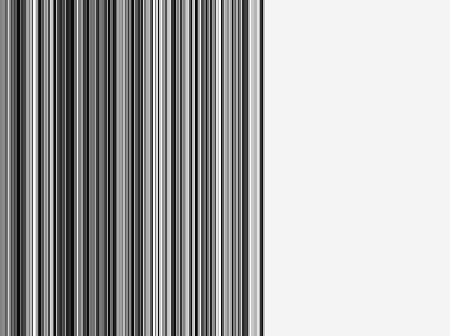

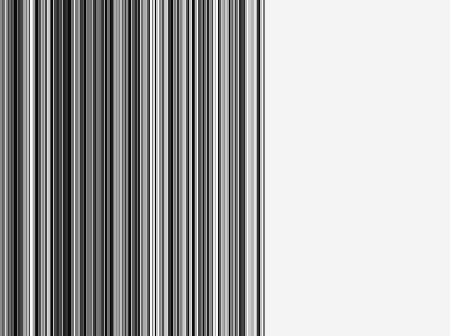

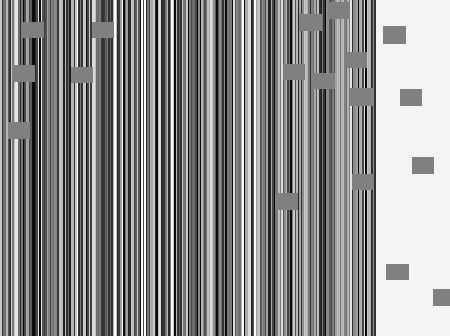

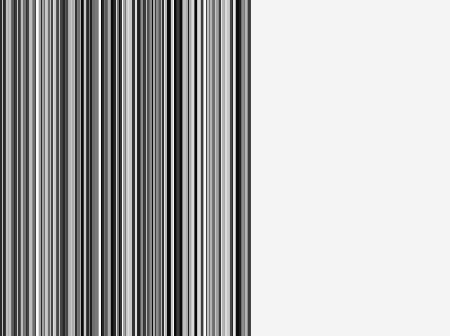

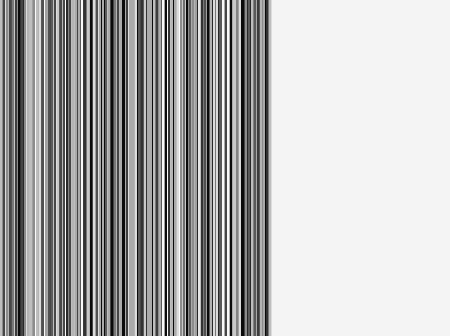

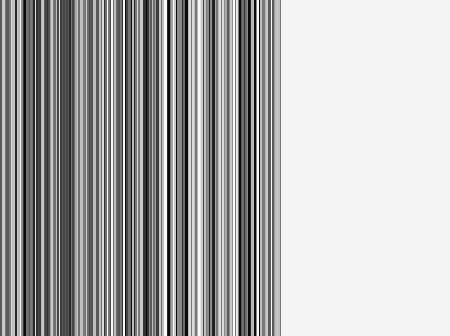

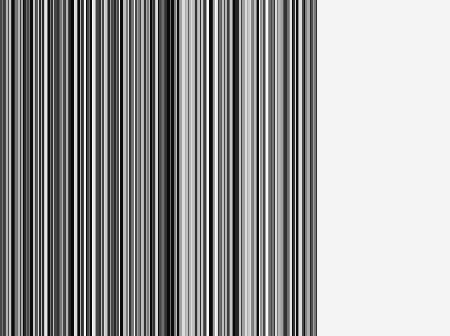

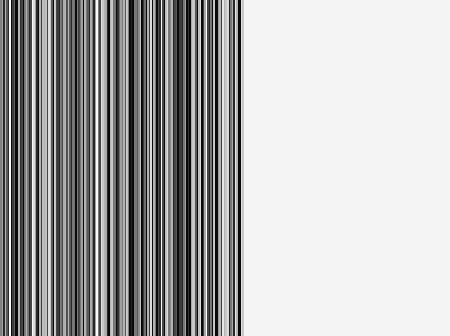

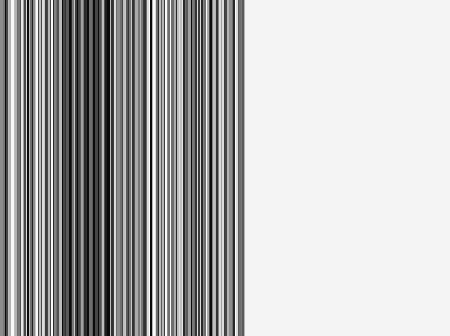

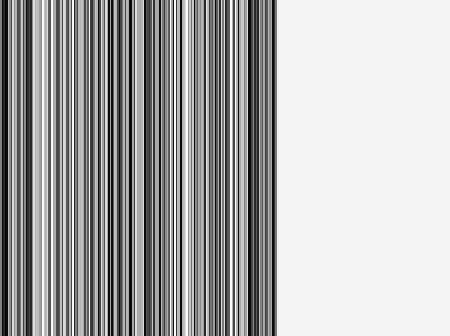

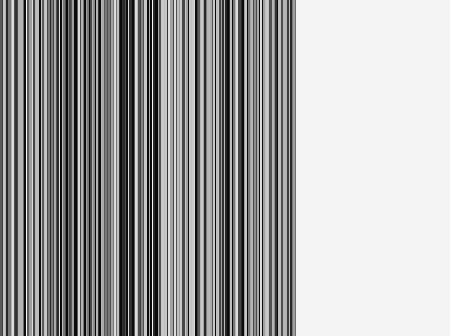

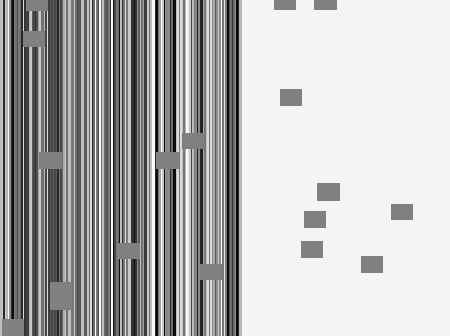

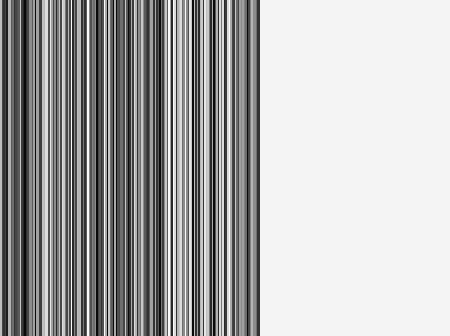

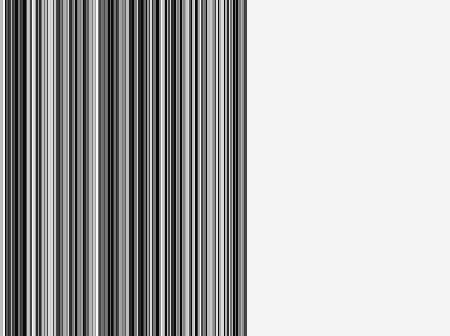

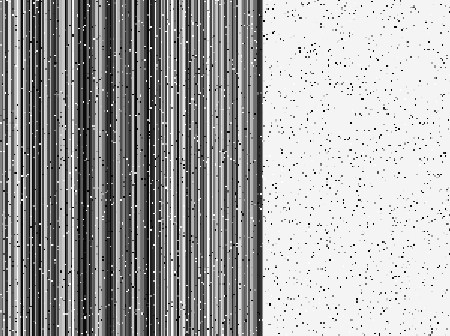

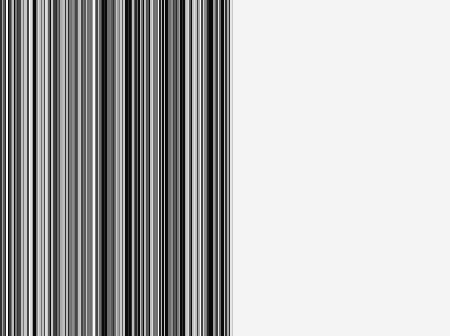

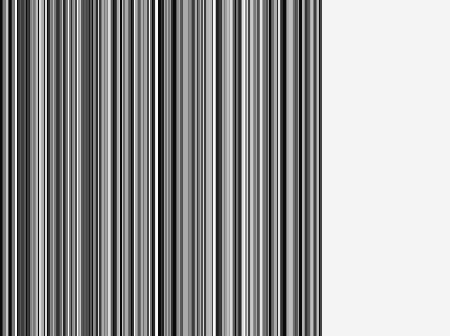

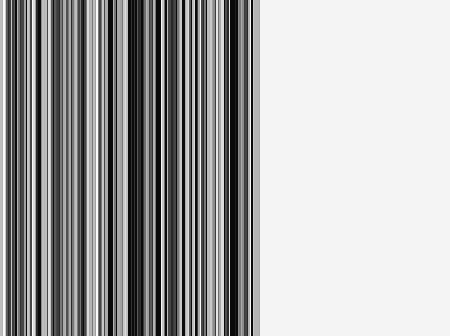

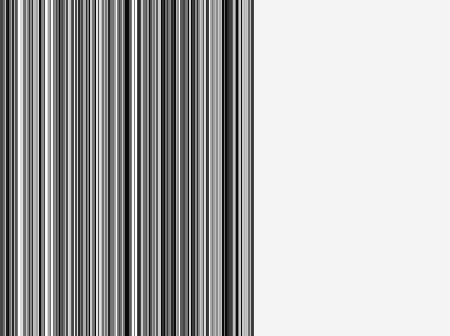

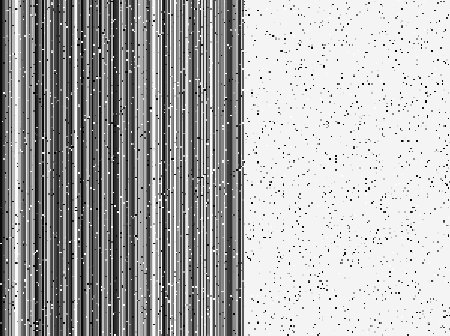

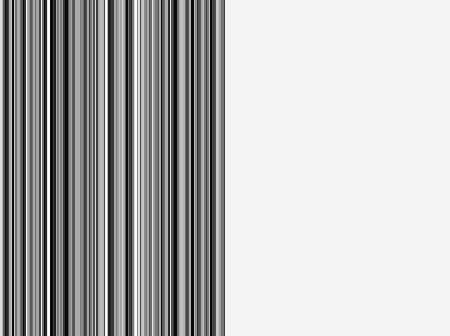

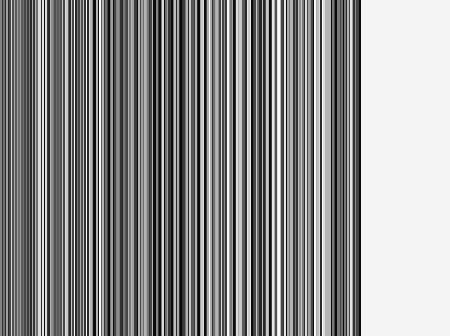

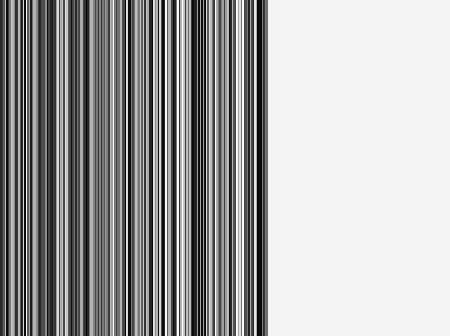

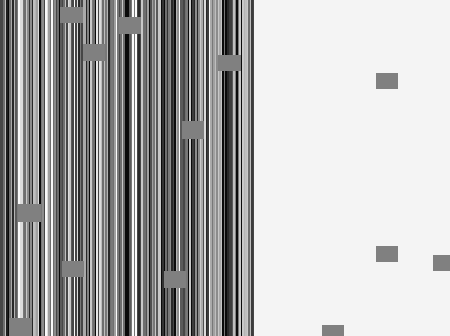

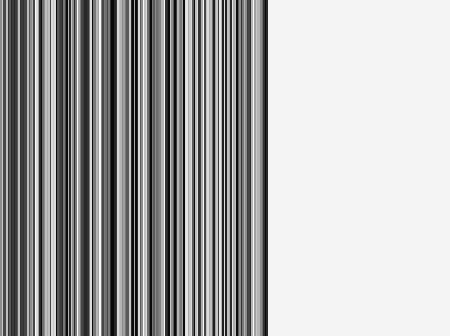

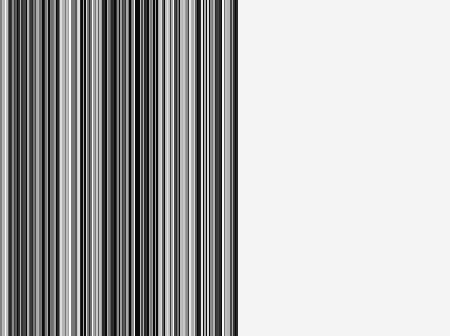

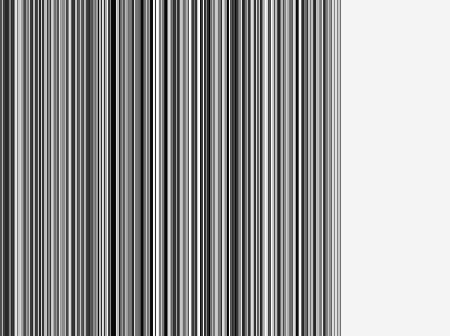

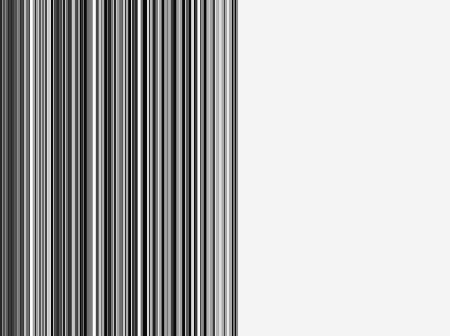

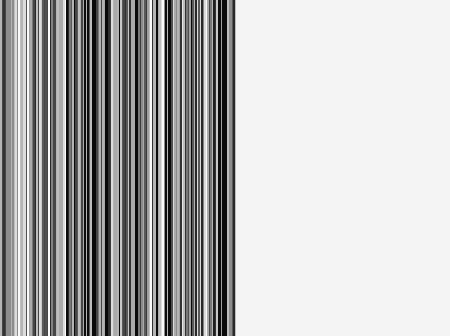

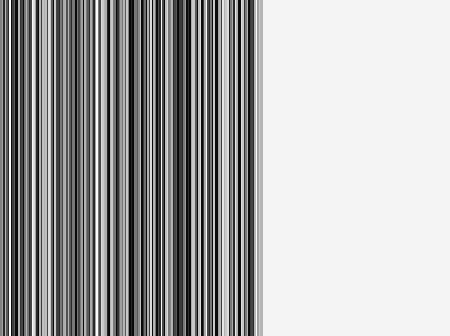

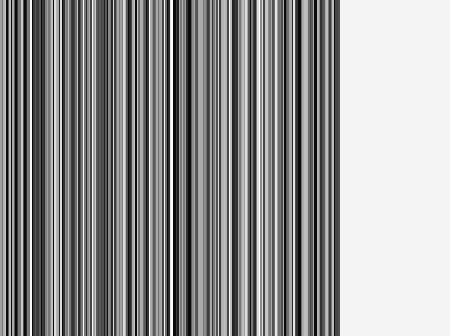

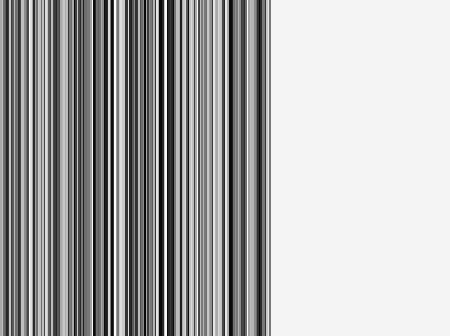

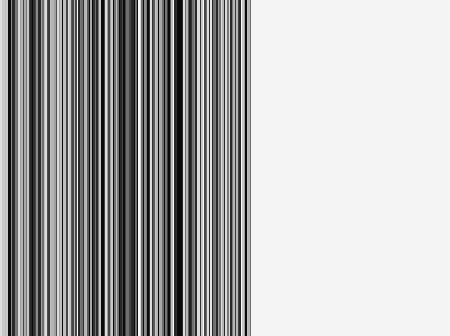

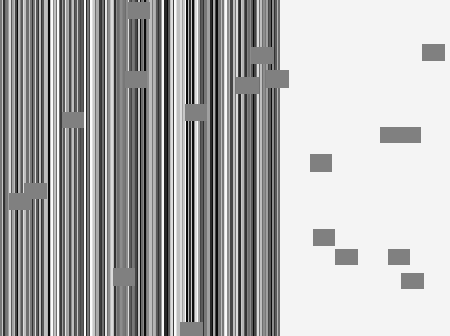

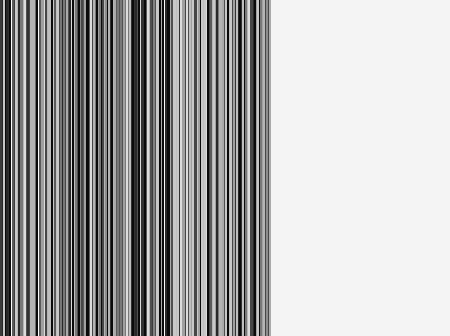

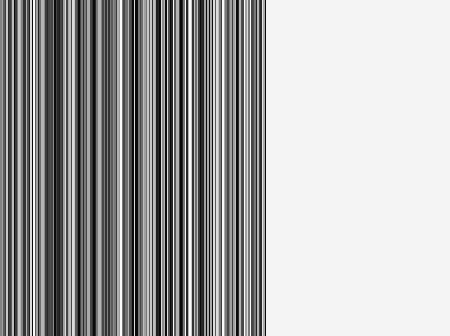

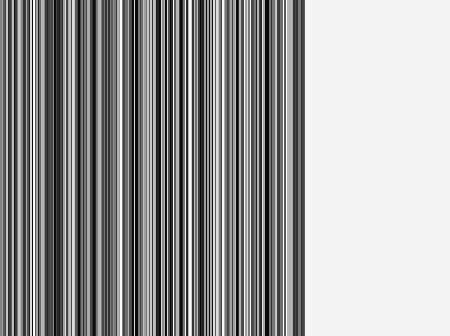

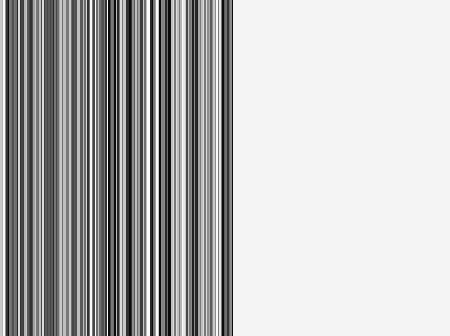

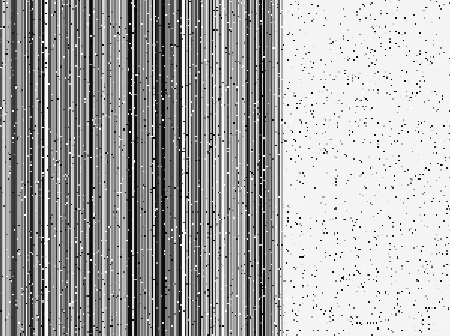

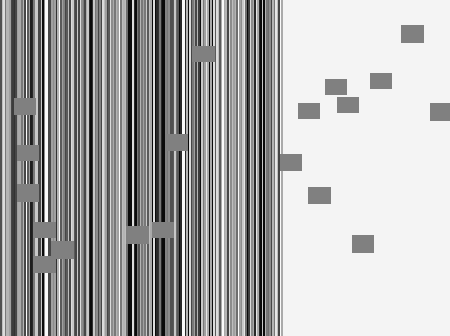

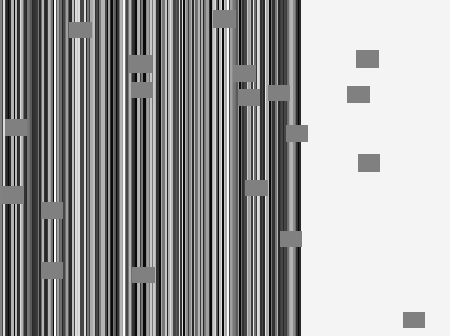

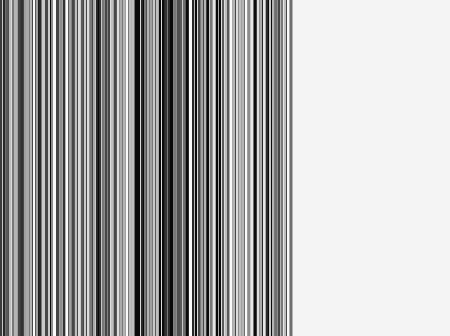

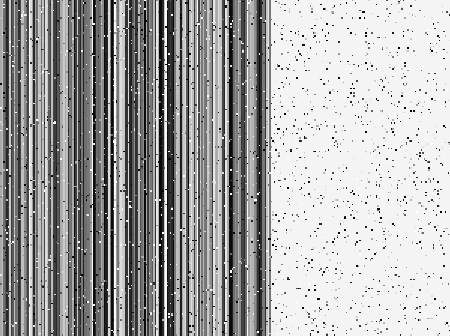

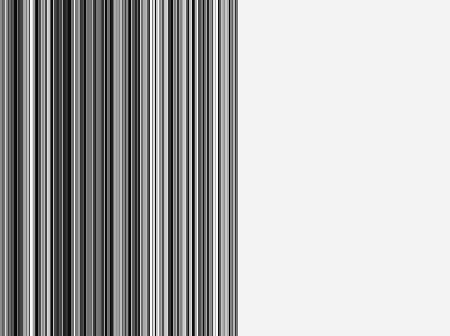

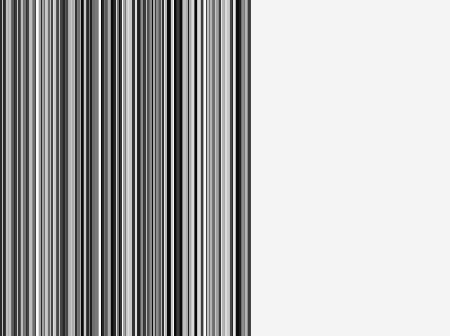

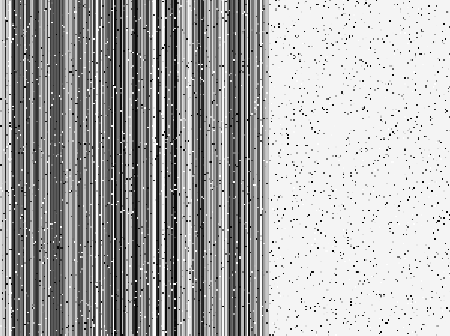

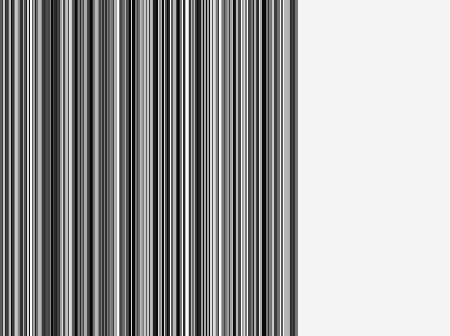

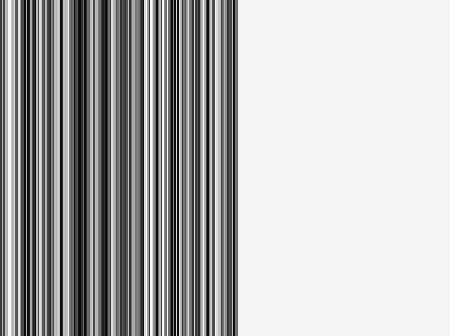

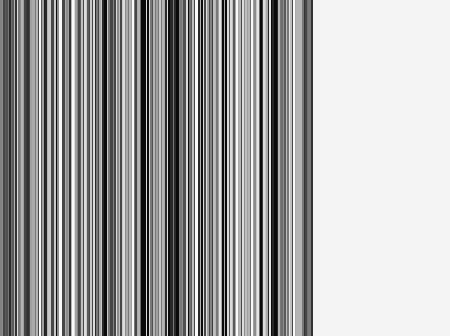

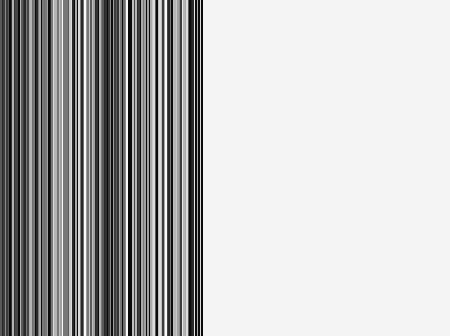

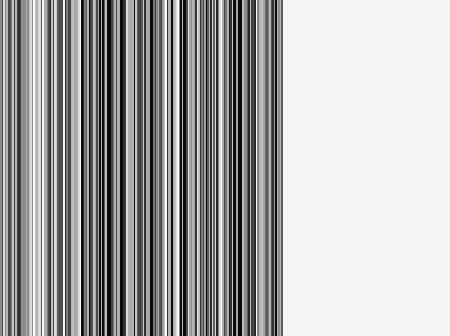

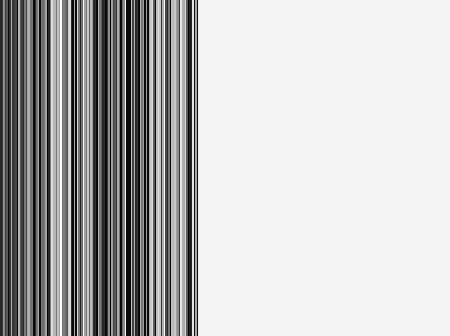

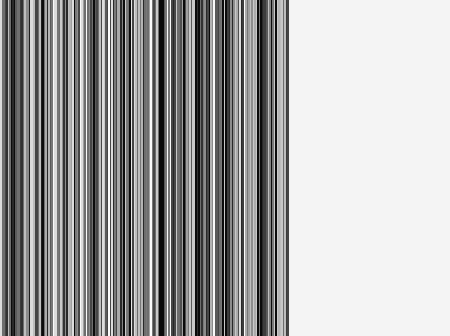

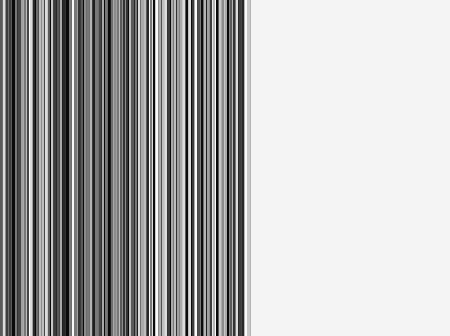

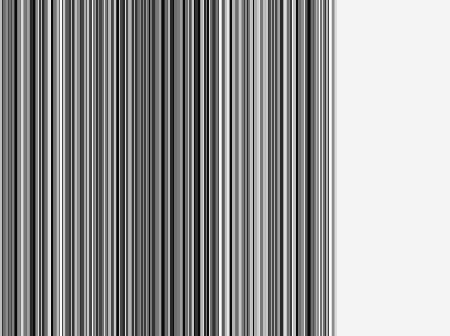

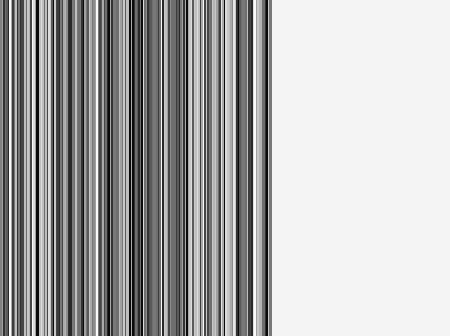

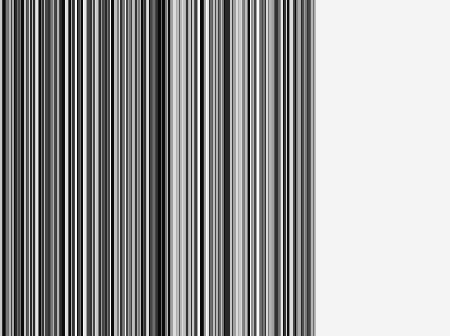

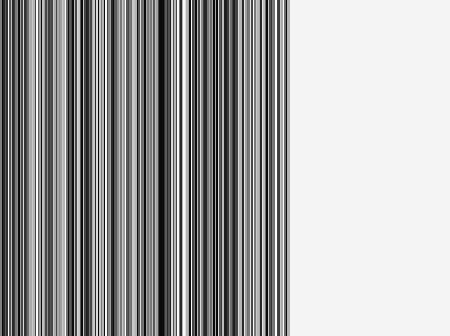

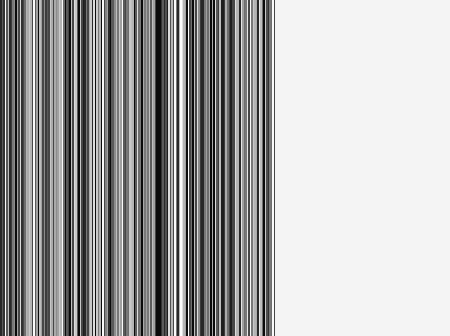

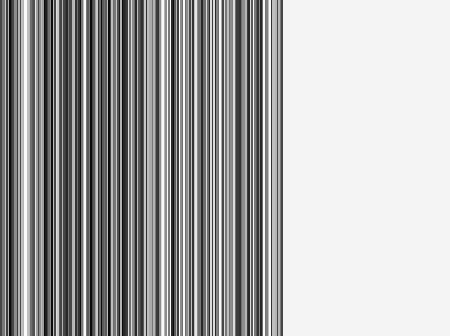

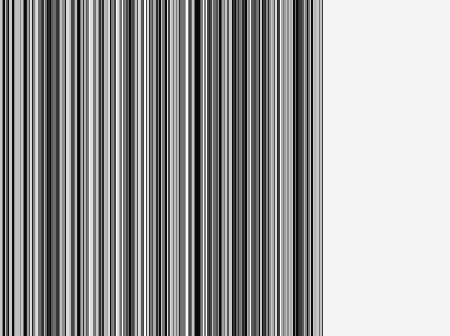

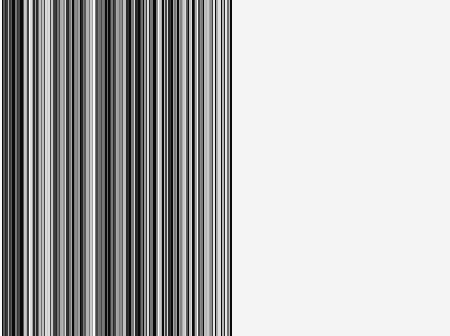

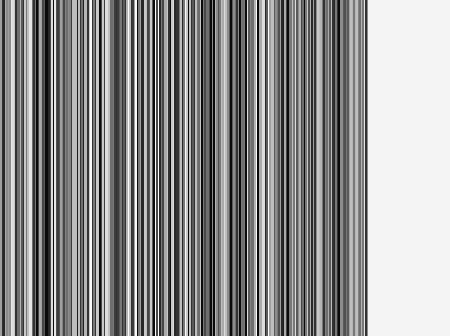

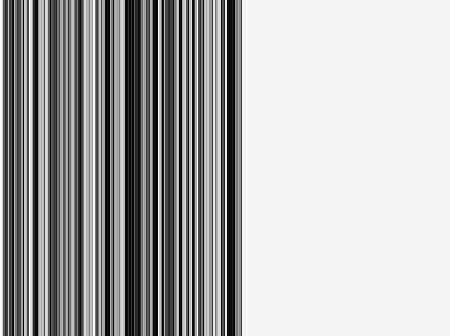

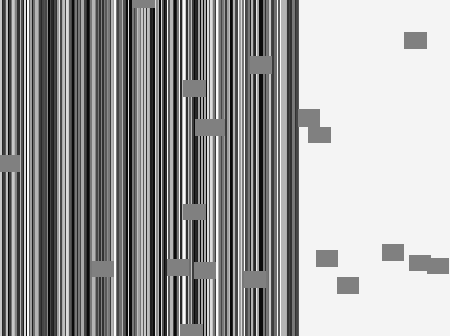

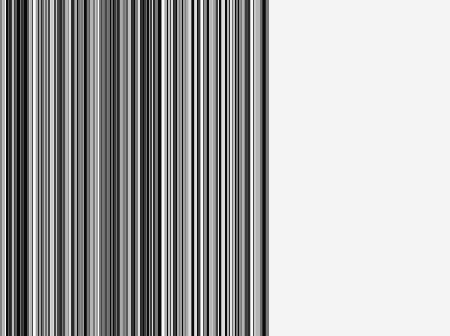

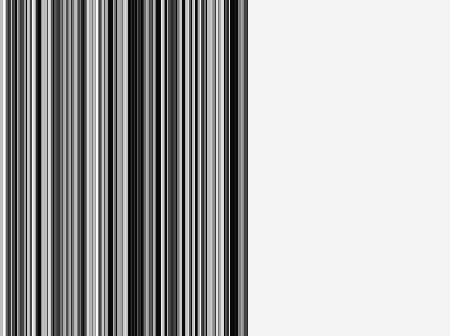

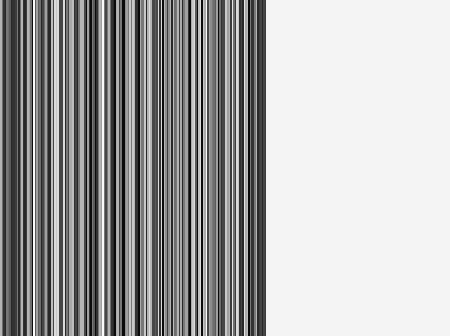

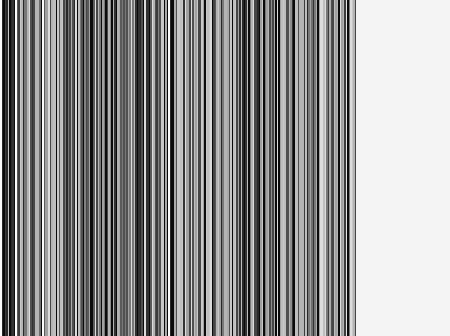

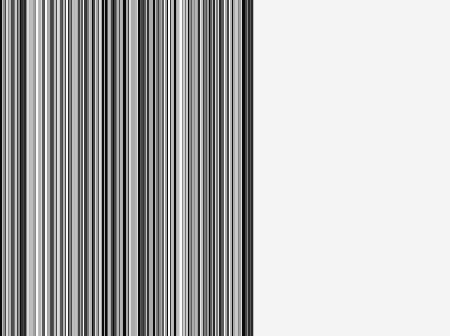

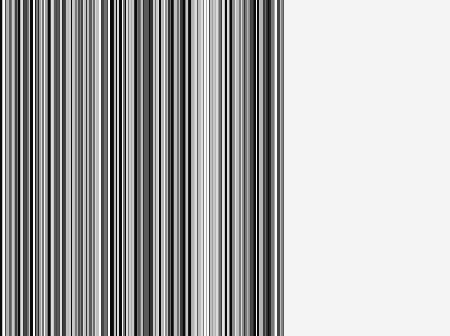

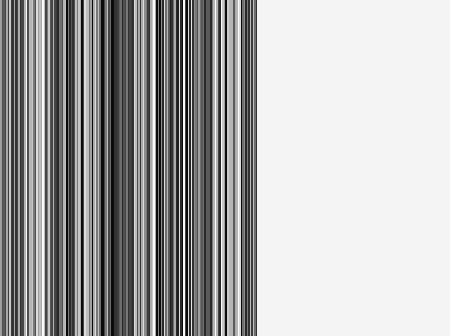

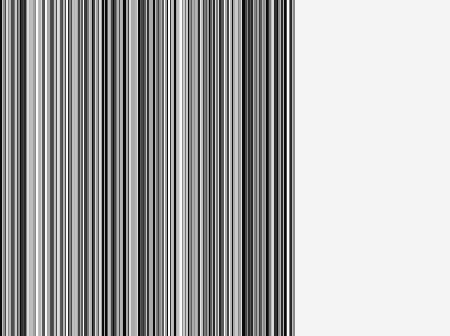

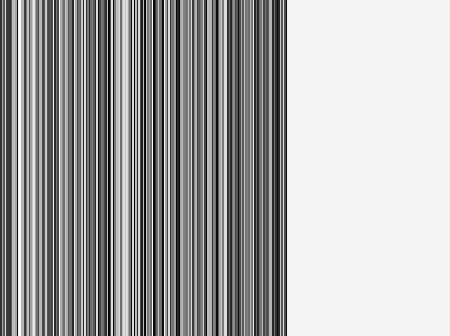

In [7]:
random_samples = list(Path('/home/satish27may/ProteinDomainDetection/data/PfamData/seq_len_0-300_and_num_samples_0-1000_images').glob('*.png'))

for img_pth in random_samples:    
    im = cv2.imread(str(img_pth))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("train").set(thing_classes = classes), 
                   scale=1.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    try:
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1])
    except: 
        pass

In [ ]:
from torch.utils.data import IterableDataset
from itertools import cycle

class SeqLenBasedDataSampler(IterableDataset):
    
    def __init__(self, data=None, seq_len_sample_indexs_map=None):
        self.data = data
        self.seq_len_sample_indexs_map = seq_len_sample_indexs_map
        self.seq_lens = cycle(list(self.seq_len_sample_indexs_map.values()))        
        
    def __iter__(self):
        # get all indexes of a seq len
        seq_len = next(self.seq_lens)
        indexes = self.seq_len_sample_indexs_map[seq_len]
        return [self.data[i] for i in indexes]
    

In [14]:
import itertools
import math
from collections import defaultdict
from typing import Optional
import torch
from torch.utils.data.sampler import Sampler

from detectron2.utils import comm


class TrainingSampler(Sampler):
    """
    In training, we only care about the "infinite stream" of training data.
    So this sampler produces an infinite stream of indices and
    all workers cooperate to correctly shuffle the indices and sample different indices.

    The samplers in each worker effectively produces `indices[worker_id::num_workers]`
    where `indices` is an infinite stream of indices consisting of
    `shuffle(range(size)) + shuffle(range(size)) + ...` (if shuffle is True)
    or `range(size) + range(size) + ...` (if shuffle is False)
    """

    def __init__(self, size: int, shuffle: bool = True, seed: Optional[int] = None):
        """
        Args:
            size (int): the total number of data of the underlying dataset to sample from
            shuffle (bool): whether to shuffle the indices or not
            seed (int): the initial seed of the shuffle. Must be the same
                across all workers. If None, will use a random seed shared
                among workers (require synchronization among all workers).
        """
        self._size = size
        assert size > 0
        self._shuffle = shuffle
        if seed is None:
            seed = comm.shared_random_seed()
        self._seed = int(seed)

        self._rank = comm.get_rank()
        self._world_size = comm.get_world_size()


    def __iter__(self):
        start = self._rank
        yield from itertools.islice(self._infinite_indices(), start, None, self._world_size)

    def _infinite_indices(self):
        g = torch.Generator()
        g.manual_seed(self._seed)
        while True:
            if self._shuffle:
                yield from torch.randperm(self._size, generator=g)
            else:
                yield from torch.arange(self._size)

In [18]:
s = TrainingSampler(size=5)

In [24]:
next(iter(s))

tensor(2)